In [4]:
# Setting working directory: TFG_EduardVergesFranch
import sys
sys.path.append('..')

from test_pipeline_tools.METRICS import *


import importlib 
import test_pipeline_tools.Segments_Loader as seg
importlib.reload(seg)

from test_pipeline_tools.Segments_Loader import song_2_anno, SEGMENTS_LOADER,ex_2_id
from test_pipeline_tools.Segments_Loader import SEGMENTS_LOADER, load_submissions, ExerciseAudioPathExtractor, create_AnnotatedBeatChromaEstimator
from Code.test_utils.training_individual_chord_model import NewModel

from pychord_tools.compositional_data import substitute_zeros, amalgamate, alrinv
from pychord_tools.plots import ternary_plot, plot_labels

from pychord_tools.third_party import NNLSChromaEstimator
from pychord_tools.low_level_features import  AnnotatedBeatChromaEstimator, AnnotatedChromaSegments
from simmusic.feature_extraction import AdaptiveChromaEstimator, GuitarLabelTranslator
from joblib import Memory
import time

from test_pipeline_tools.Visualization import CHORDS_NOTES_VISUALIZATION,visualize

from sklearn.metrics import confusion_matrix,accuracy_score,\
                            precision_recall_fscore_support

from test_pipeline_tools.METRICS import Overall_Metrics,Kind_Metrics,Individual_Metrics, accuracy_by_source

from test_pipeline_tools.Visualization import *

from matplotlib.pyplot import magnitude_spectrum
import essentia.standard as ess

In [4]:
plt.rcParams.update({'font.size': 15})

# Train and Test set load

### Baseline data

SEVA RECORDINGS

In [24]:
MC_base_path = '/home/eduard/Escritorio/pysimmusic-experiments/guitar_for_beginners/'
loader = SEGMENTS_LOADER(MC_base_path )

loader.base_path = os.path.join(loader.base_path,'data')
train_segments = loader.load_chromas_annotation_list('annotations/correct.txt',roll_to_c = True,)
train_segments.chromas.shape

loader.base_path = os.path.join(MC_base_path,'one_time_scripts/guitar_samples_annotation/')
audio_paths = "chroma_pattern_dataset.json"

exercise_id2annotations = {
        26: MC_base_path + 'data/exercises/Leah17Dec2018/Lesson01Ex1/l1ex1.json',
        20: MC_base_path + 'data/exercises/Leah17Dec2018/Lesson02Ex1/l2ex1.json',
        17: MC_base_path + 'data/exercises/Leah17Dec2018/Lesson02Ex2/l2ex2.json',
        16: MC_base_path + 'data/exercises/Leah17Dec2018/Lesson03Ex1/l3ex1.json',
        27: MC_base_path + 'data/exercises/Leah17Dec2018/Lesson04Ex1/l4ex1.json',
        25: MC_base_path + 'data/exercises/Leah17Dec2018/Lesson05Ex1/l5ex1.json'
    }

train_segments = loader.load_chromas_for_dataset(exercise_id2annotations,audio_paths,roll_to_c = True,segments = train_segments)

Loaded 6 files.
Loaded 80 files.

--->>>The train segments  loading took 0.01 s to compute.


In [25]:
dataset_path = '../Databases/'
loader_name = 'Loaders/MeldaProducion_Rooms.json'

loader = SEGMENTS_LOADER(dataset_path)
train_segments = loader.load_chromas_for_dataset(ex_2_id,loader_name, roll_to_c = True, segments = train_segments)

Loaded 1020 files.

--->>>The train segments  loading took 0.26 s to compute.


In [26]:
print('You loaded {} chromas.'.format(train_segments.chromas.shape[0]))

You loaded 130500 chromas.


15031


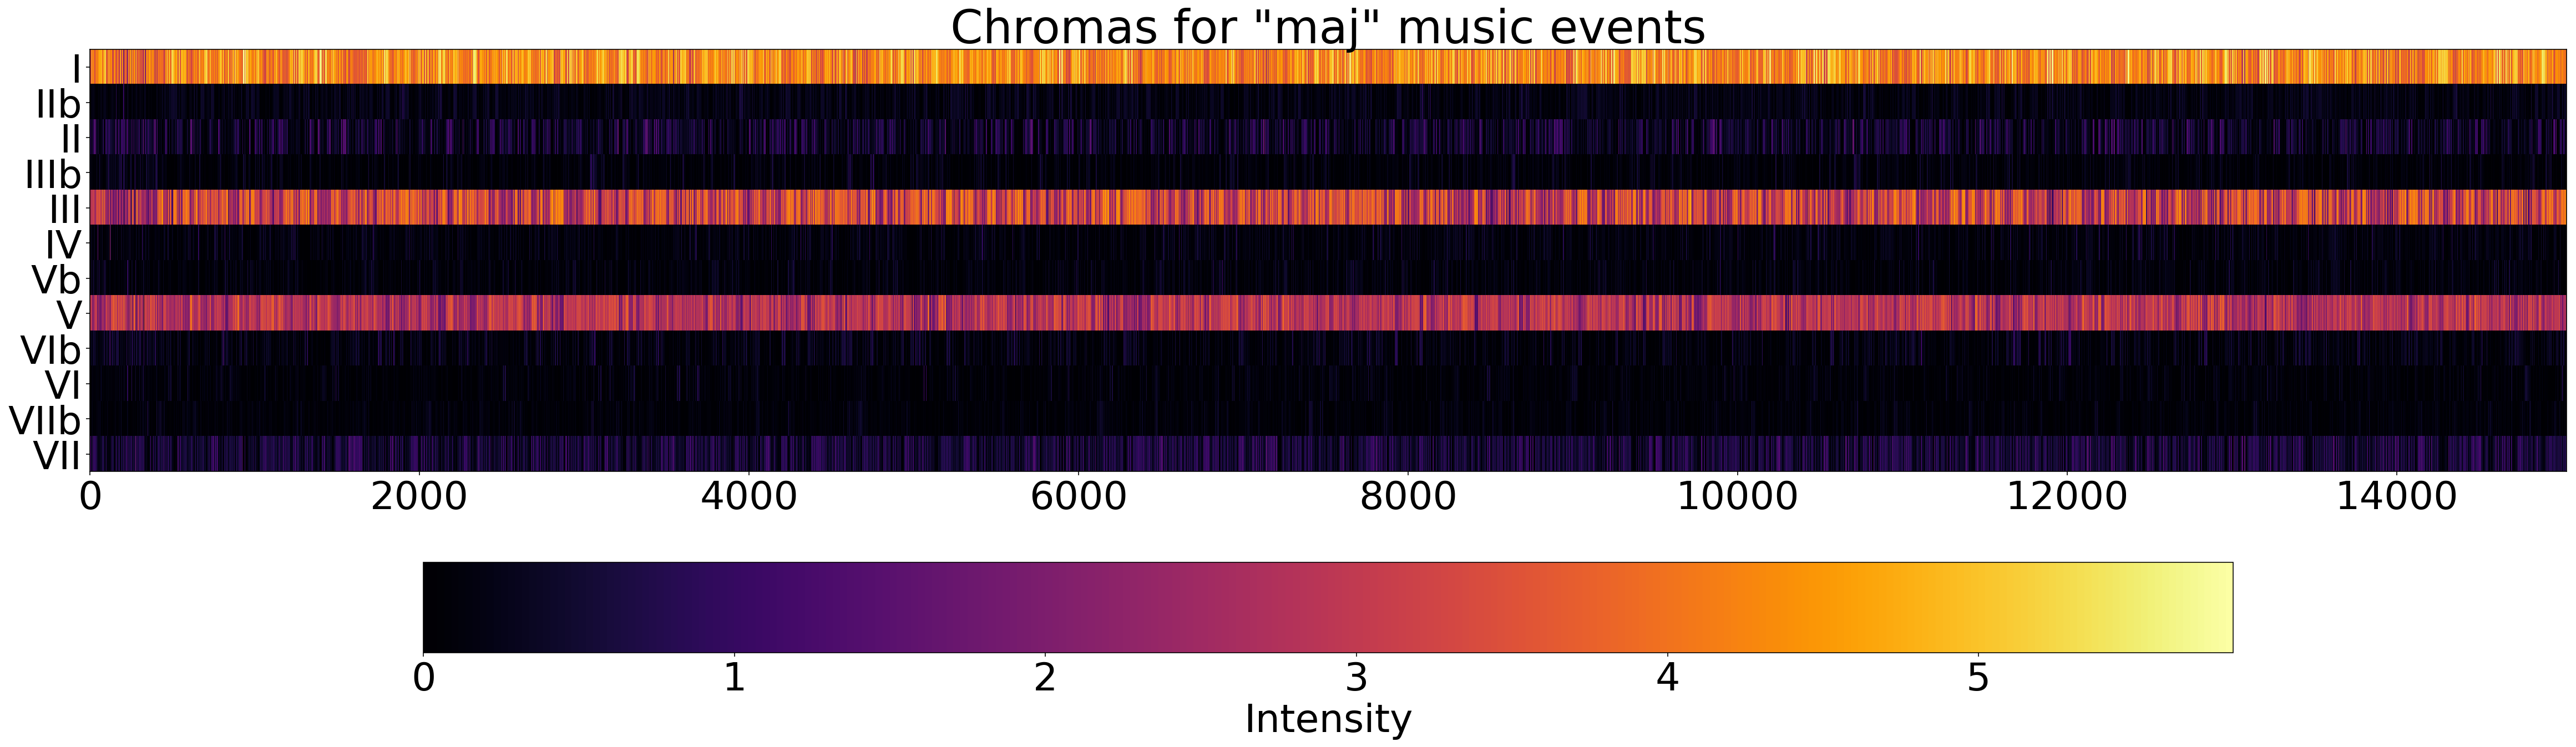

In [20]:
kind = 'maj'
c = train_segments.chromas[train_segments.kinds == kind]
print(len(c))
plt.rcParams.update({'font.size': 35})
fig = plt.figure(figsize=(40,10))
ax = fig.add_subplot(111)
ax.set_yticks(range(12))
ax.set_yticklabels(['I', 'IIb', 'II', 'IIIb', 'III', 'IV', 'Vb', 'V', 'VIb', 'VI', 'VIIb', 'VII'])
ax.set_title('Chromas for "' + kind + '" music events')
img = ax.imshow(c.T,cmap='inferno',aspect='auto',interpolation='nearest')


cbar = fig.colorbar(img,orientation="horizontal")
cbar.set_label('Intensity')

In [28]:
is_defined = [x != 'unclassified' for x in train_segments.kinds]
train_segments = AnnotatedChromaSegments(
    train_segments.labels[is_defined],
    train_segments.pitches[is_defined],
    train_segments.kinds[is_defined],
    train_segments.chromas[is_defined],
    train_segments.uids[is_defined],
    train_segments.start_times[is_defined],
    train_segments.durations[is_defined])

print('Train set has {} chromas.'.format(train_segments.chromas.shape[0]))

for k in ['maj','min','1','5','+3','-3']:
    print('{} -> Num chromas: {}'.format(k,len(train_segments.chromas[train_segments.kinds == k])))

Train set has 117178 chromas.
maj -> Num chromas: 15031
min -> Num chromas: 12547
1 -> Num chromas: 66968
5 -> Num chromas: 9032
+3 -> Num chromas: 6120
-3 -> Num chromas: 7480


# Personal Data Set

In [17]:
MC_base_path = '/home/eduard/Escritorio/pysimmusic-experiments/guitar_for_beginners/'
loader = SEGMENTS_LOADER(MC_base_path )

loader.base_path = os.path.join(loader.base_path,'data')
test_segments = loader.load_chromas_annotation_list('annotations/correct.txt',roll_to_c = False,)
test_segments.chromas.shape

loader.base_path = os.path.join(MC_base_path,'one_time_scripts/guitar_samples_annotation/')
audio_paths = "chroma_pattern_dataset.json"

exercise_id2annotations = {
        26: MC_base_path + 'data/exercises/Leah17Dec2018/Lesson01Ex1/l1ex1.json',
        20: MC_base_path + 'data/exercises/Leah17Dec2018/Lesson02Ex1/l2ex1.json',
        17: MC_base_path + 'data/exercises/Leah17Dec2018/Lesson02Ex2/l2ex2.json',
        16: MC_base_path + 'data/exercises/Leah17Dec2018/Lesson03Ex1/l3ex1.json',
        27: MC_base_path + 'data/exercises/Leah17Dec2018/Lesson04Ex1/l4ex1.json',
        25: MC_base_path + 'data/exercises/Leah17Dec2018/Lesson05Ex1/l5ex1.json'
    }

test_segments = loader.load_chromas_for_dataset(exercise_id2annotations,audio_paths,roll_to_c = False,segments = test_segments)

Loaded 6 files.
Loaded 80 files.

--->>>The train segments  loading took 0.03 s to compute.


In [21]:
# dataset_path = '../Databases/'
dataset_path = '../Databases/'
loader_name = 'Loaders/MeldaProducion_Rooms.json'

loader = SEGMENTS_LOADER(dataset_path)
test_segments = loader.load_chromas_for_dataset(ex_2_id,loader_name, roll_to_c = False, segments = test_segments)

Loaded 1020 files.

--->>>The train segments  loading took 0.43 s to compute.


### Only adding data for test set

In [71]:
dataset_path = '../Databases/'
loader_name = 'Loaders/Guitar_filters_test.json'

loader = SEGMENTS_LOADER(dataset_path)
test_segments = loader.load_chromas_for_dataset(ex_2_id,loader_name, roll_to_c = False, segments = None)

with open(dataset_path+ loader_name) as af:
    test_audios = json.load(af)

# Adding more pitch class sets to the model

Add data to the basic train data set

In [9]:
dataset_path = '../Databases/'
loader = SEGMENTS_LOADER(dataset_path)

loader_3rds = 'Loaders/Raw_database_with_third_intervals.json' # From raw database separate recordings with third intervals
loader_no3rds = 'Loaders/Raw_database_without_third_intervals.json' #From Raw  database, separate recodings with no third intervals

In [10]:
train_audios, test_audios, train_segments, test_segments = loader.train_test_split_json(loader_3rds,
                                                                                 ex_2_id, 
                                                                                 seed_num  =1, 
                                                                                 split=0.5, 
                                                                                 segments= train_segments) #Split recordings with thrid intervals in train/test

test_segments = loader.load_chromas_for_dataset(ex_2_id,loader_no3rds, roll_to_c = False, segments = test_segments)

Memory(cachedir='../Cached_Segments/joblib')
Building train set ...
Loading:  Raw_database/Mountain_Larrivee_104_Computer.wav
Loading:  Raw_database/Mountain_Epiphone_104_Computer.wav
Loading:  Raw_database/Mountain_Eastman_104_DI.wav
Loading:  Raw_database/Mountain_Telecaster_104_Computer.wav
Loading:  Raw_database/Mountain_Eastman_104_Mobile.wav
Loading:  Raw_database/Mountain_Ibanez_104_Mobile.wav
Loading:  Raw_database/Mountain_Larrivee_104_Mobile.wav

--->>>The train segments  loading took 16.59 s to compute.
Building test set ...
Loading:  Raw_database/Mountain_Ibanez_104_Computer.wav
Loading:  Raw_database/Mountain_Eastman_104_Computer.wav
Loading:  Raw_database/Mountain_Telecaster_104_Mobile.wav
Loading:  Raw_database/Mountain_Epiphone_104_Mobile.wav
Loading:  Raw_database/Mountain_Telecaster_104_DI.wav
Loading:  Raw_database/Mountain_Ibanez_104_DI.wav
Loading:  Raw_database/Mountain_Epiphone_104_DI.wav
Loading:  Raw_database/Mountain_Larrivee_104_DI.wav

--->>>The test segment

In [11]:
with open(dataset_path+ loader_no3rds) as af:
    test_audios.append(json.load(af))

### How training data affect to the model performance

In [35]:
dataset_path = '../Databases/'
loader = SEGMENTS_LOADER(dataset_path)

# Lily, Mountain, Where, Train, Century, Hole

train_audios, test_audios, train_segments, test_segments = loader.train_test_split_filtered_field(ex_2_id,
                                                                                   'Loaders/Raw_database.json',
                                                                                   filter_field =['Century_'],
                                                                                  segments = None)

Memory(cachedir='../Cached_Segments/joblib')
Building Train set...

--->>>The train segments  loading took 0.06 s to compute.
Building test set ...

--->>>The test segments  loading took 0.02 s to compute.


### Training model with large amount of data

In [73]:
dataset_path = '/media/eduard/Maxtor/TFG_DATABASE_AUGMENTATION/'
loader = SEGMENTS_LOADER(dataset_path)
folds =  loader.load_folds_database('loaders/Folds_MeldaProduction_Rooms.json')

In [74]:
fold = 0
train_rec = folds[fold][0]
test_rec = folds [fold] [1]
train_rec, test_rec, train_segments, test_segments = loader.load_train_test_segments(train_rec,test_rec, ex_2_id,segments = None)

Memory(cachedir='../Cached_Segments/joblib')
Building train set ...

--->>>The train segments  loading took 0.19 s to compute.
Building test set ...

--->>>The test segments  loading took 0.06 s to compute.


# Filter third intervals

In [24]:
# comment this to consider third intervals in the test set
for i, k in enumerate(test_segments.kinds):
    if k == '+3' or k == '-3':
        test_segments.kinds[i] = 'unclassified'

is_defined = [x != 'unclassified' for x in test_segments.kinds]
test_segments = AnnotatedChromaSegments(
    test_segments.labels[is_defined],
    test_segments.pitches[is_defined],
    test_segments.kinds[is_defined],
    test_segments.chromas[is_defined],
    test_segments.uids[is_defined],
    test_segments.start_times[is_defined],
    test_segments.durations[is_defined])

print('Test set has {} chromas.'.format(test_segments.chromas.shape[0]))

for k in ['maj','min','1','5','+3','-3']:
    print('{} -> Num chromas: {}'.format(k,len(test_segments.chromas[test_segments.kinds == k])))

Test set has 103578 chromas.
maj -> Num chromas: 15031
min -> Num chromas: 12547
1 -> Num chromas: 66968
5 -> Num chromas: 9032
+3 -> Num chromas: 0
-3 -> Num chromas: 0


In [79]:
#comment this to consider third intervals in the test set
for i, k in enumerate(train_segments.kinds):
    if k == '+3' or k == '-3':
        train_segments.kinds[i] = 'unclassified'

is_defined = [x != 'unclassified' for x in train_segments.kinds]
train_segments = AnnotatedChromaSegments(
    train_segments.labels[is_defined],
    train_segments.pitches[is_defined],
    train_segments.kinds[is_defined],
    train_segments.chromas[is_defined],
    train_segments.uids[is_defined],
    train_segments.start_times[is_defined],
    train_segments.durations[is_defined])

print('Test set has {} chromas.'.format(train_segments.chromas.shape[0]))

for k in ['maj','min','1','5','+3','-3']:
    print('{} -> Num chromas: {}'.format(k,len(train_segments.chromas[train_segments.kinds == k])))

Test set has 82261 chromas.
maj -> Num chromas: 13741
min -> Num chromas: 11265
1 -> Num chromas: 51295
5 -> Num chromas: 5960
+3 -> Num chromas: 0
-3 -> Num chromas: 0


In [80]:
for k in ['maj','min','1','5','+3','-3']:
    A = len(test_segments.chromas[test_segments.kinds == k])
    B = len(train_segments.chromas[train_segments.kinds == k])
    
    print (k + '   '+ str(A+B))
print(train_segments.chromas.shape[0] + test_segments.chromas.shape[0])

maj   14620
min   12240
1   66130
5   8840
+3   0
-3   0
101830


# Visualize sets

In [12]:
plt.rcParams.update({'font.size': 15})

In [52]:
kinds = ['maj','min','1','5']#,'+3','-3']

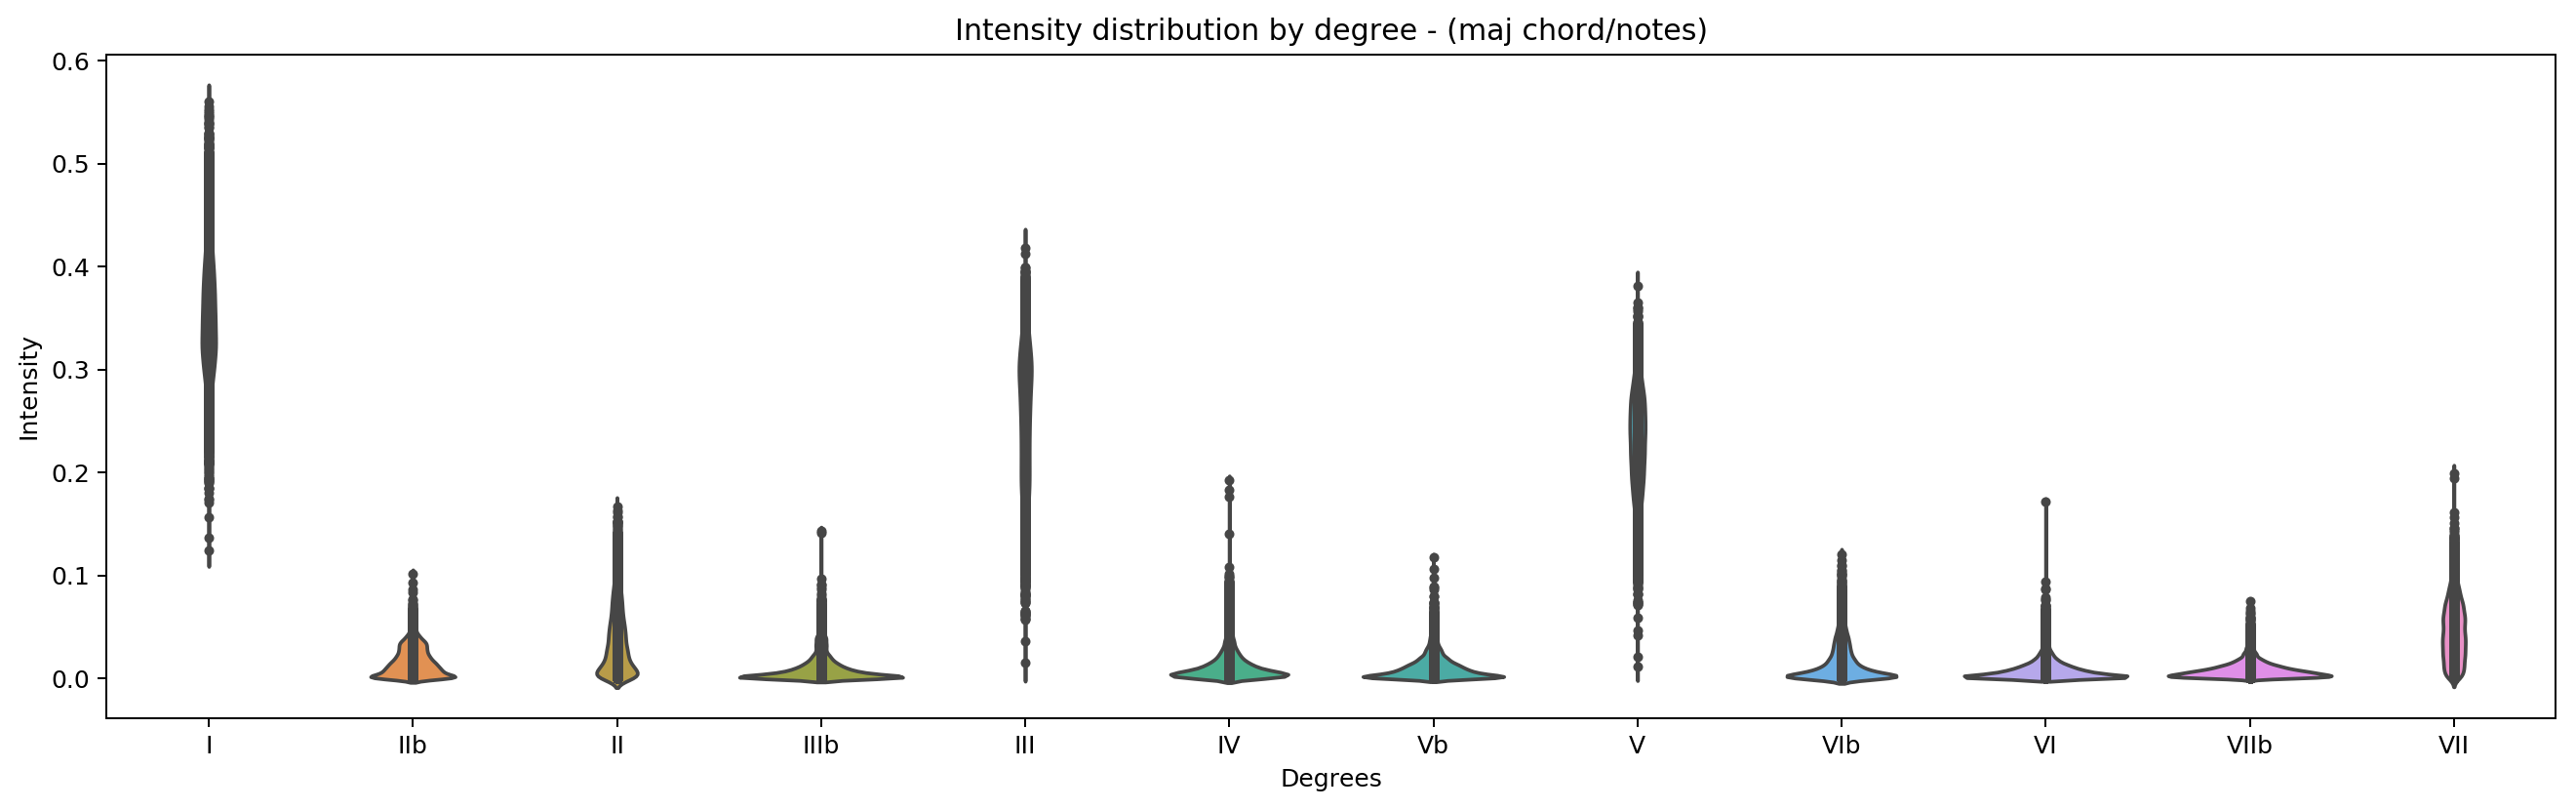

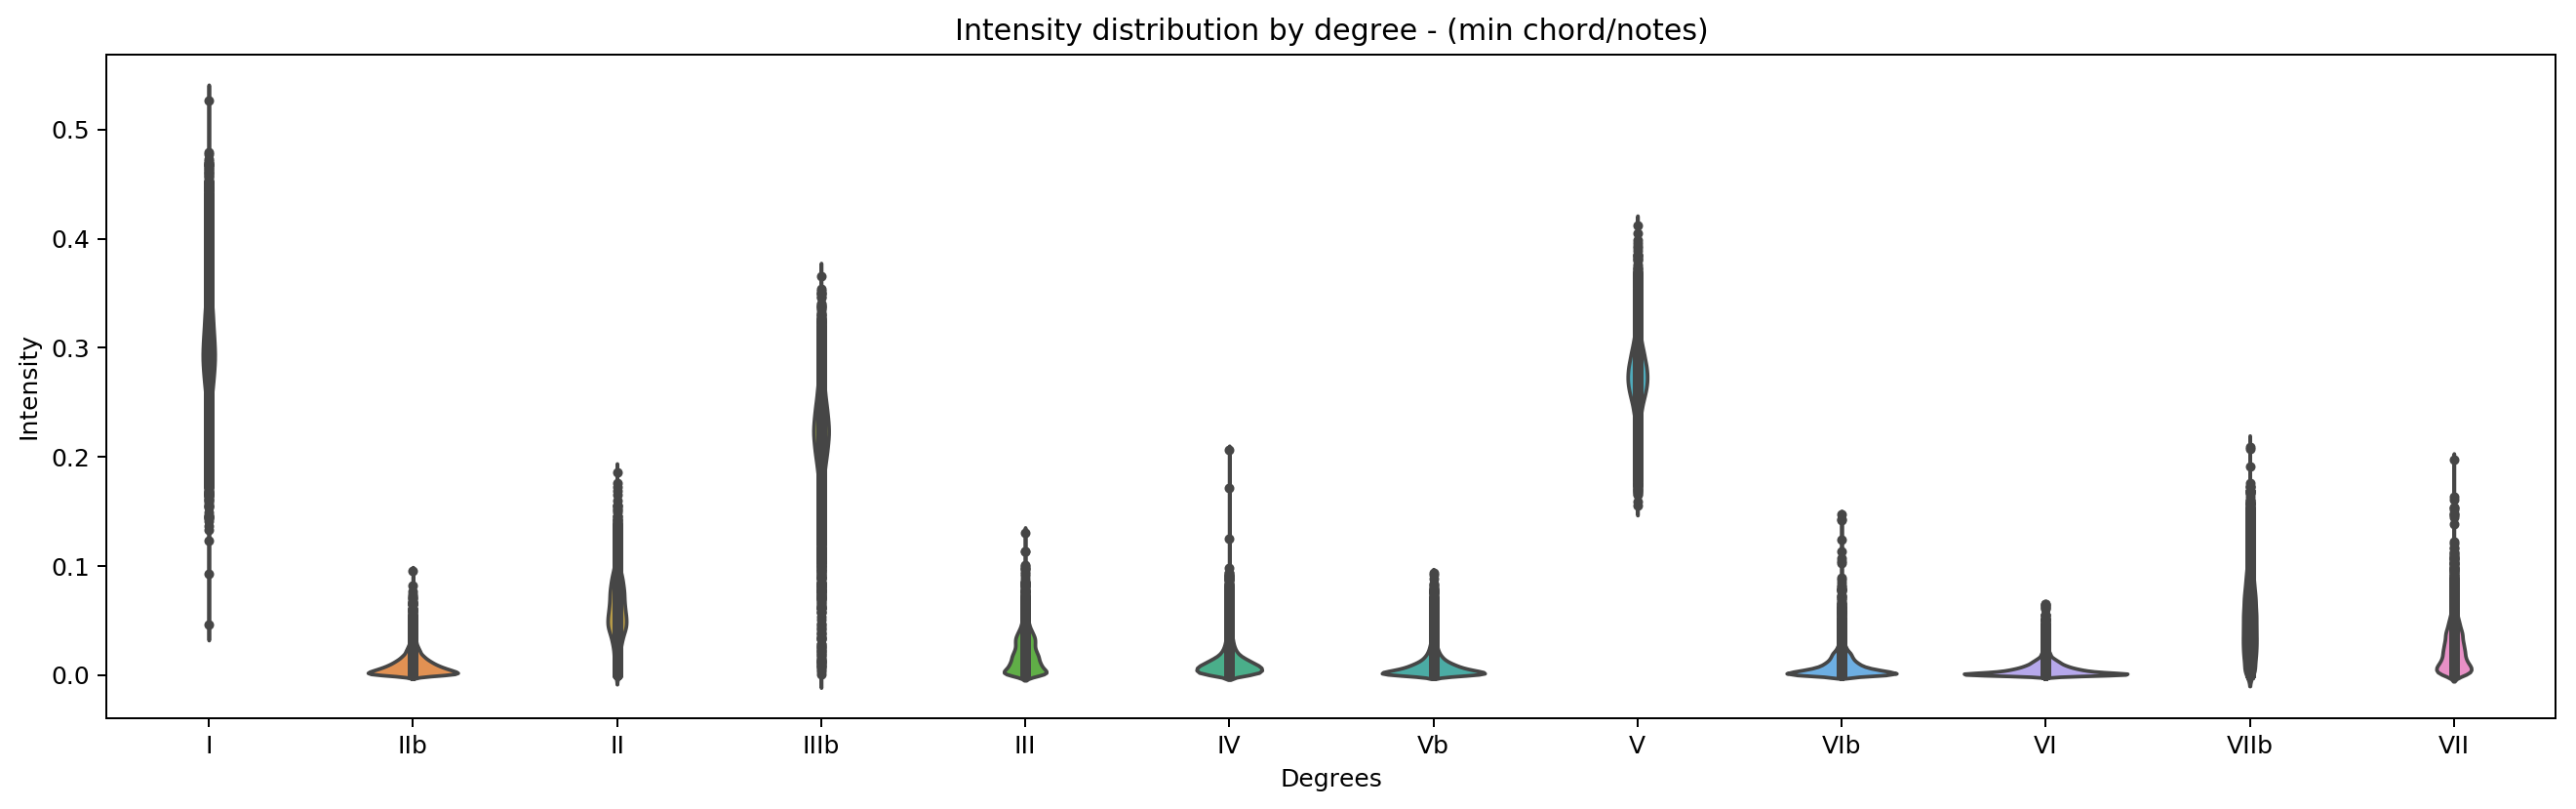

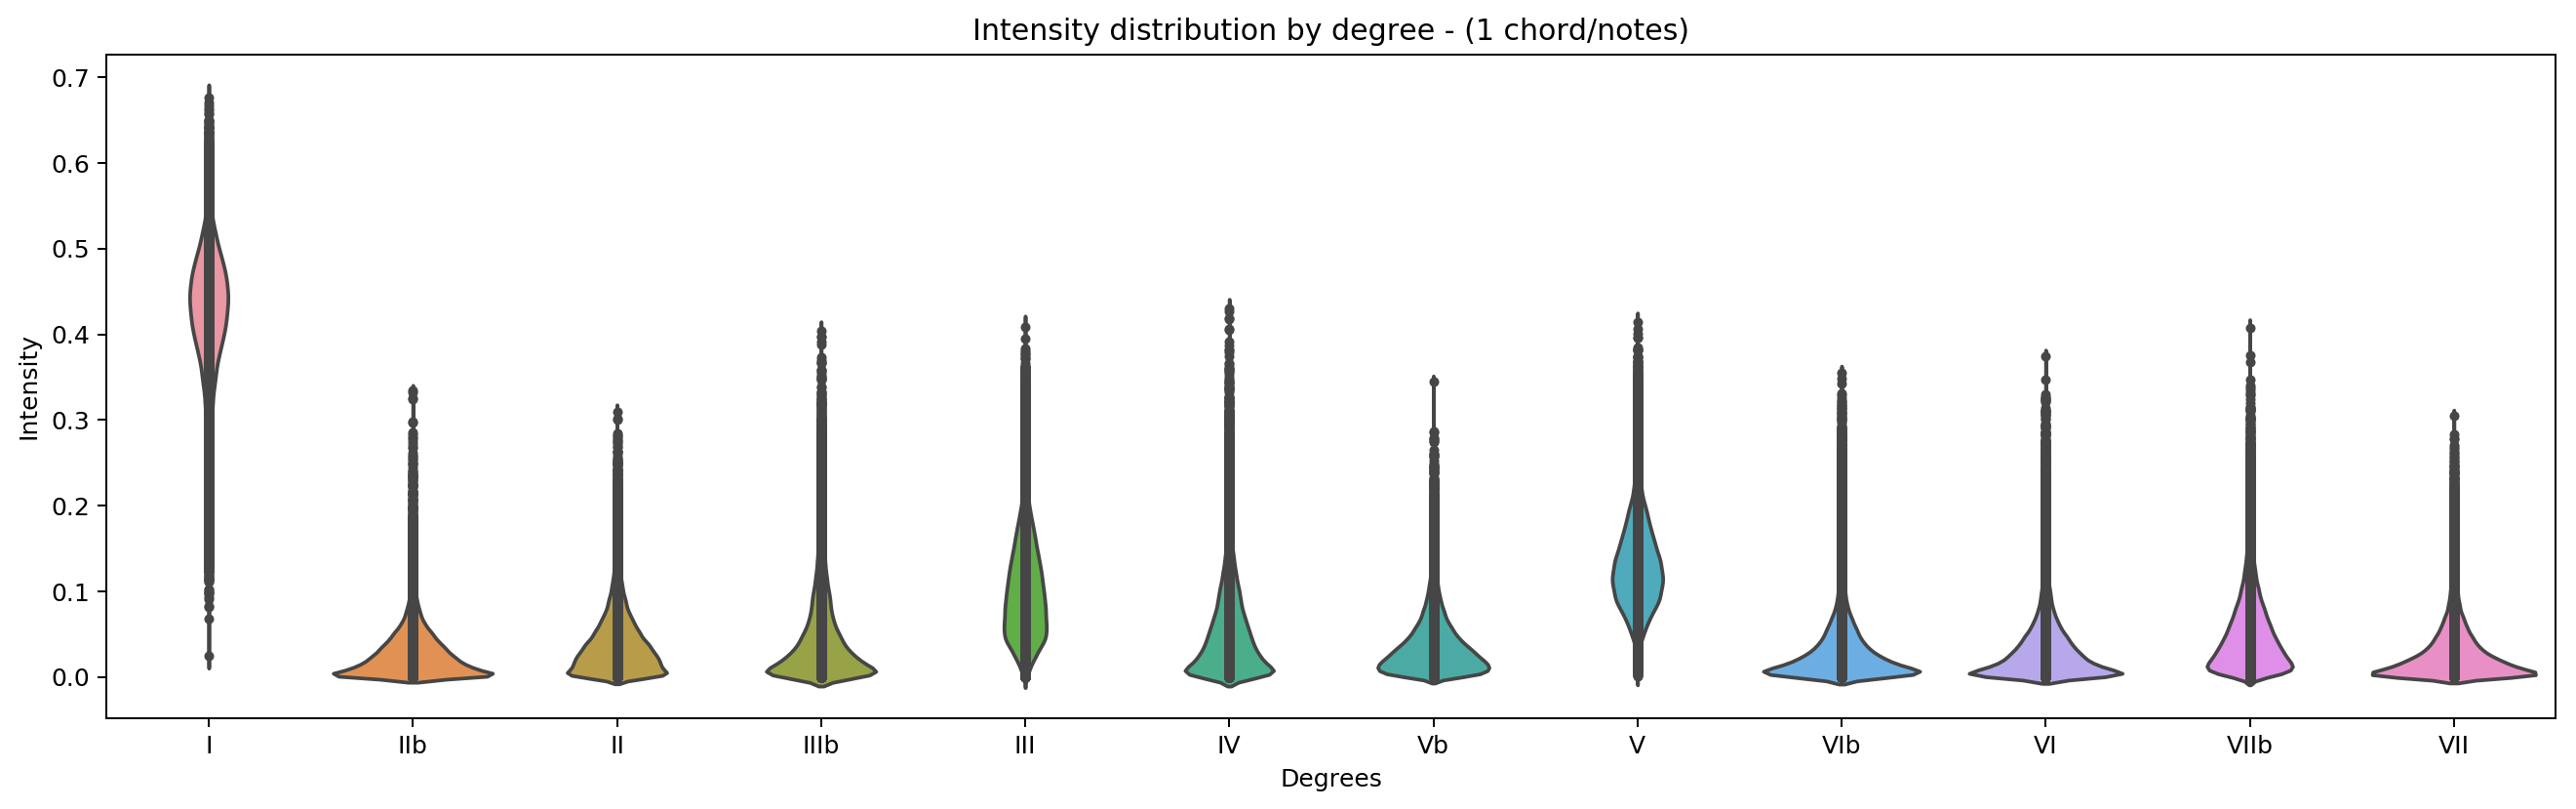

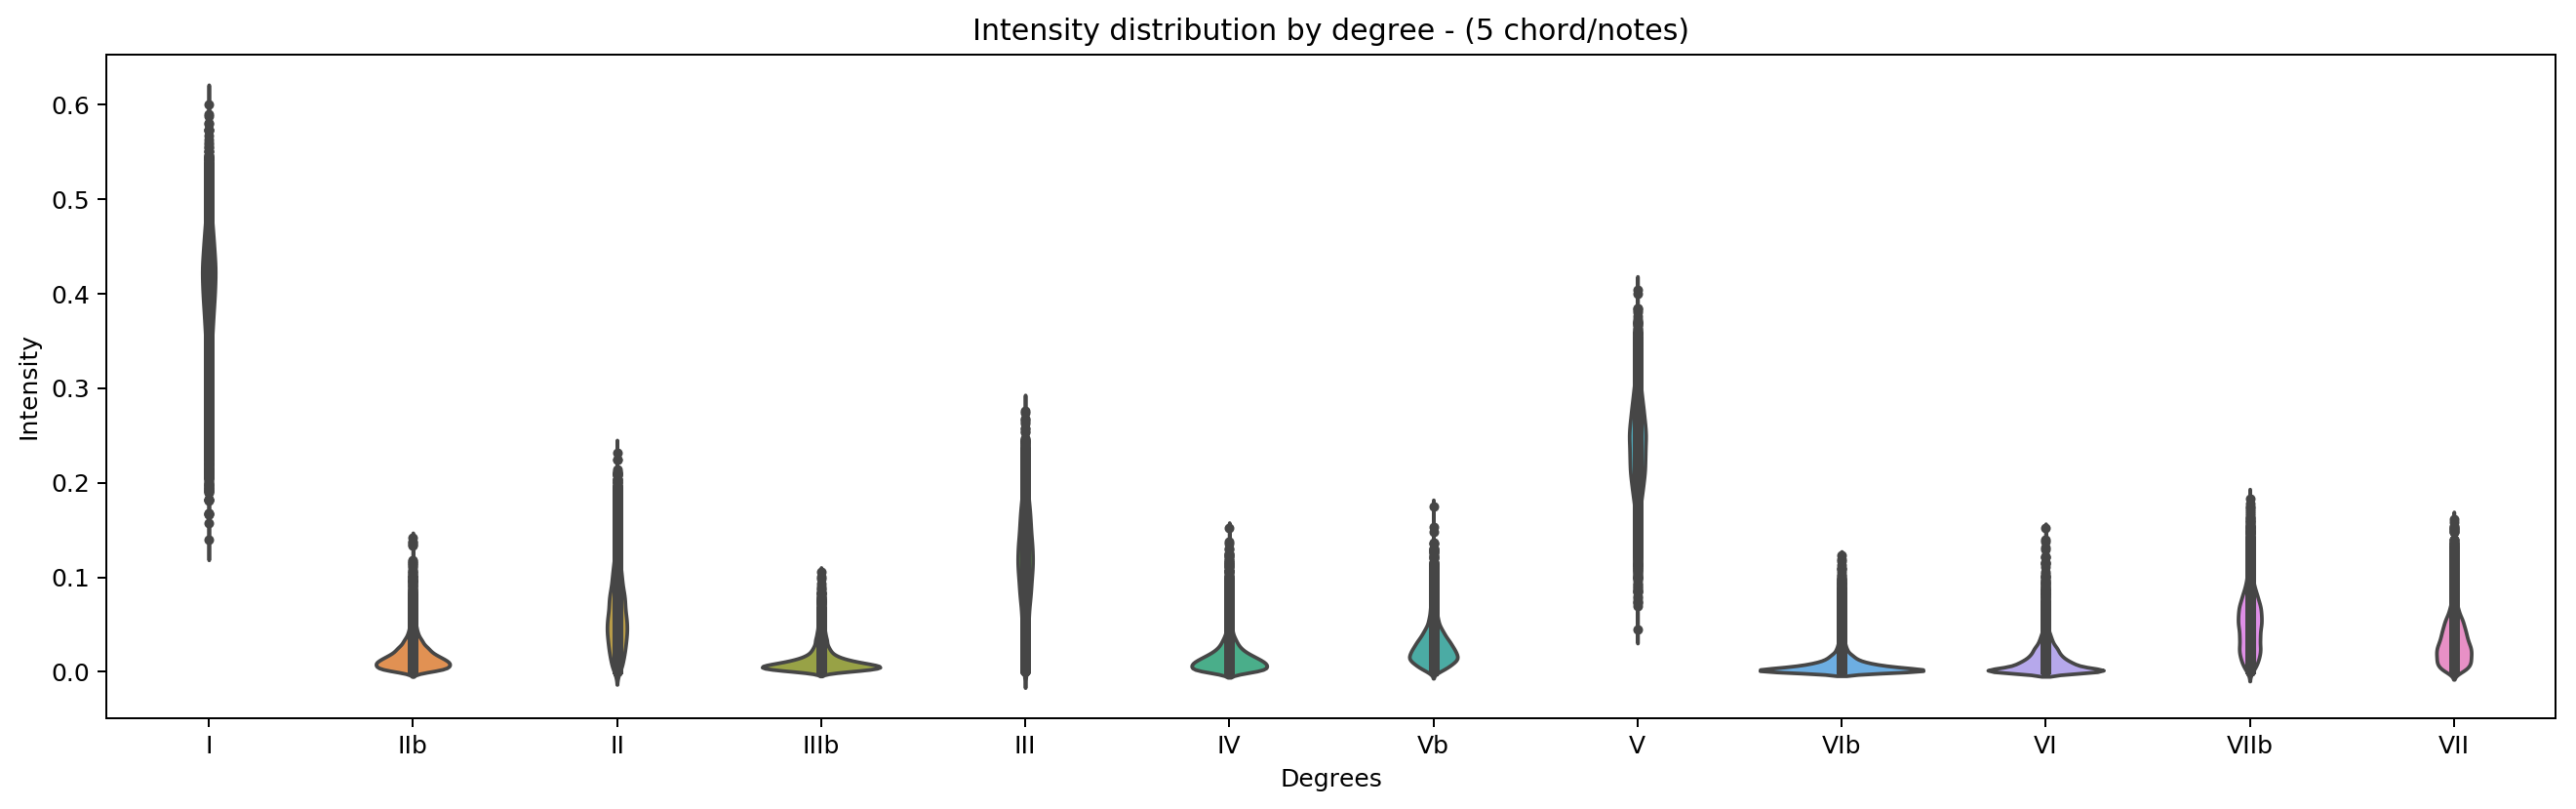

In [60]:
#Plot degree distributions

for k in kinds:
    try:
        vis = CHORDS_NOTES_VISUALIZATION(train_segments, kind=k )
        vis.intensity_distribution_by_degree()
    except:
        print(' No ' + k +' in train set')

Test
Test
Test
Test


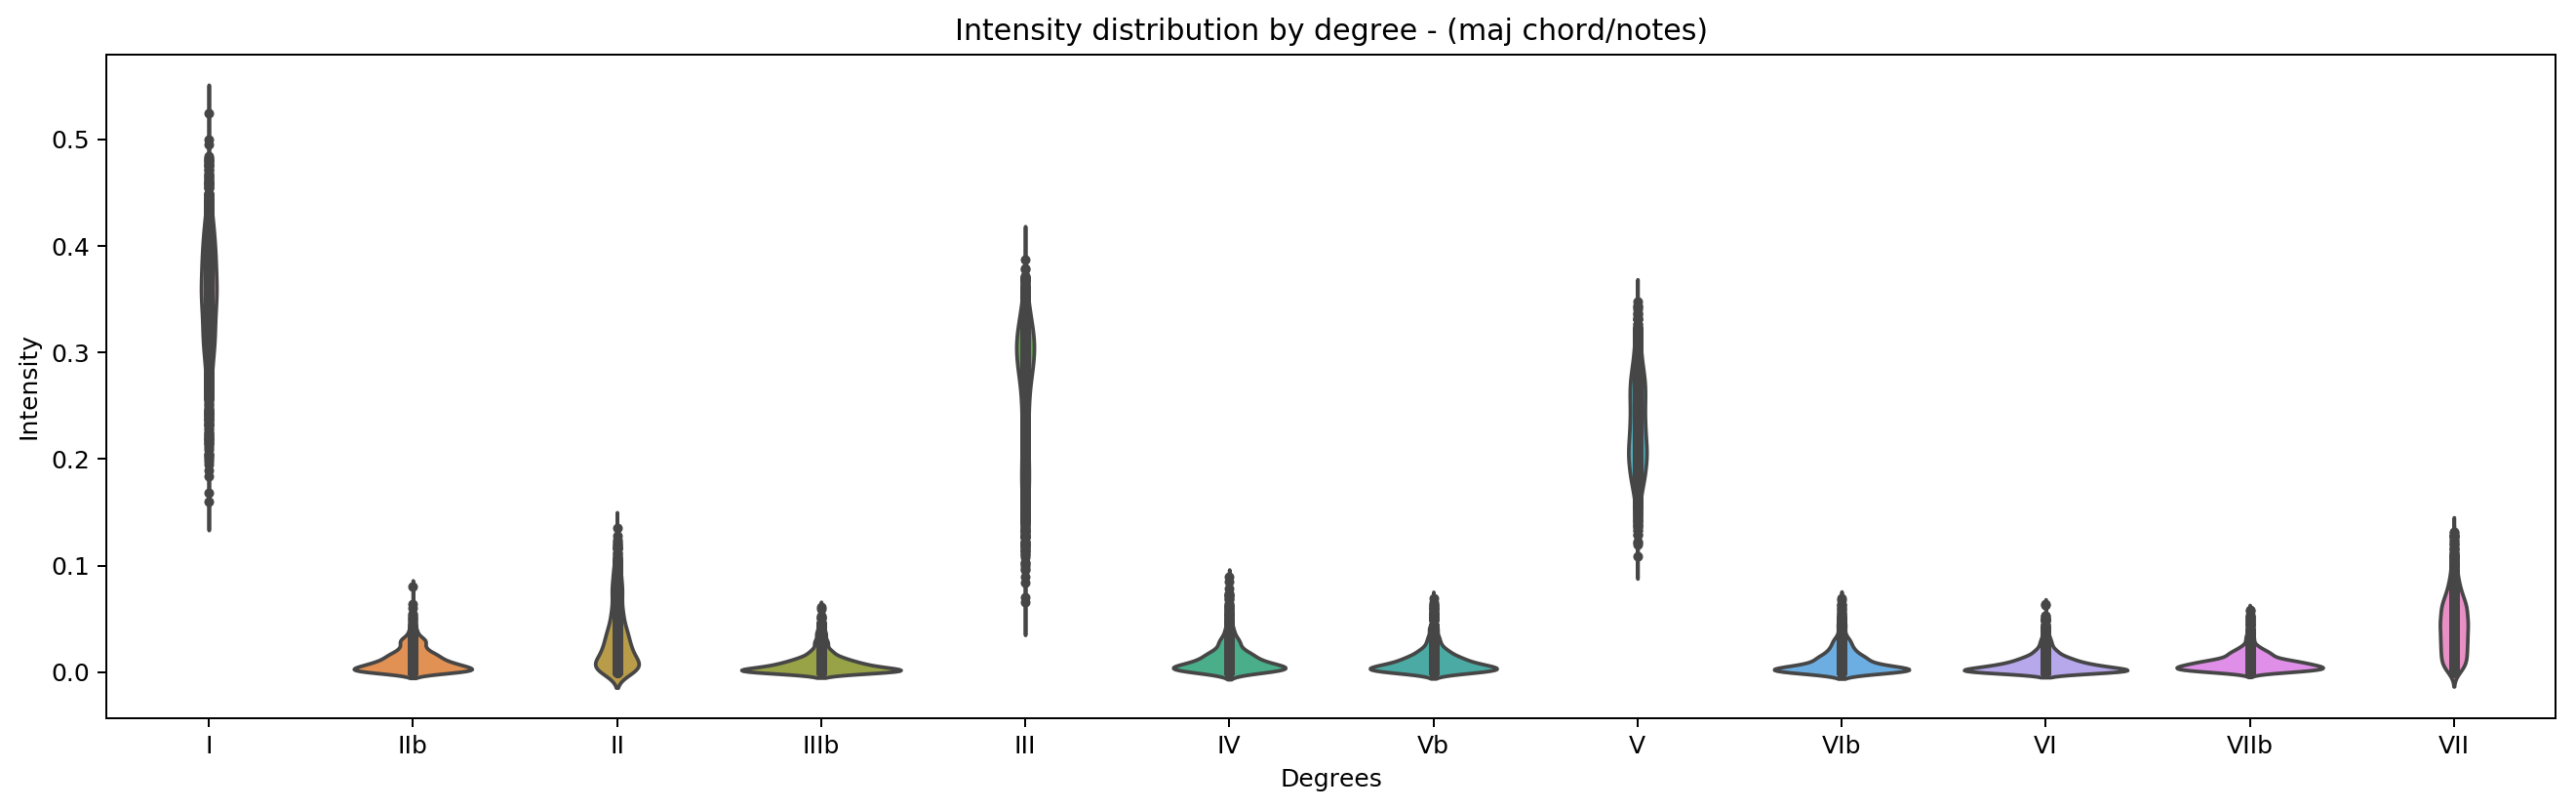

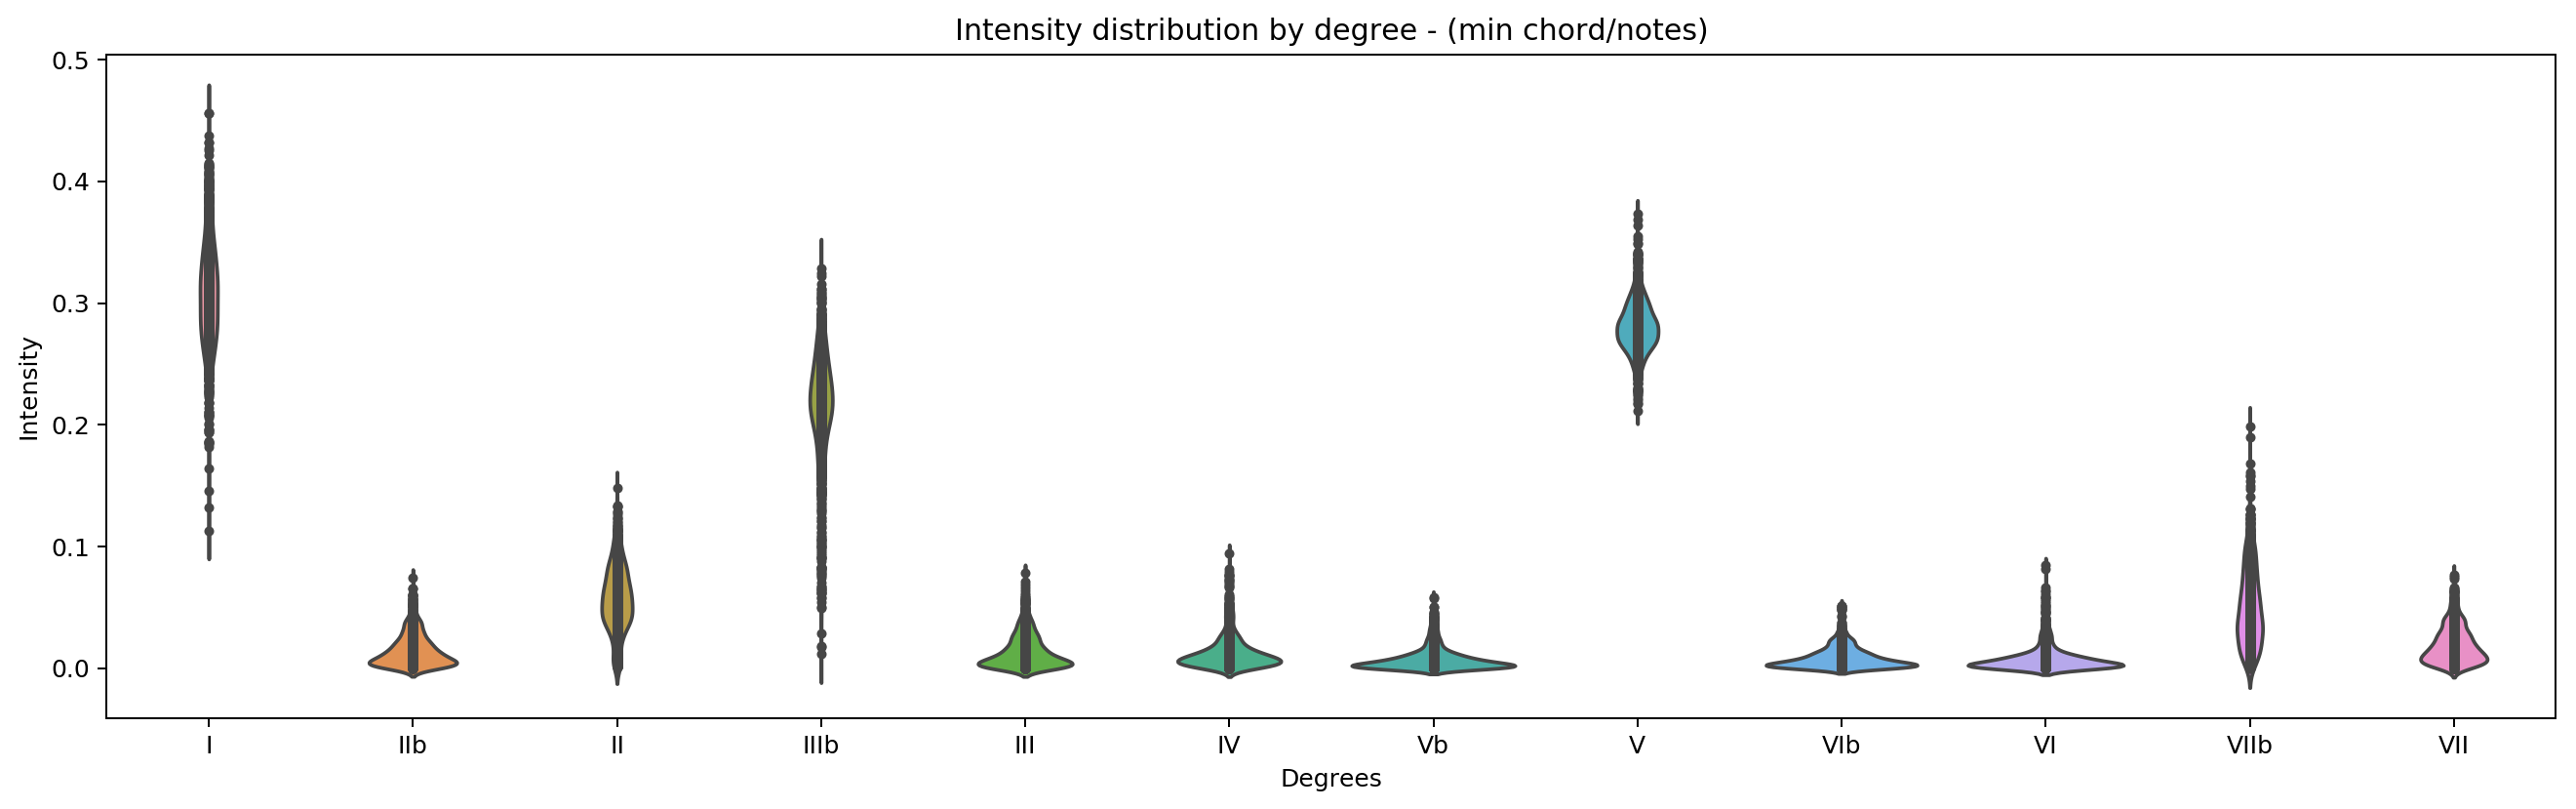

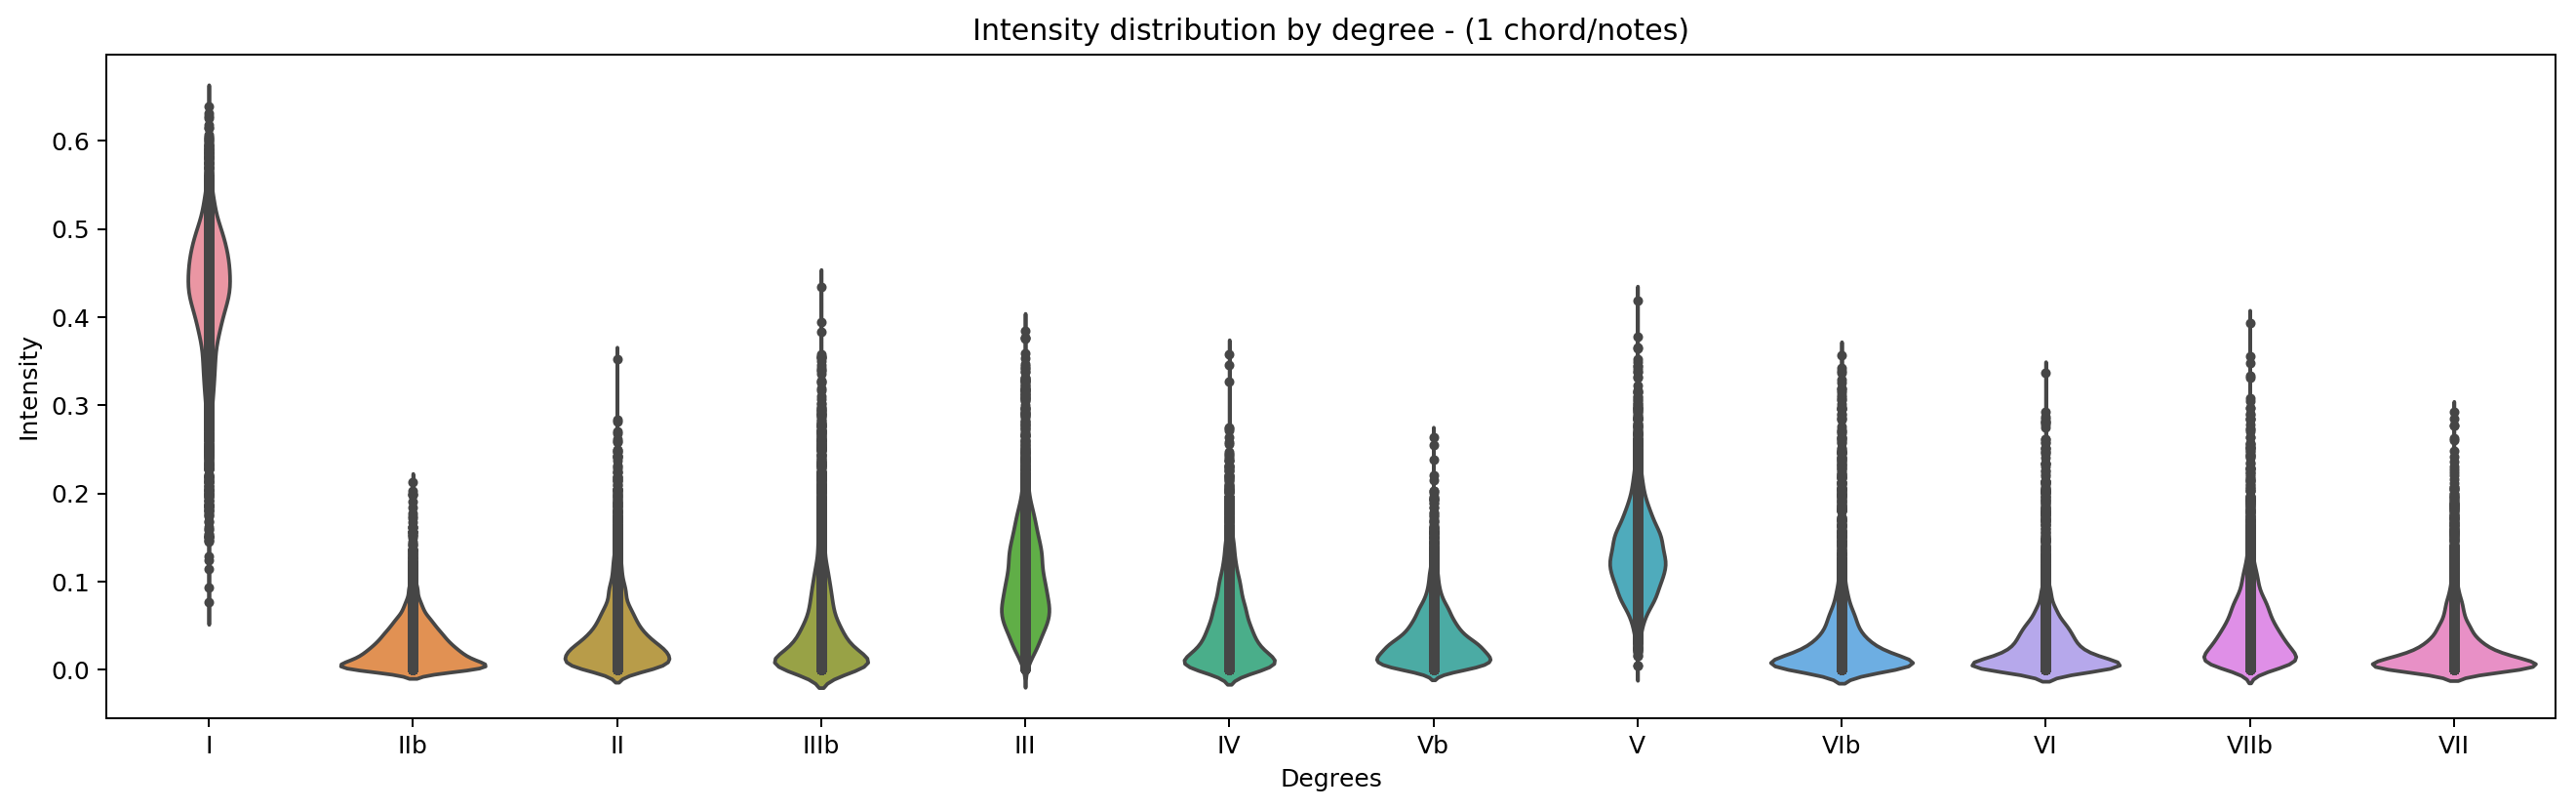

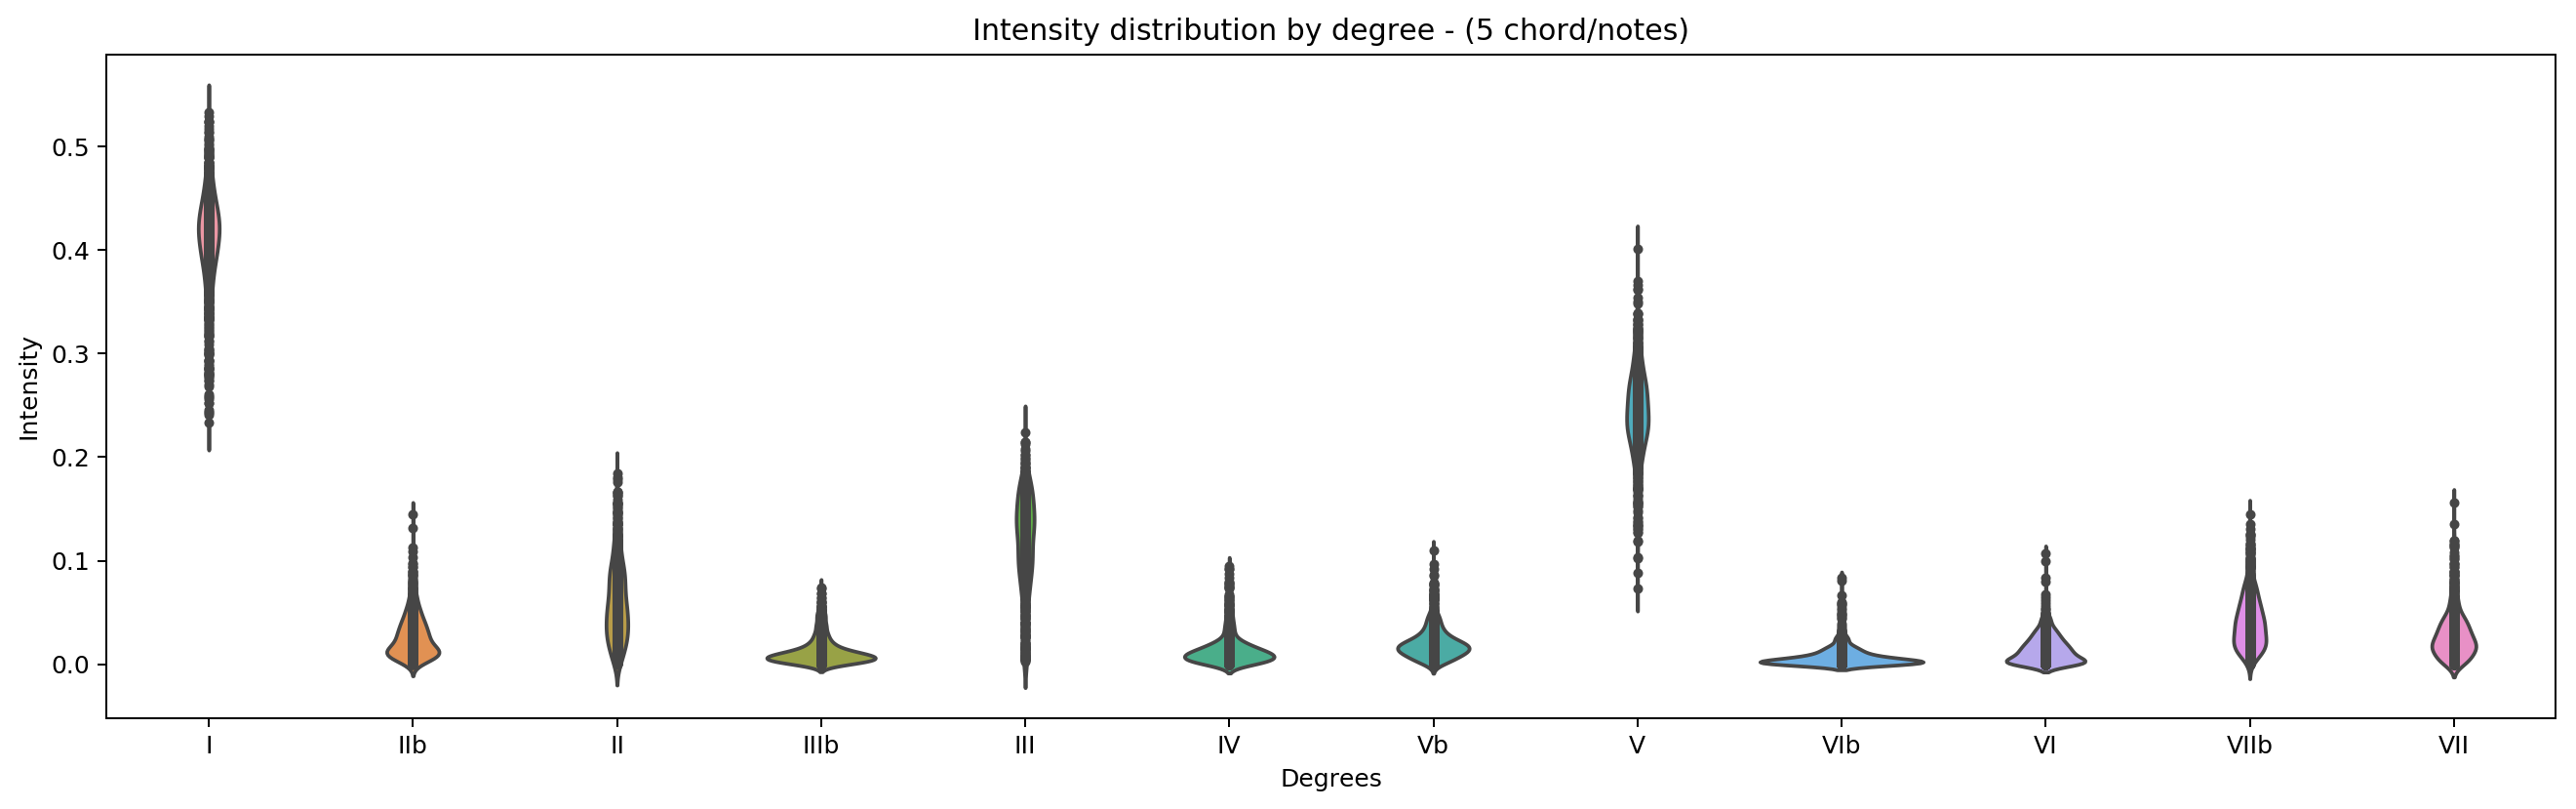

In [53]:
for kind in kinds:

    vis = CHORDS_NOTES_VISUALIZATION(test_segments,kind=kind ,normalize_to_C = True)
    print('Test')
#     vis.plot_all()
    vis.intensity_distribution_by_degree()

# TRAIN MODEL 
(Uncomment the model you want to use)

In [25]:
model_name = 'Train_large_amount_data'
model_path = '../MODELS/cross-validation/Fold_tests/'

In [1]:
model_name = 'Baseline_Case_Thirds'
model_path = '../MODELS/cross-validation/Baseline_Case_Thirds/'

Without minor chords

In [141]:
# m = NewModel(
#         {'maj': ['I', 'III', 'V'], '5': ['I', 'V'], '1': ['I', 'V', 'III']},

#         {'maj': {'n_components': 1, 'covariance_type': 'full', 'max_iter': 200},
#          '5': {'n_components': 1, 'covariance_type': 'full', 'max_iter': 200},
#          '1': {'n_components': 1, 'covariance_type': 'full', 'max_iter': 200}})

Without power chords

In [142]:
# m = NewModel(
#         {'maj': ['I', 'III', 'V'], 'min': ['I', 'IIIb', 'V'], '1': ['I', 'V', 'III']},

#         {'maj': {'n_components': 1, 'covariance_type': 'full', 'max_iter': 200},
#          'min': {'n_components': 1, 'covariance_type': 'full', 'max_iter': 200},
#          '1': {'n_components': 1, 'covariance_type': 'full', 'max_iter': 200}})

Wihtout third intervals

In [38]:
m = NewModel(
        {'maj': ['I', 'III', 'V'], 'min': ['I', 'IIIb', 'V'], '5': ['I', 'V'], '1': ['I', 'V', 'III']},

        {'maj': {'n_components': 1, 'covariance_type': 'full', 'max_iter': 200},
         'min': {'n_components': 1, 'covariance_type': 'full', 'max_iter': 200},
         '5': {'n_components': 1, 'covariance_type': 'full', 'max_iter': 200},
         '1': {'n_components': 1, 'covariance_type': 'full', 'max_iter': 200}})

Considering third intervals

In [24]:
# m = NewModel(
#         {'maj': ['I', 'III', 'V'], 'min': ['I', 'IIIb', 'V'], '5': ['I', 'V'], '1': ['I', 'V', 'III'],
#          '+3': ['I', 'III'], '-3': ['I','IIIb']},

#         {'maj': {'n_components': 1, 'covariance_type': 'full', 'max_iter': 200},
#          'min': {'n_components': 1, 'covariance_type': 'full', 'max_iter': 200},
#          '5': {'n_components': 1, 'covariance_type': 'full', 'max_iter': 200},
#          '1': {'n_components': 1, 'covariance_type': 'full', 'max_iter': 200},
#          '+3': {'n_components': 1, 'covariance_type': 'full', 'max_iter': 200},
#          '-3': {'n_components': 1, 'covariance_type': 'full', 'max_iter': 200}})

In [39]:
m.kinds

['maj', 'min', '5', '1']

In [40]:
m.fit(train_segments)
m.save_model(model_path  + model_name + '.pkl')

Now training:  maj
Now training:  min
Now training:  5
Now training:  1


### Visualize model

In [41]:
plt.rcParams.update({'font.size': 10})

0


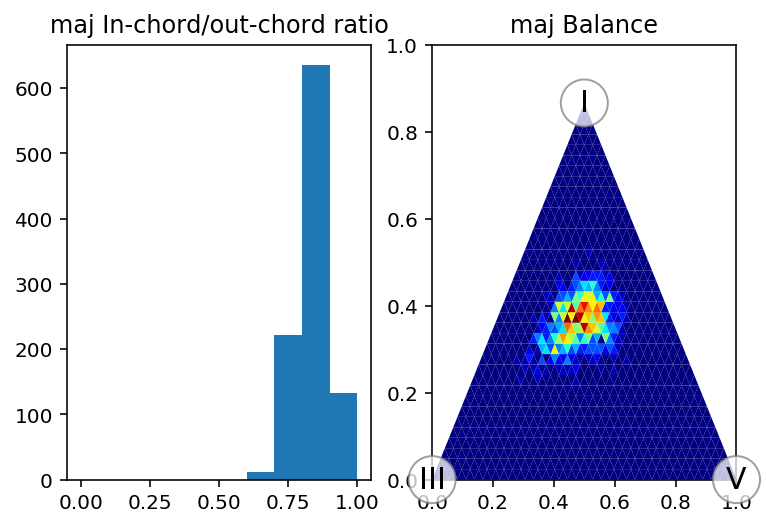

1


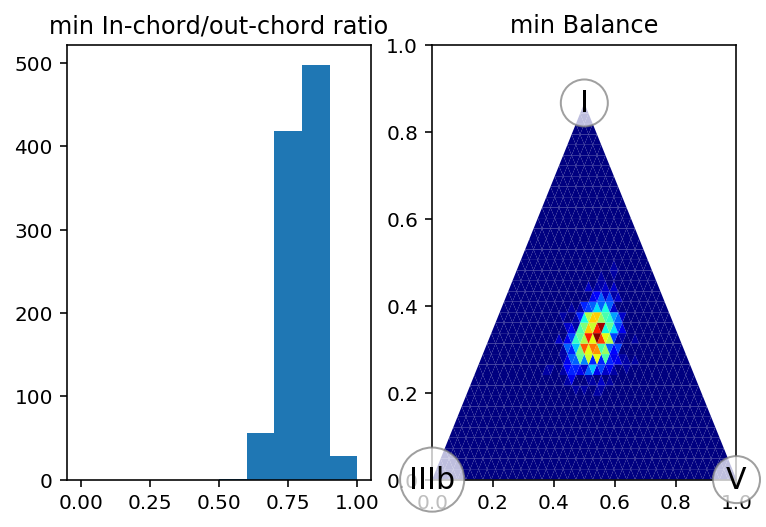

2


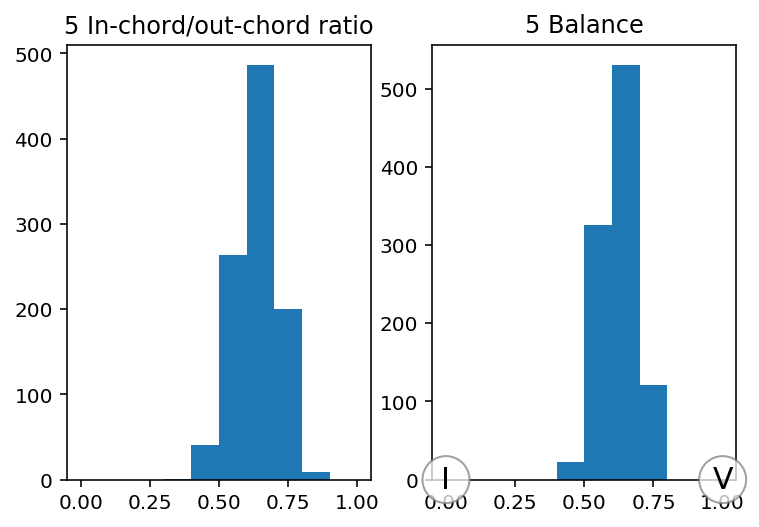

3


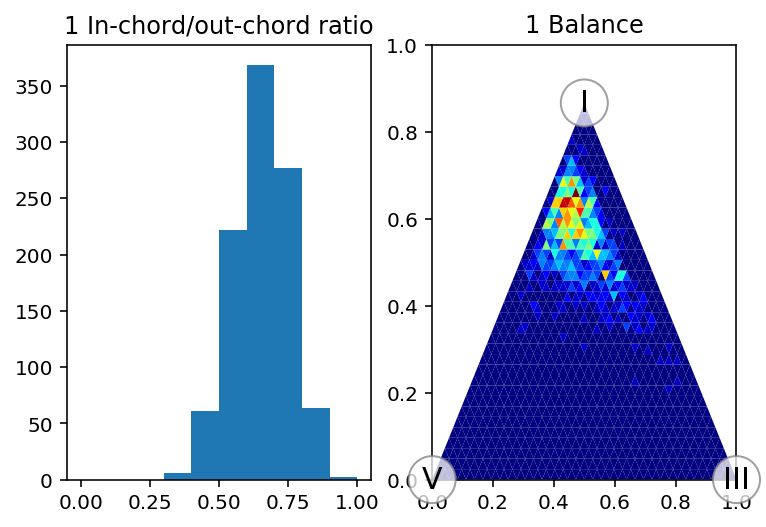

In [26]:
m = joblib.load(model_path + model_name + '.pkl')
for k in range(len(m.kinds)):
    print(k)
    visualize(m, k)

# Evaluation

In [27]:
model_name

'Train_large_amount_data'

In [29]:
m = joblib.load(model_path + model_name + '.pkl')

pred = m.predict(test_segments.chromas)
pred = [str(p) for p in pred[0]]

test_segments.labels = [x.replace('(','') for x in test_segments.labels]
test_segments.labels = [x.replace(')','') for x in test_segments.labels]

for i,p in enumerate(test_segments.labels):
    if '1,3' in p:
        test_segments.labels[i] = test_segments.labels[i].replace('1,3','+3')
    elif '1,b3' in p:
        test_segments.labels[i] = test_segments.labels[i].replace('1,b3','-3')
    else:
        pass
    
    if 'maj' in test_segments.kinds[i]:
        if ':maj' not in test_segments.labels[i]:
            test_segments.labels[i] = test_segments.labels[i]+':maj'

In [30]:
plt.rcParams.update({'font.size': 10})

# OVERALL METRICS

In [31]:
# test_audios

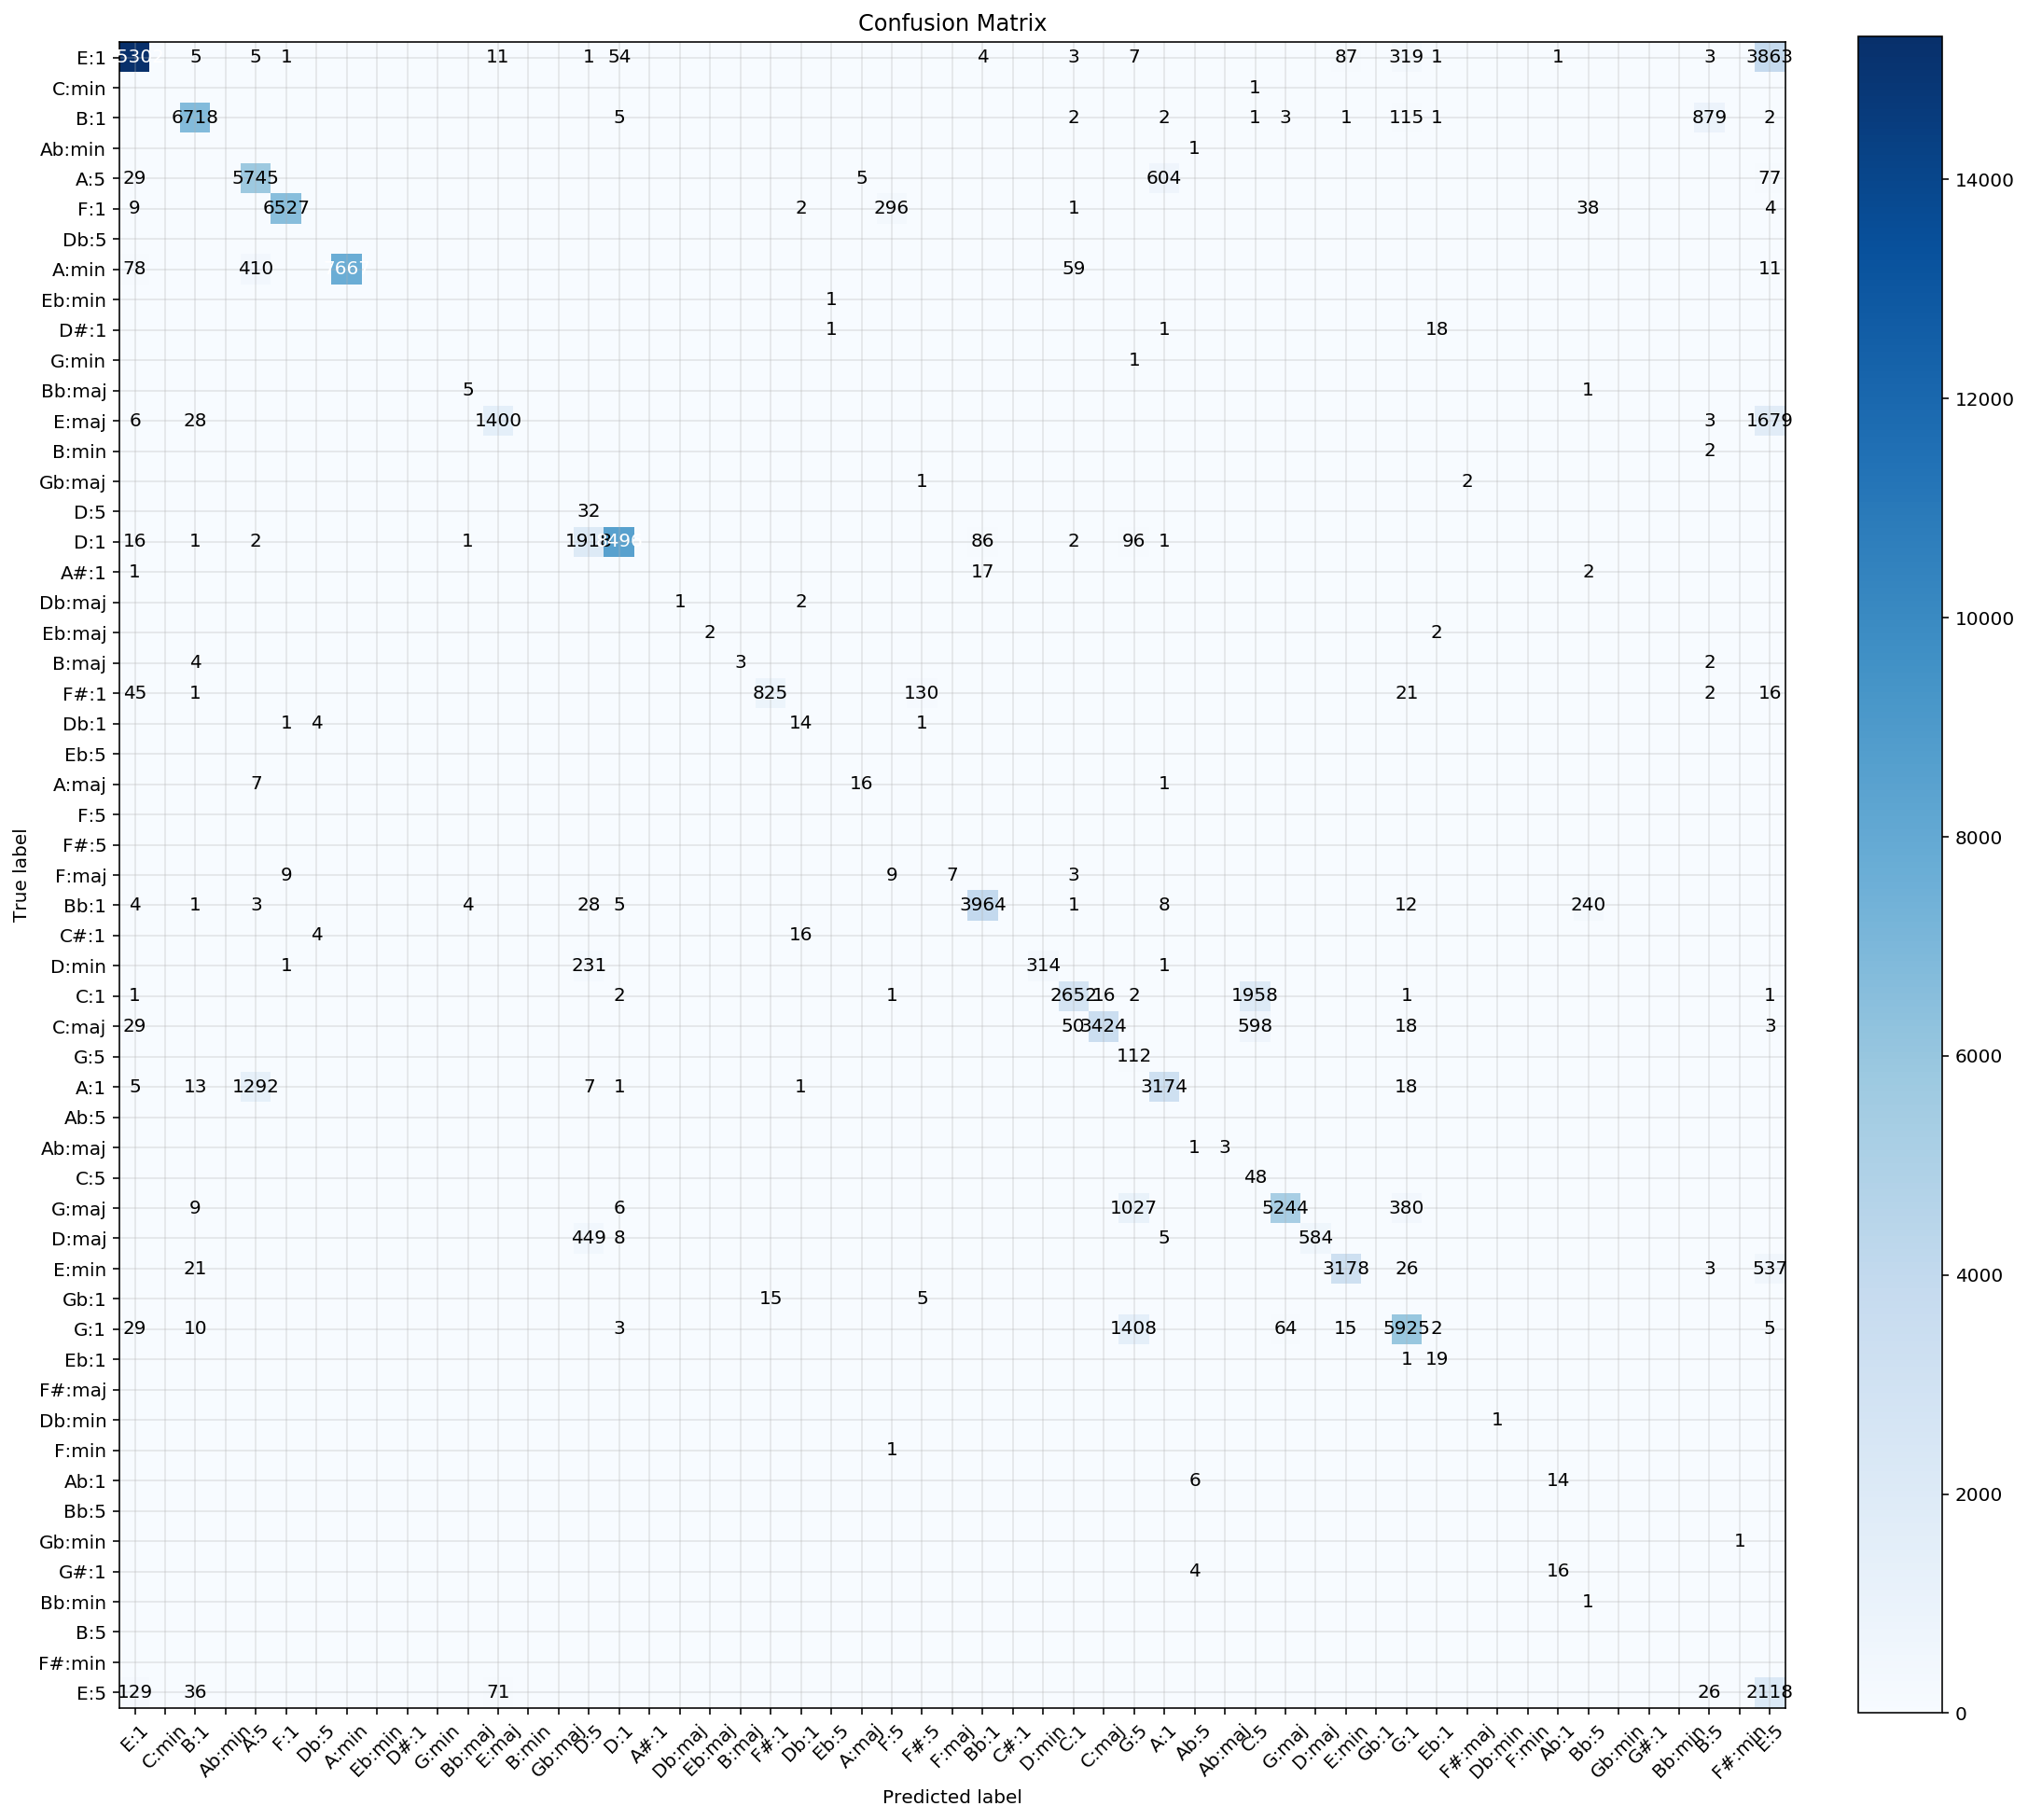

In [35]:
# pitch class set metrics
OM = Overall_Metrics(test_segments.labels , pred)

OM.accuracy()

cm  =OM.conf_matrix()

/home/eduard/anaconda3/envs/simmusic/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


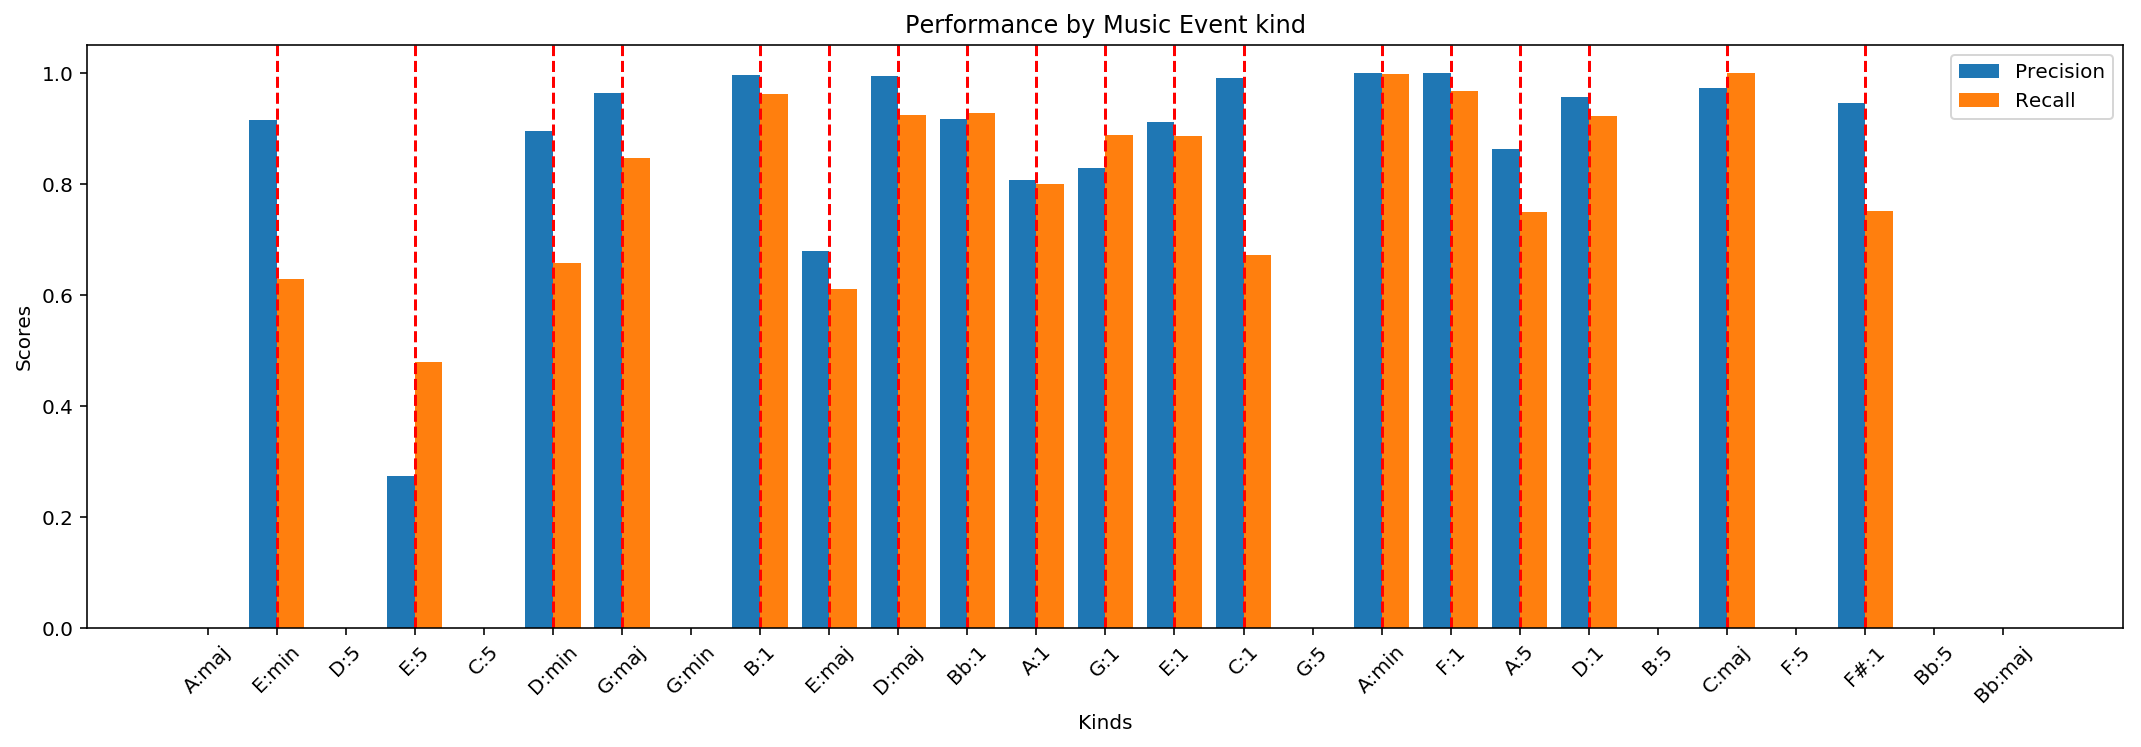

In [83]:
OM.per_class_performance()

# Music event kind metrics

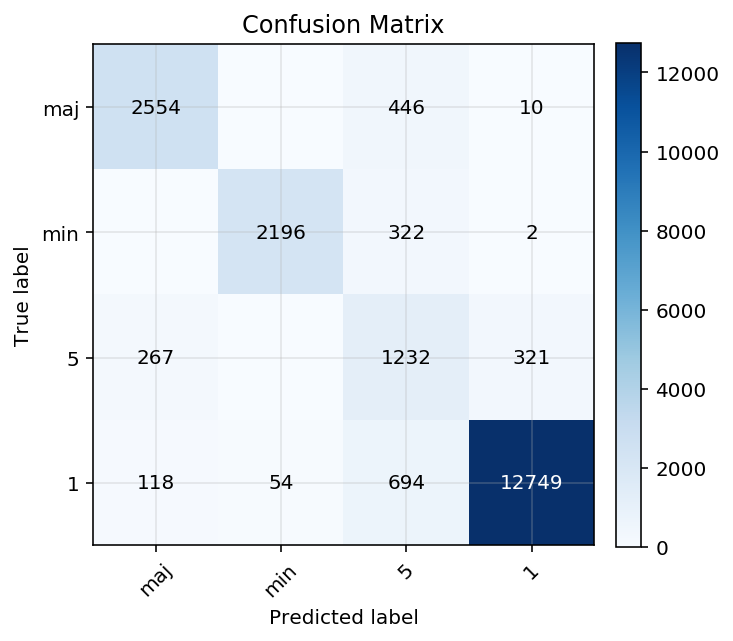

In [86]:
KM = Kind_Metrics(test_segments.kinds,pred, labels = ['maj','min','5','1'])

KM.accuracy()

cm = KM.conf_matrix()

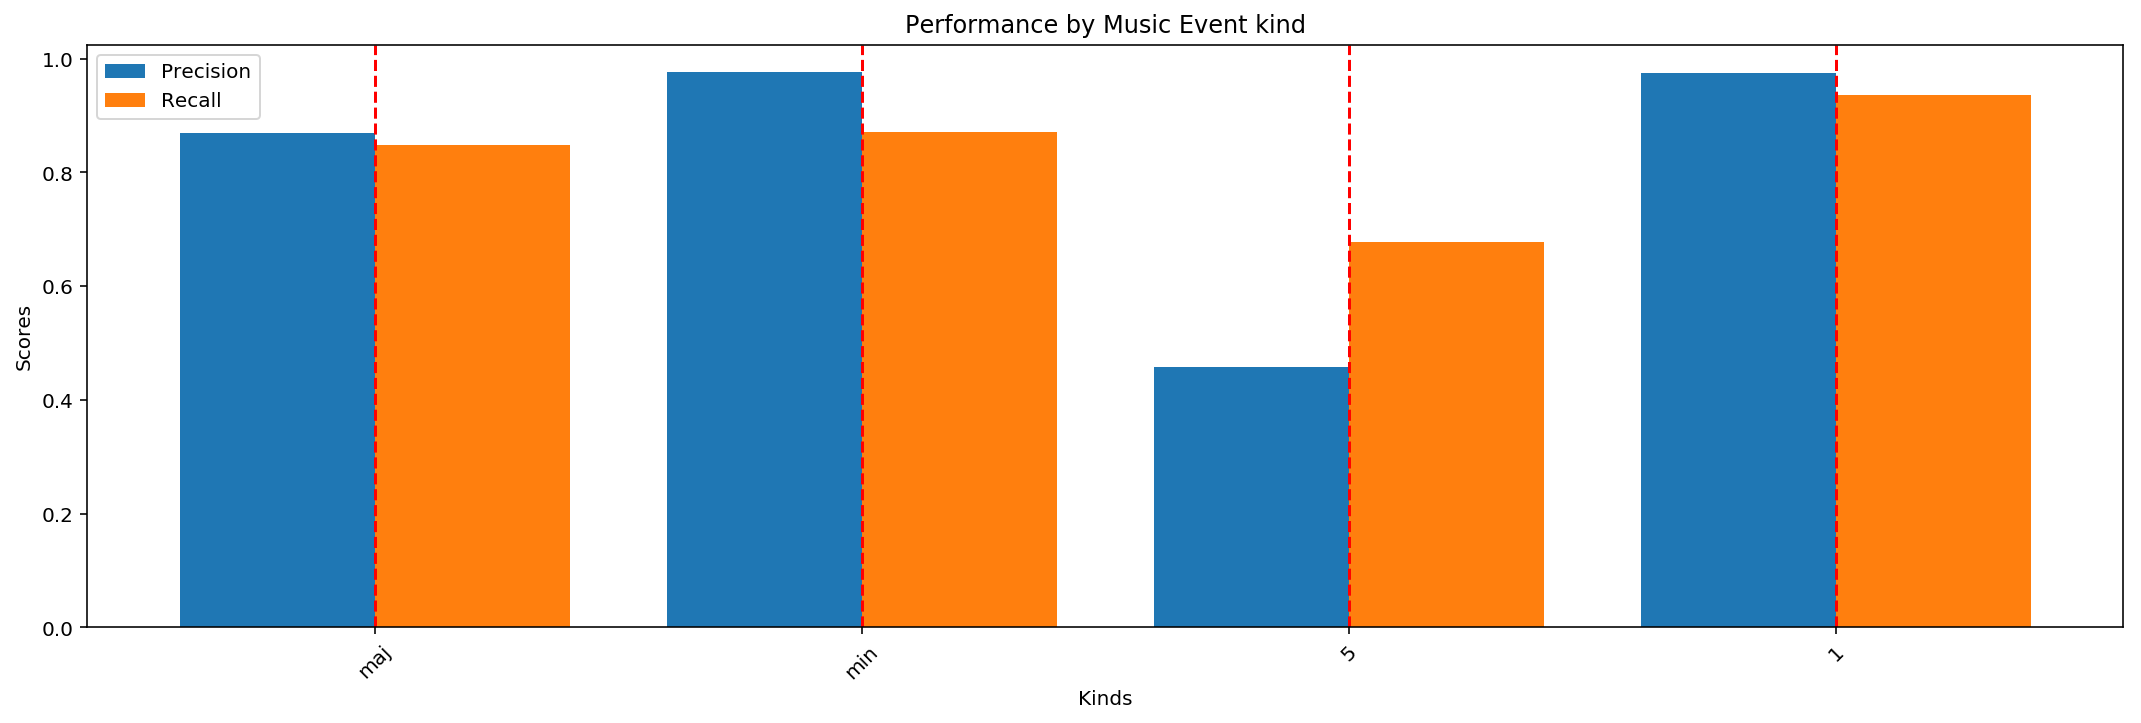

(array([0.86900306, 0.976     , 0.45731255, 0.97454518]),
 array([0.84850498, 0.87142857, 0.67692308, 0.93639368]))

In [87]:
KM.per_kind_performance()

# Test by property (source of recording, effect, filter ...)


In [40]:
np.std([0.8263,0.8593, 0.9089 ,0.8877,0.8779 ] )

0.02790228664464618

In [37]:
np.std([0.8325,0.7946,0.8017,0.8343,0.7503 ])

0.030656053235861947

In [88]:
result = accuracy_by_source(test_segments,pred, test_audios)

In [89]:
result.std(axis = 0).mean()

0.10196641751441894

In [90]:
result.mean(axis =0)

DI           0.850957
Lpass250     0.848820
Hpass3000    0.865057
Hpass1000    0.867953
Lpass500     0.852333
Hpass500     0.863173
Lpass100     0.841697
dtype: float64

In [91]:
max(result.mean(axis =0).values)

0.8679533333333336

In [92]:
result

,DI,Lpass250,Hpass3000,Hpass1000,Lpass500,Hpass500,Lpass100,Song,Performance
Lily_Telecaster_108,0.7407,0.7407,0.8148,0.7778,0.7407,0.7593,0.7407,Lily,Lily_Telecaster
Century_Larrivee_130,0.5641,0.5641,0.5385,0.5641,0.5812,0.5812,0.5726,Century,Century_Larrivee
Lily_Larrivee_108,0.7963,0.8333,0.7778,0.8333,0.8333,0.8704,0.7963,Lily,Lily_Larrivee
Mountain_Eastman_104,0.9509,0.9325,0.9571,0.9509,0.9387,0.9571,0.9325,Mountain,Mountain_Eastman
Lily_Ibanez_108,0.8148,0.8148,0.8519,0.8333,0.8148,0.7963,0.8148,Lily,Lily_Ibanez
Century_Telecaster_130,0.7521,0.7521,0.7692,0.7778,0.7521,0.7607,0.7692,Century,Century_Telecaster
Where_Larrivee_100,0.7590,0.7711,0.7952,0.7952,0.7711,0.8193,0.7590,Where,Where_Larrivee
Hole_Larrivee_102,0.9882,0.9765,0.8471,0.9412,0.9882,0.9882,0.9765,Hole,Hole_Larrivee
Train_Epiphone_112,0.7938,0.7835,0.8557,0.8454,0.7938,0.8144,0.7835,Train,Train_Epiphone
Train_Eastman_112,0.7216,0.7010,0.7732,0.7423,0.7010,0.7216,0.6804,Train,Train_Eastman


In [93]:
cols = [c  for c in result.columns if (c != 'Song') and (c!='Performance')]

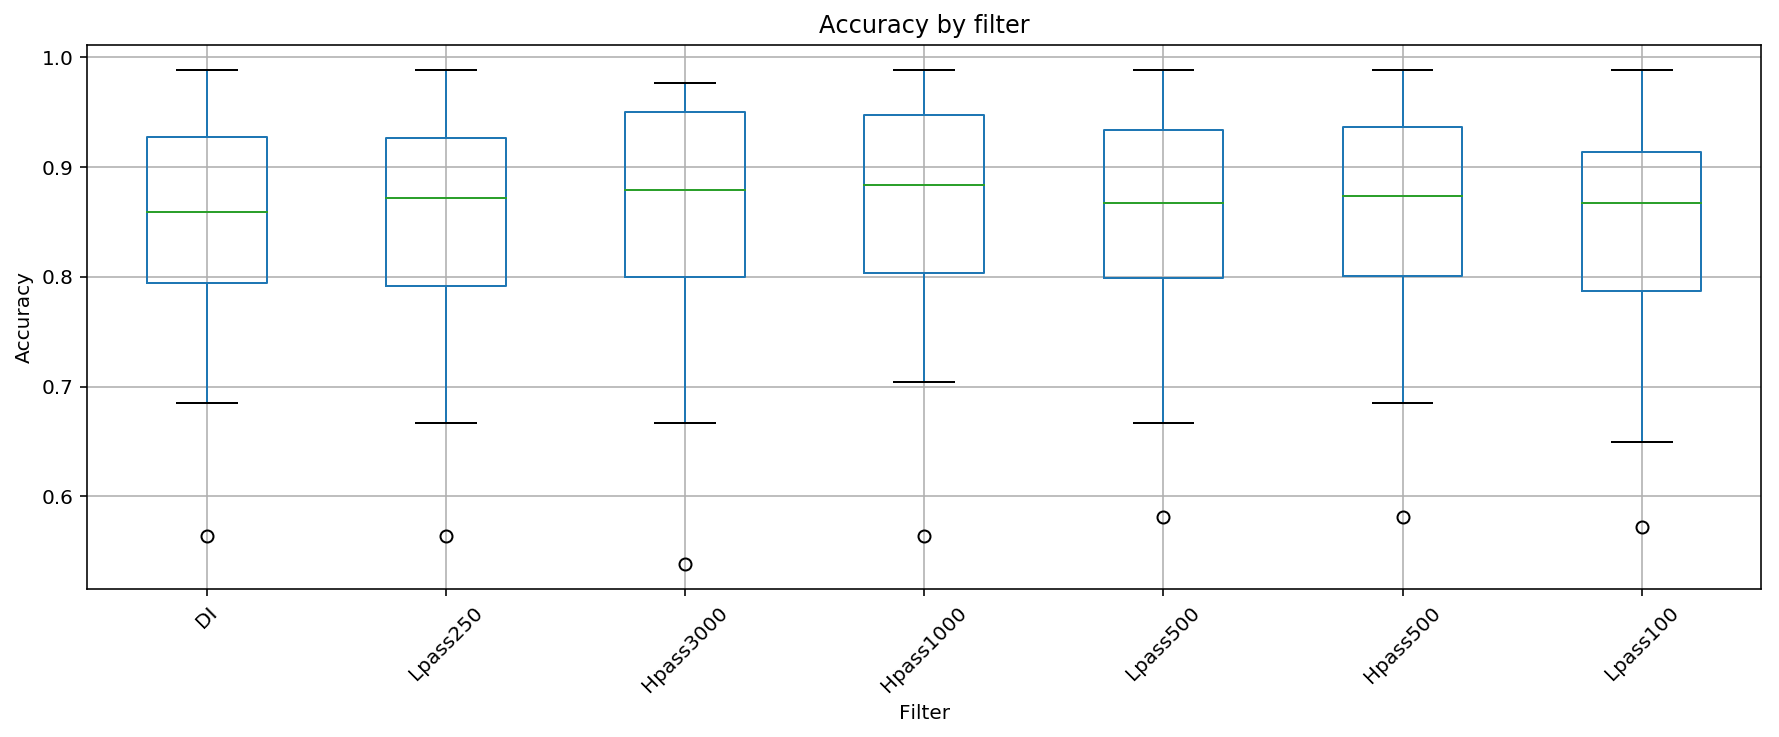

In [94]:

result.boxplot(column=cols,fontsize='medium',rot=45,figsize = (15,5))
plt.title('Accuracy by filter')
plt.xlabel('Filter')
plt.ylabel('Accuracy')
plt.show()

In [95]:
for col in cols:
    Q1 =  result[col].quantile(0.25)
    Q3 = result[col].quantile(0.75)
    IQR = Q3 - Q1
    
    
    print('Outliers found for column {}: {}.'.format(col,result[(result[col] < Q1-1.5*IQR ) | (result[col] > Q3+1.5*IQR)]['Performance']))


Outliers found for column DI: Century_Larrivee_130    Century_Larrivee
Name: Performance, dtype: object.
Outliers found for column Lpass250: Century_Larrivee_130    Century_Larrivee
Name: Performance, dtype: object.
Outliers found for column Hpass3000: Century_Larrivee_130    Century_Larrivee
Name: Performance, dtype: object.
Outliers found for column Hpass1000: Century_Larrivee_130    Century_Larrivee
Name: Performance, dtype: object.
Outliers found for column Lpass500: Century_Larrivee_130    Century_Larrivee
Name: Performance, dtype: object.
Outliers found for column Hpass500: Century_Larrivee_130    Century_Larrivee
Name: Performance, dtype: object.
Outliers found for column Lpass100: Century_Larrivee_130    Century_Larrivee
Name: Performance, dtype: object.


In [96]:
plt.rcParams.update({'font.size': 10})

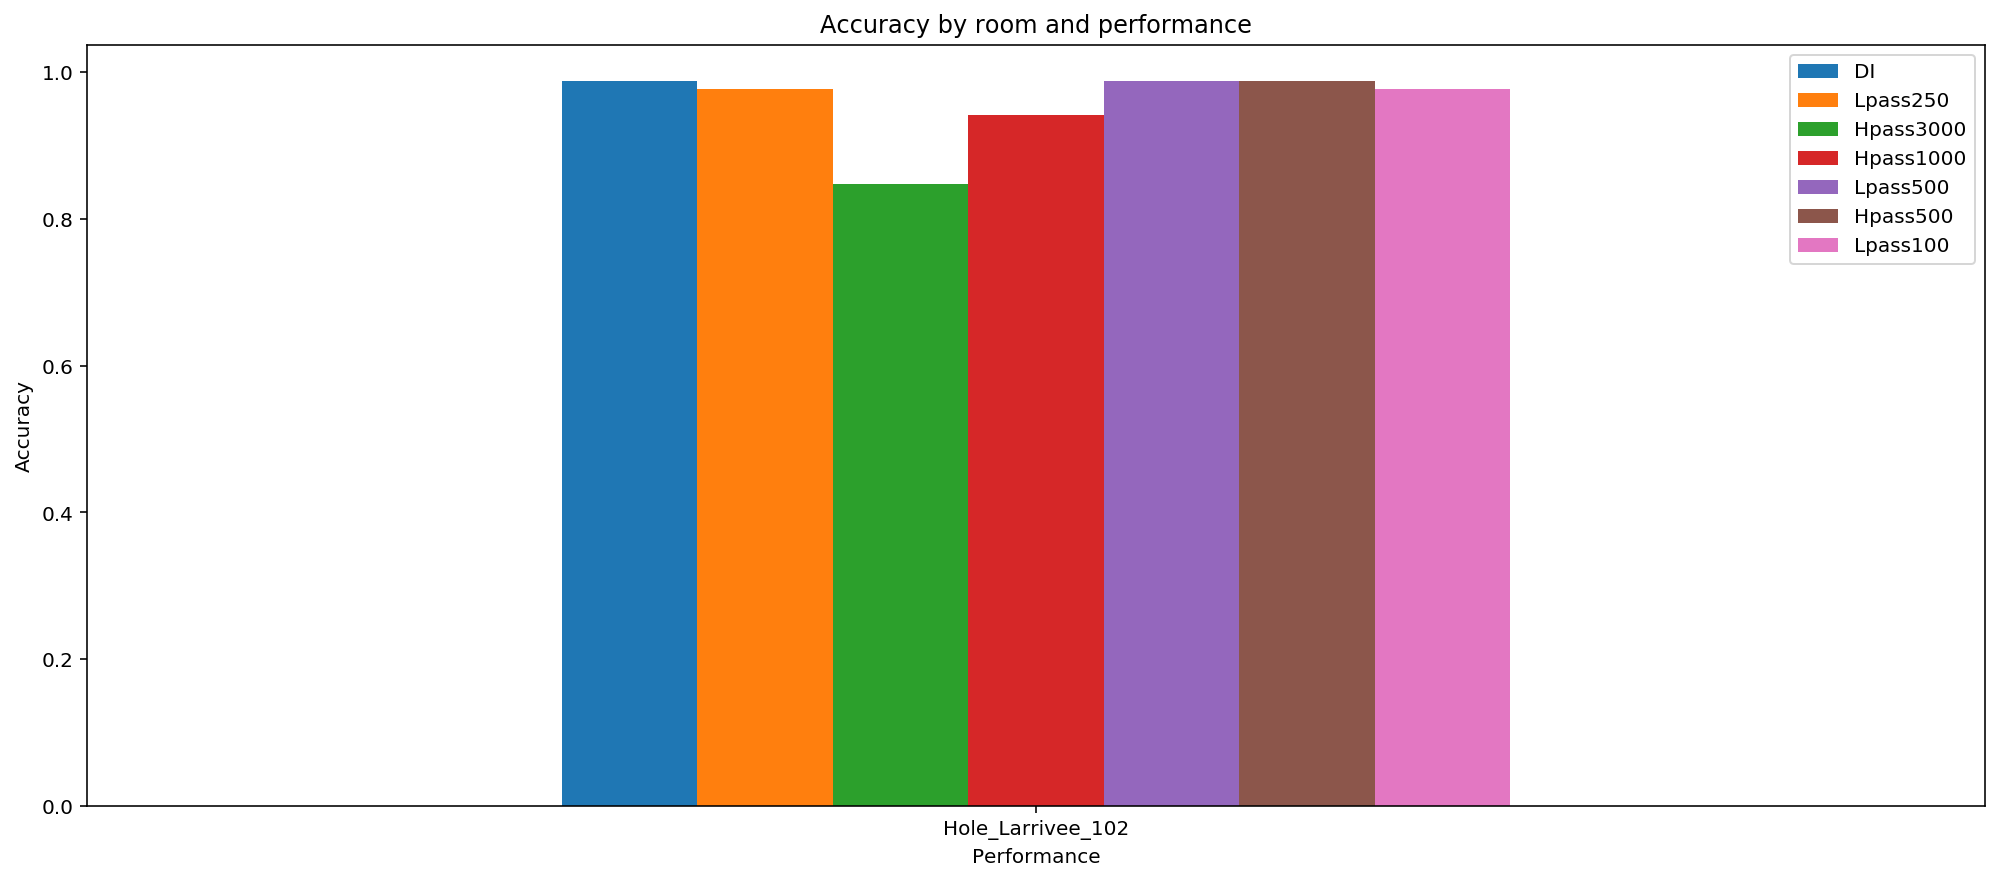

In [97]:
performances = ['Hole_Larrivee',]
result[result['Performance'].isin(performances)].plot.bar(fontsize='medium',rot=0,figsize = (17,7))

plt.title('Accuracy by room and performance')
plt.xlabel('Performance')
plt.ylabel('Accuracy')

plt.show()

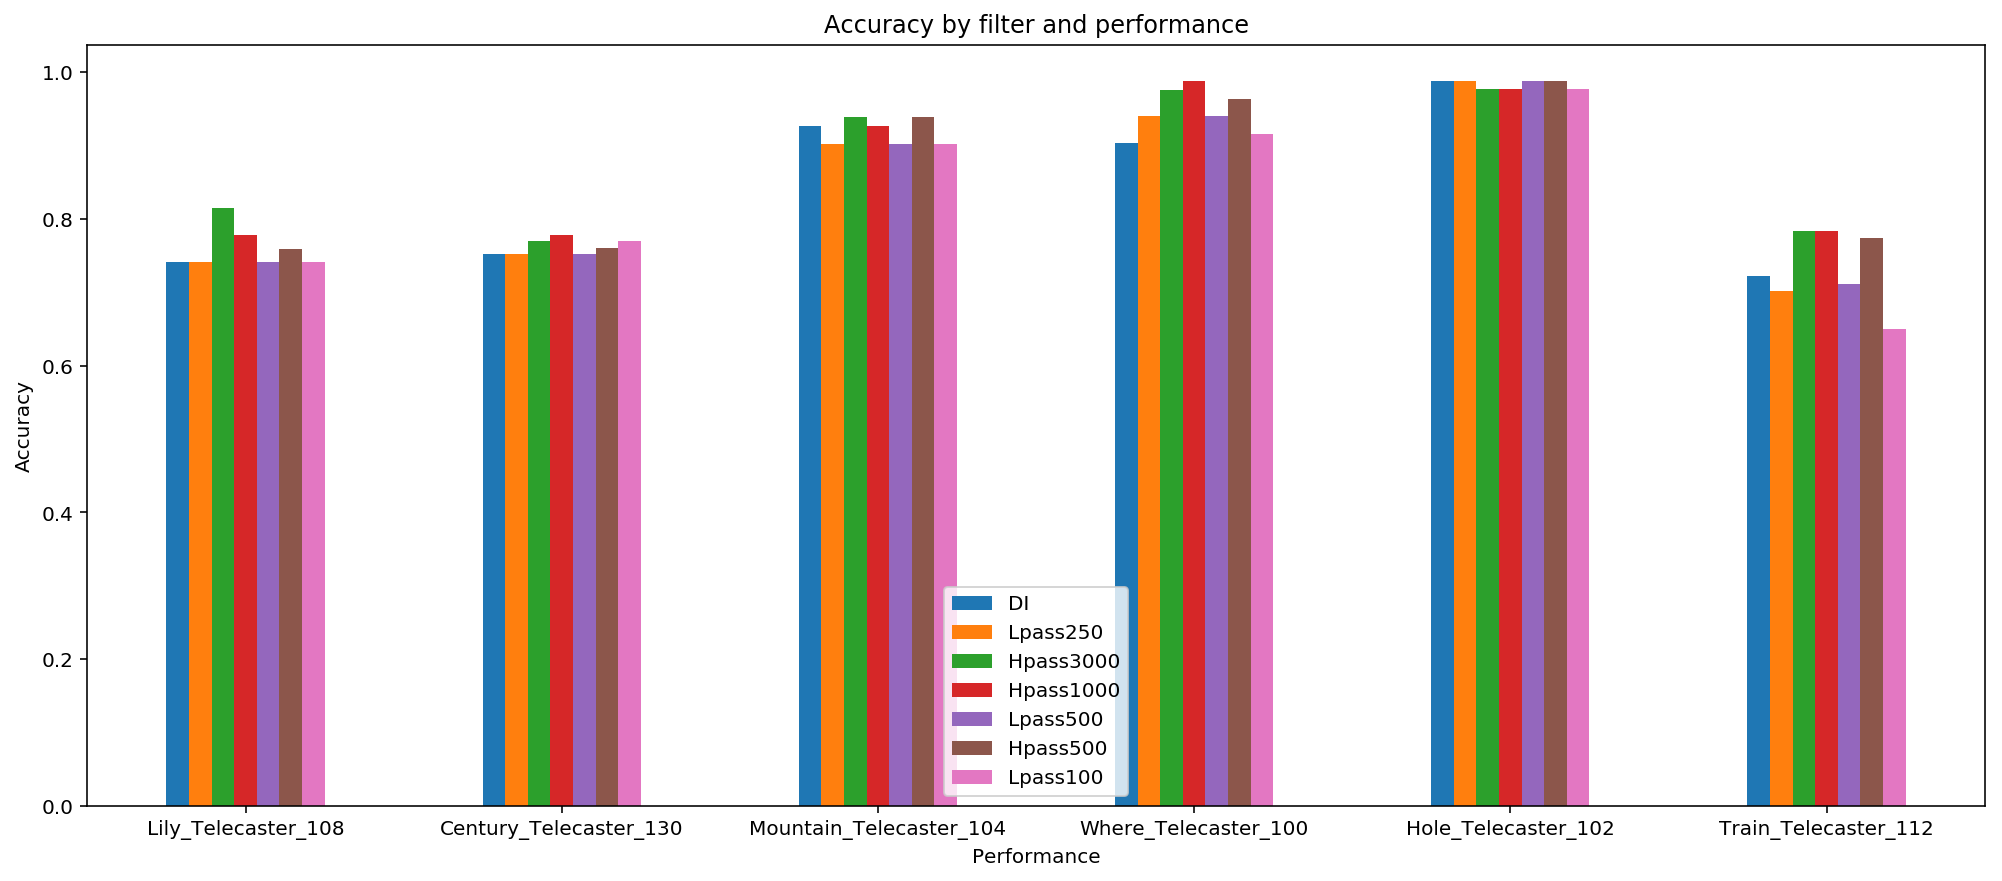

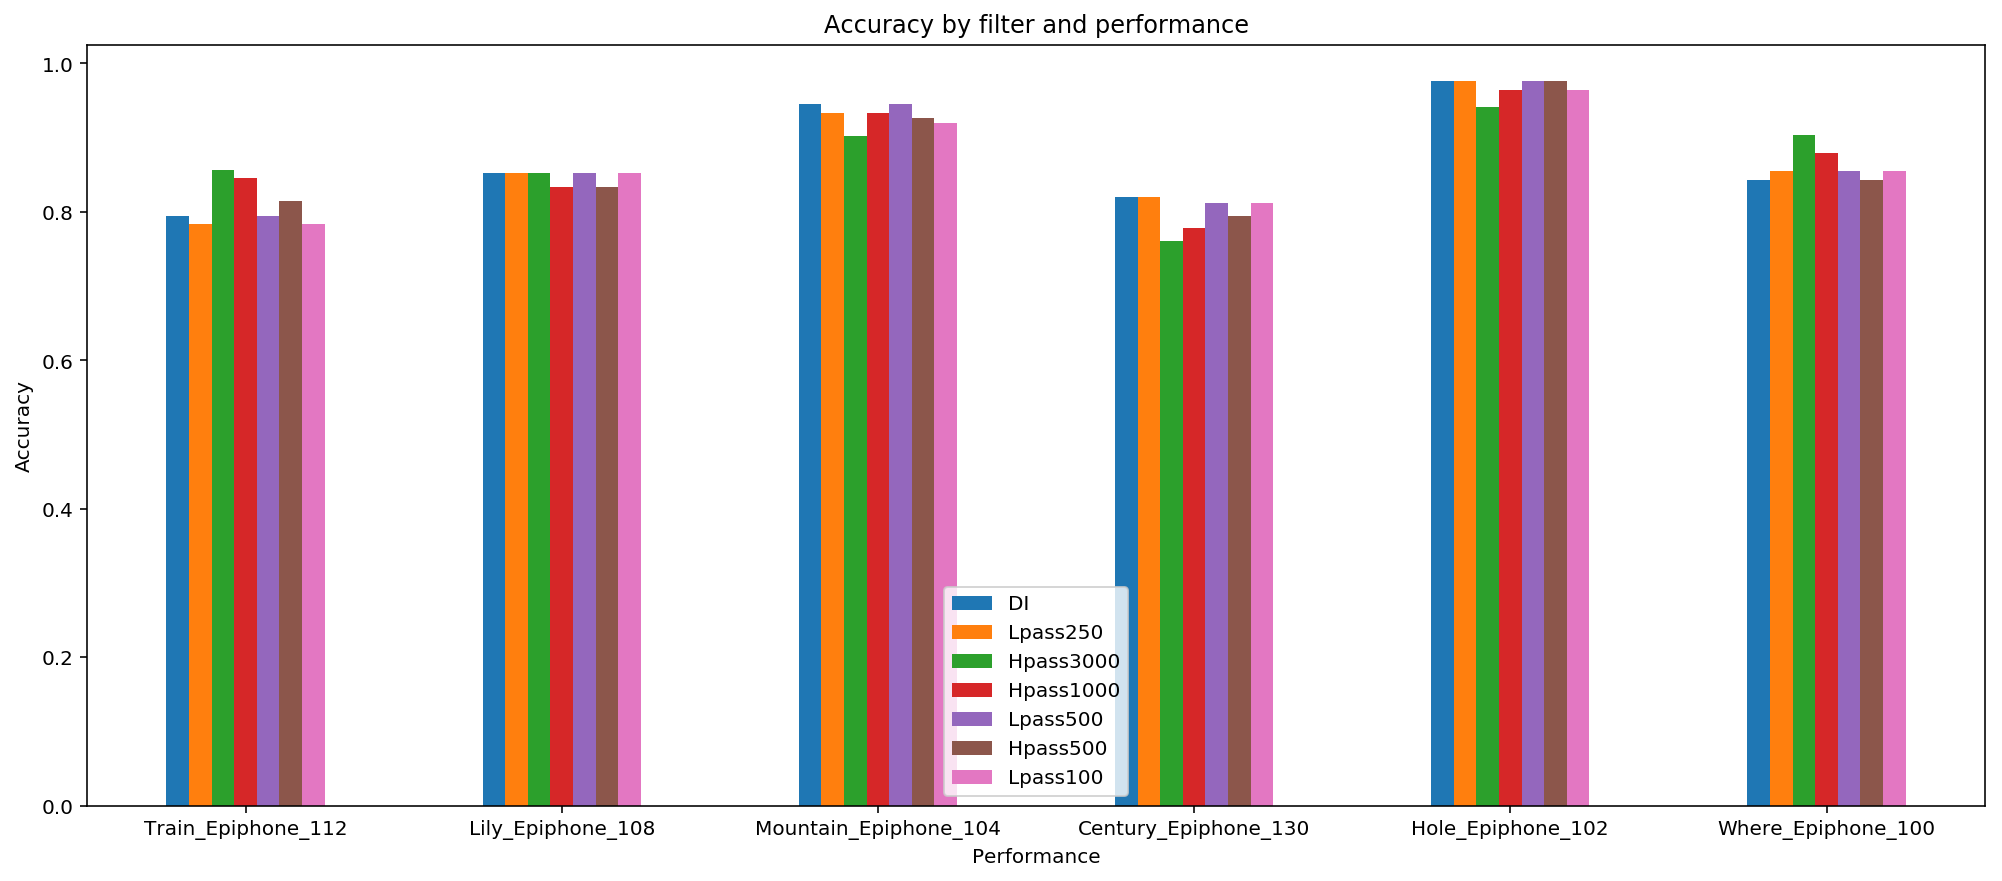

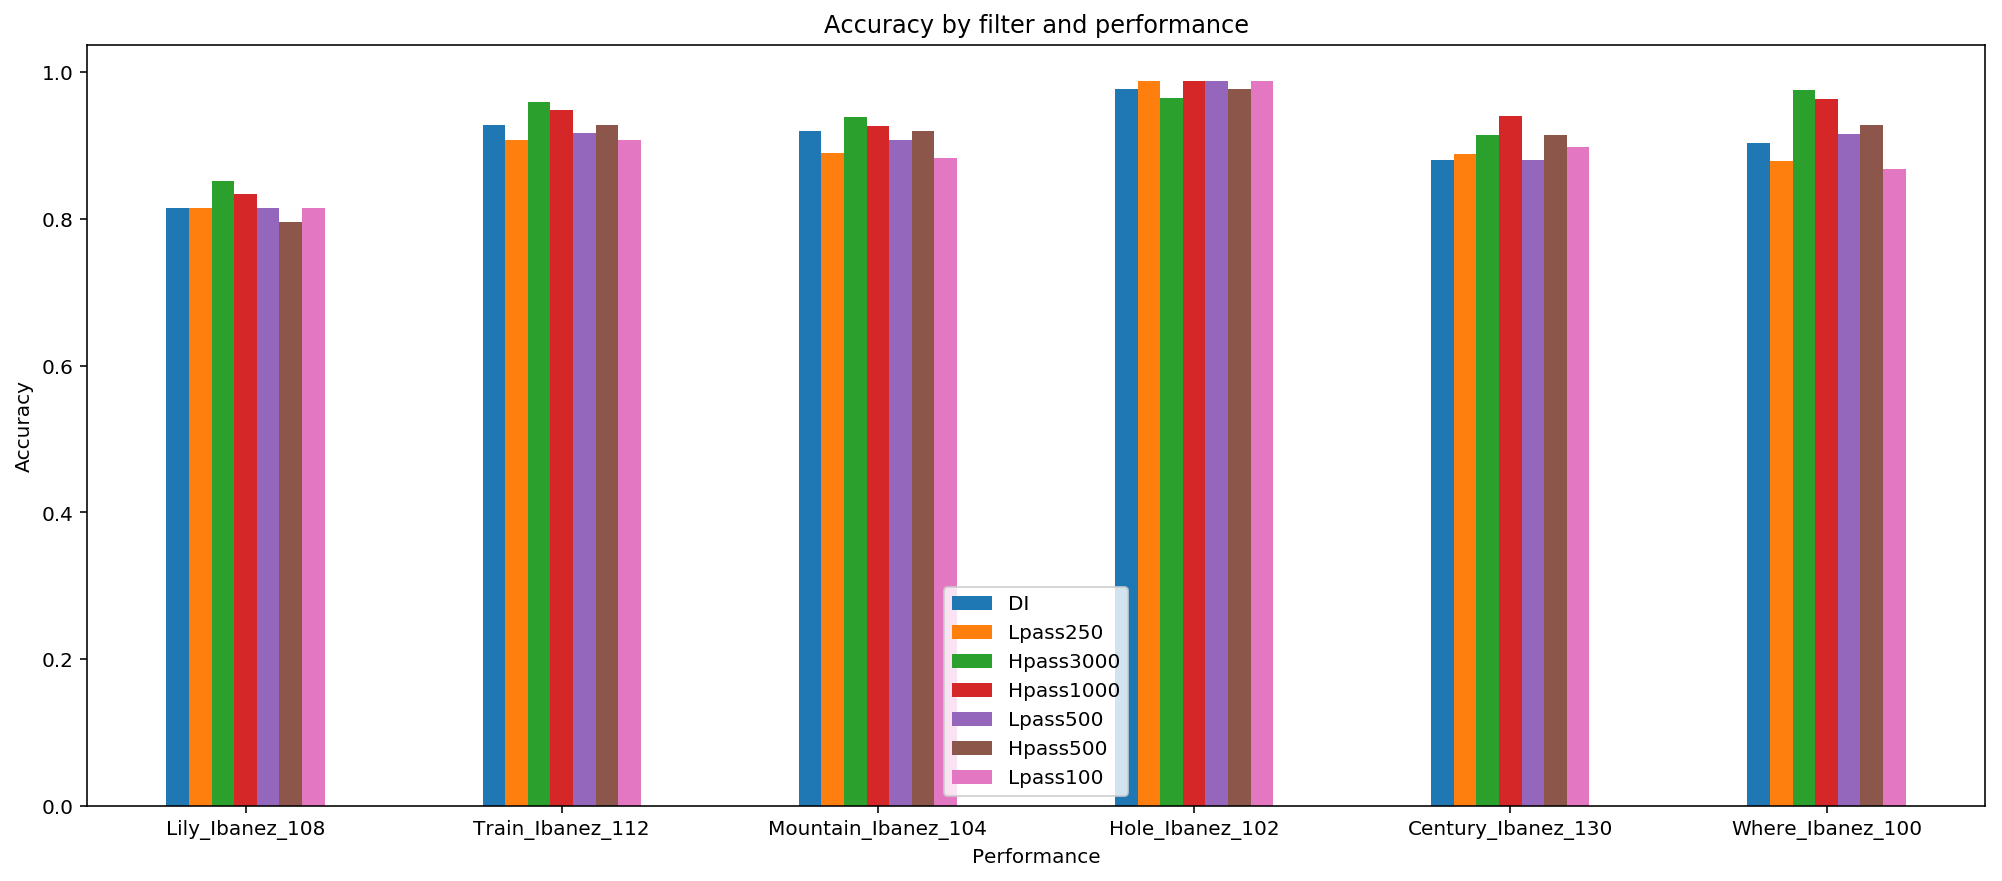

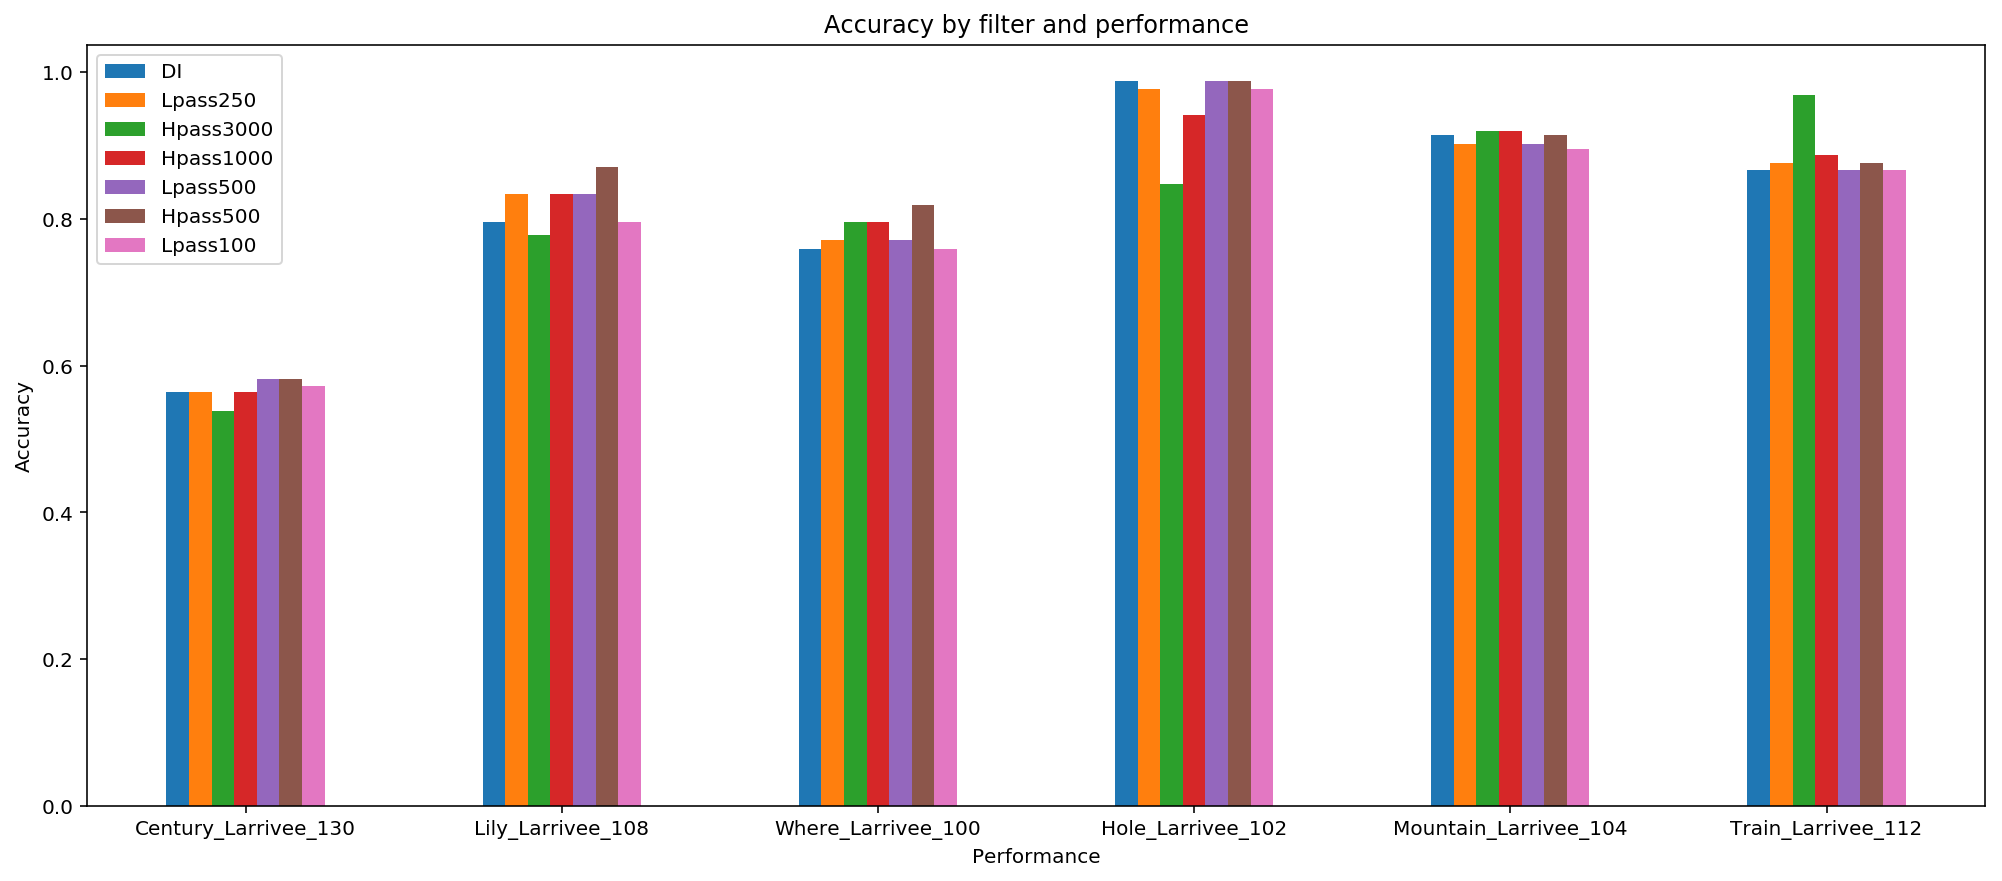

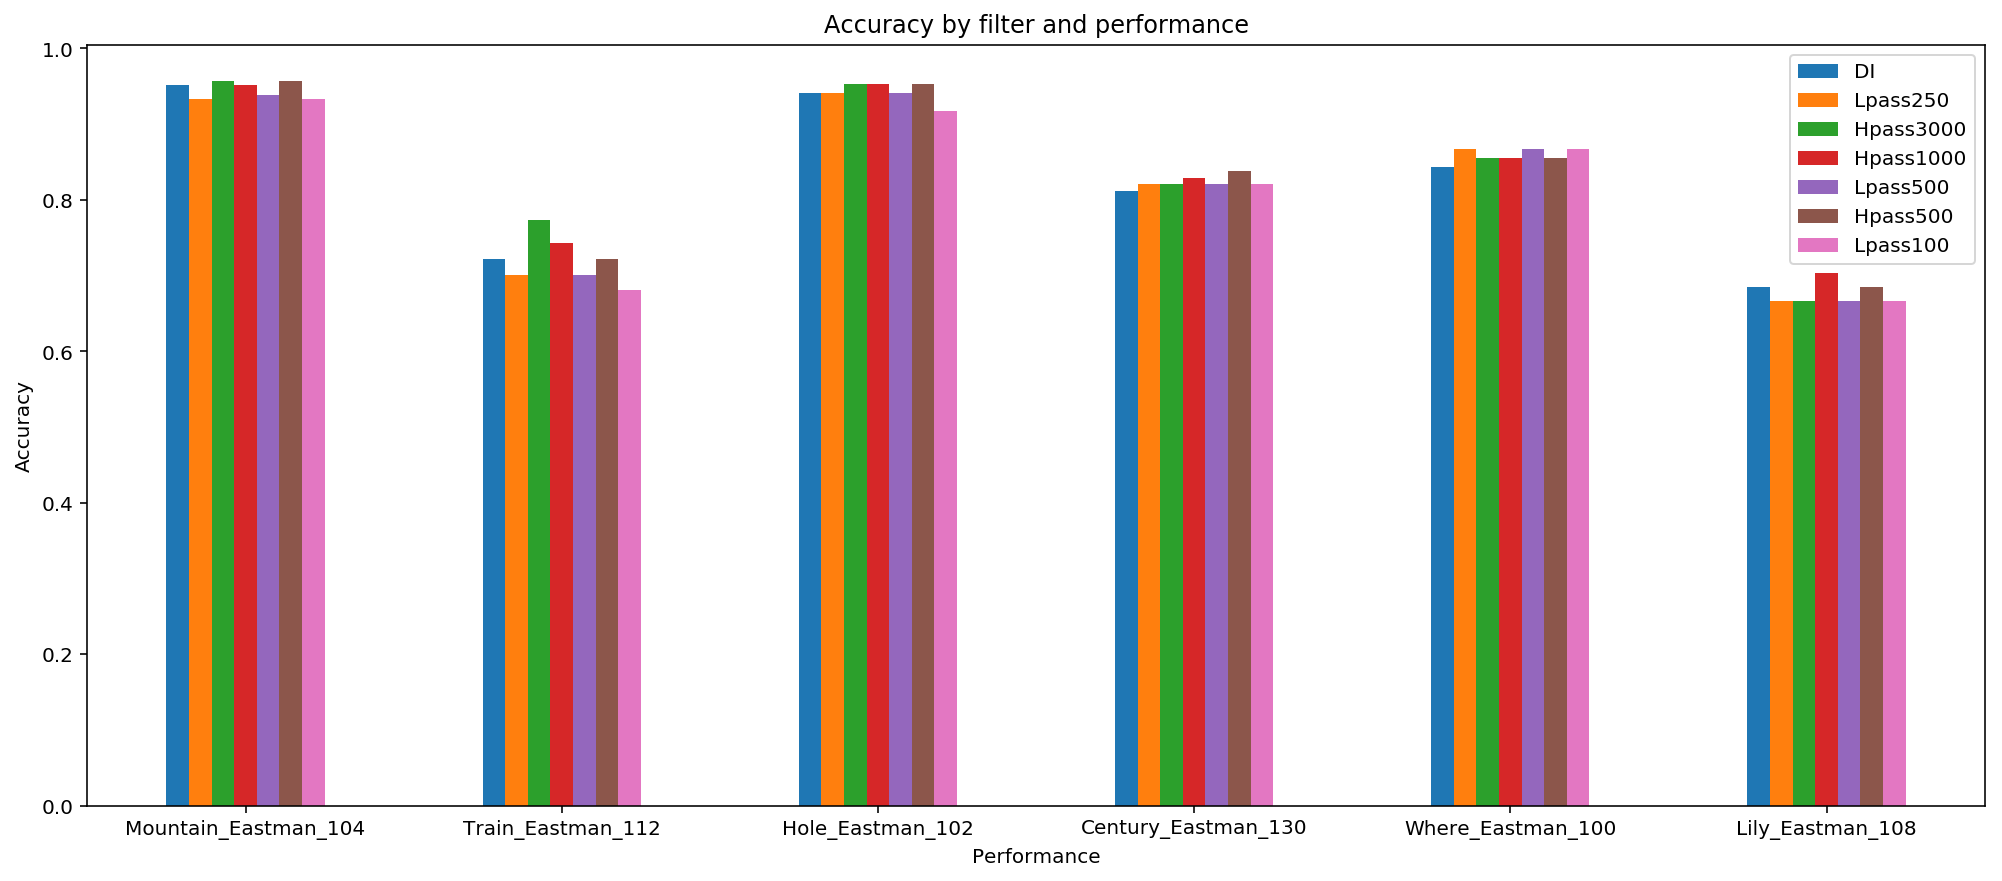

In [99]:
guitarres = ['Telecaster','Epiphone','Ibanez','Larrivee','Eastman']
for g in guitarres:
    performances = ['Century_'+g,'Lily_'+g,'Train_'+g,'Mountain_'+g,'Where_'+g,'Hole_'+g]
    result[result['Performance'].isin(performances)].plot.bar(fontsize='medium',rot=0,figsize = (17,7))

    plt.title('Accuracy by filter and performance')
    plt.xlabel('Performance')
    plt.ylabel('Accuracy')

    plt.show()

In [36]:
print(result[cols].to_latex(index=True,longtable=False)) 

\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
{} &      DI &  Mobile &  Computer &  SimComp &  SimRadio1 &  SimMobile1 &  SimVoiceRecorder &  SimRadio2 &  SimMobile2 &  TakStar &  Sennheiser &     AKG &   Shure \\
\midrule
Lily\_Telecaster\_108     &  0.7407 &  0.8333 &    0.8519 &   0.8519 &     0.7963 &      0.8704 &            0.7593 &     0.7593 &      0.7222 &   0.7407 &      0.7963 &  0.7778 &  0.7963 \\
Hole\_Epiphone\_102       &  0.9765 &  0.9882 &    0.9882 &   1.0000 &     0.9765 &      0.9882 &            0.9765 &     0.9765 &      0.9882 &   0.9765 &      0.9765 &  0.9765 &  0.9765 \\
Train\_Larrivee\_112      &  0.8660 &  0.8866 &    0.9485 &   0.9588 &     0.8557 &      0.8763 &            0.8763 &     0.8866 &      0.8866 &   0.8660 &      0.8660 &  0.8660 &  0.8866 \\
Lily\_Eastman\_108        &  0.6852 &  0.7037 &    0.7037 &   0.7037 &     0.6481 &      0.7222 &            0.8148 &     0.6481 &      0.5741 &   0.6667 &      0.7222 &  0.6667 &  0.6852 \\
Mountain\_Ibanez\_

# Check performance on individual recordings

In [85]:
import importlib
import test_pipeline_tools.METRICS as met
importlib.reload(met)
from test_pipeline_tools.METRICS import Individual_Metrics

from test_pipeline_tools.Segments_Loader import song_2_anno, ex_2_id
import glob

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})

In [89]:
# recordings = glob.glob('../Databases/Augmented_database/SOX_Filters/' + 'Train_Telecaster_*_Hpass3000.wav') + glob.glob('../Databases/Raw_database/' + 'Train_Telecaster_*_DI.wav')
recordings = glob.glob('../Databases/Augmented_database/SOX_Effects/' +'Century_Eastman*.wav')
model_path = '../MODELS/cross-validation/Baseline_Case/' + model_name + '.pkl'

In [87]:
model_path

'../MODELS/cross-validation/Baseline_Case/Baseline_Case.pkl'

In [90]:
recordings

['../Databases/Augmented_database/SOX_Effects/Century_Eastman_130_Flanger.wav',
 '../Databases/Augmented_database/SOX_Effects/Century_Eastman_130_Phaser.wav',
 '../Databases/Augmented_database/SOX_Effects/Century_Eastman_130_Chorus.wav',
 '../Databases/Augmented_database/SOX_Effects/Century_Eastman_130_OverDrive.wav']

In [91]:
plt.rcParams.update({'font.size':10})

../Databases/Augmented_database/SOX_Effects/Century_Eastman_130_Flanger.wav


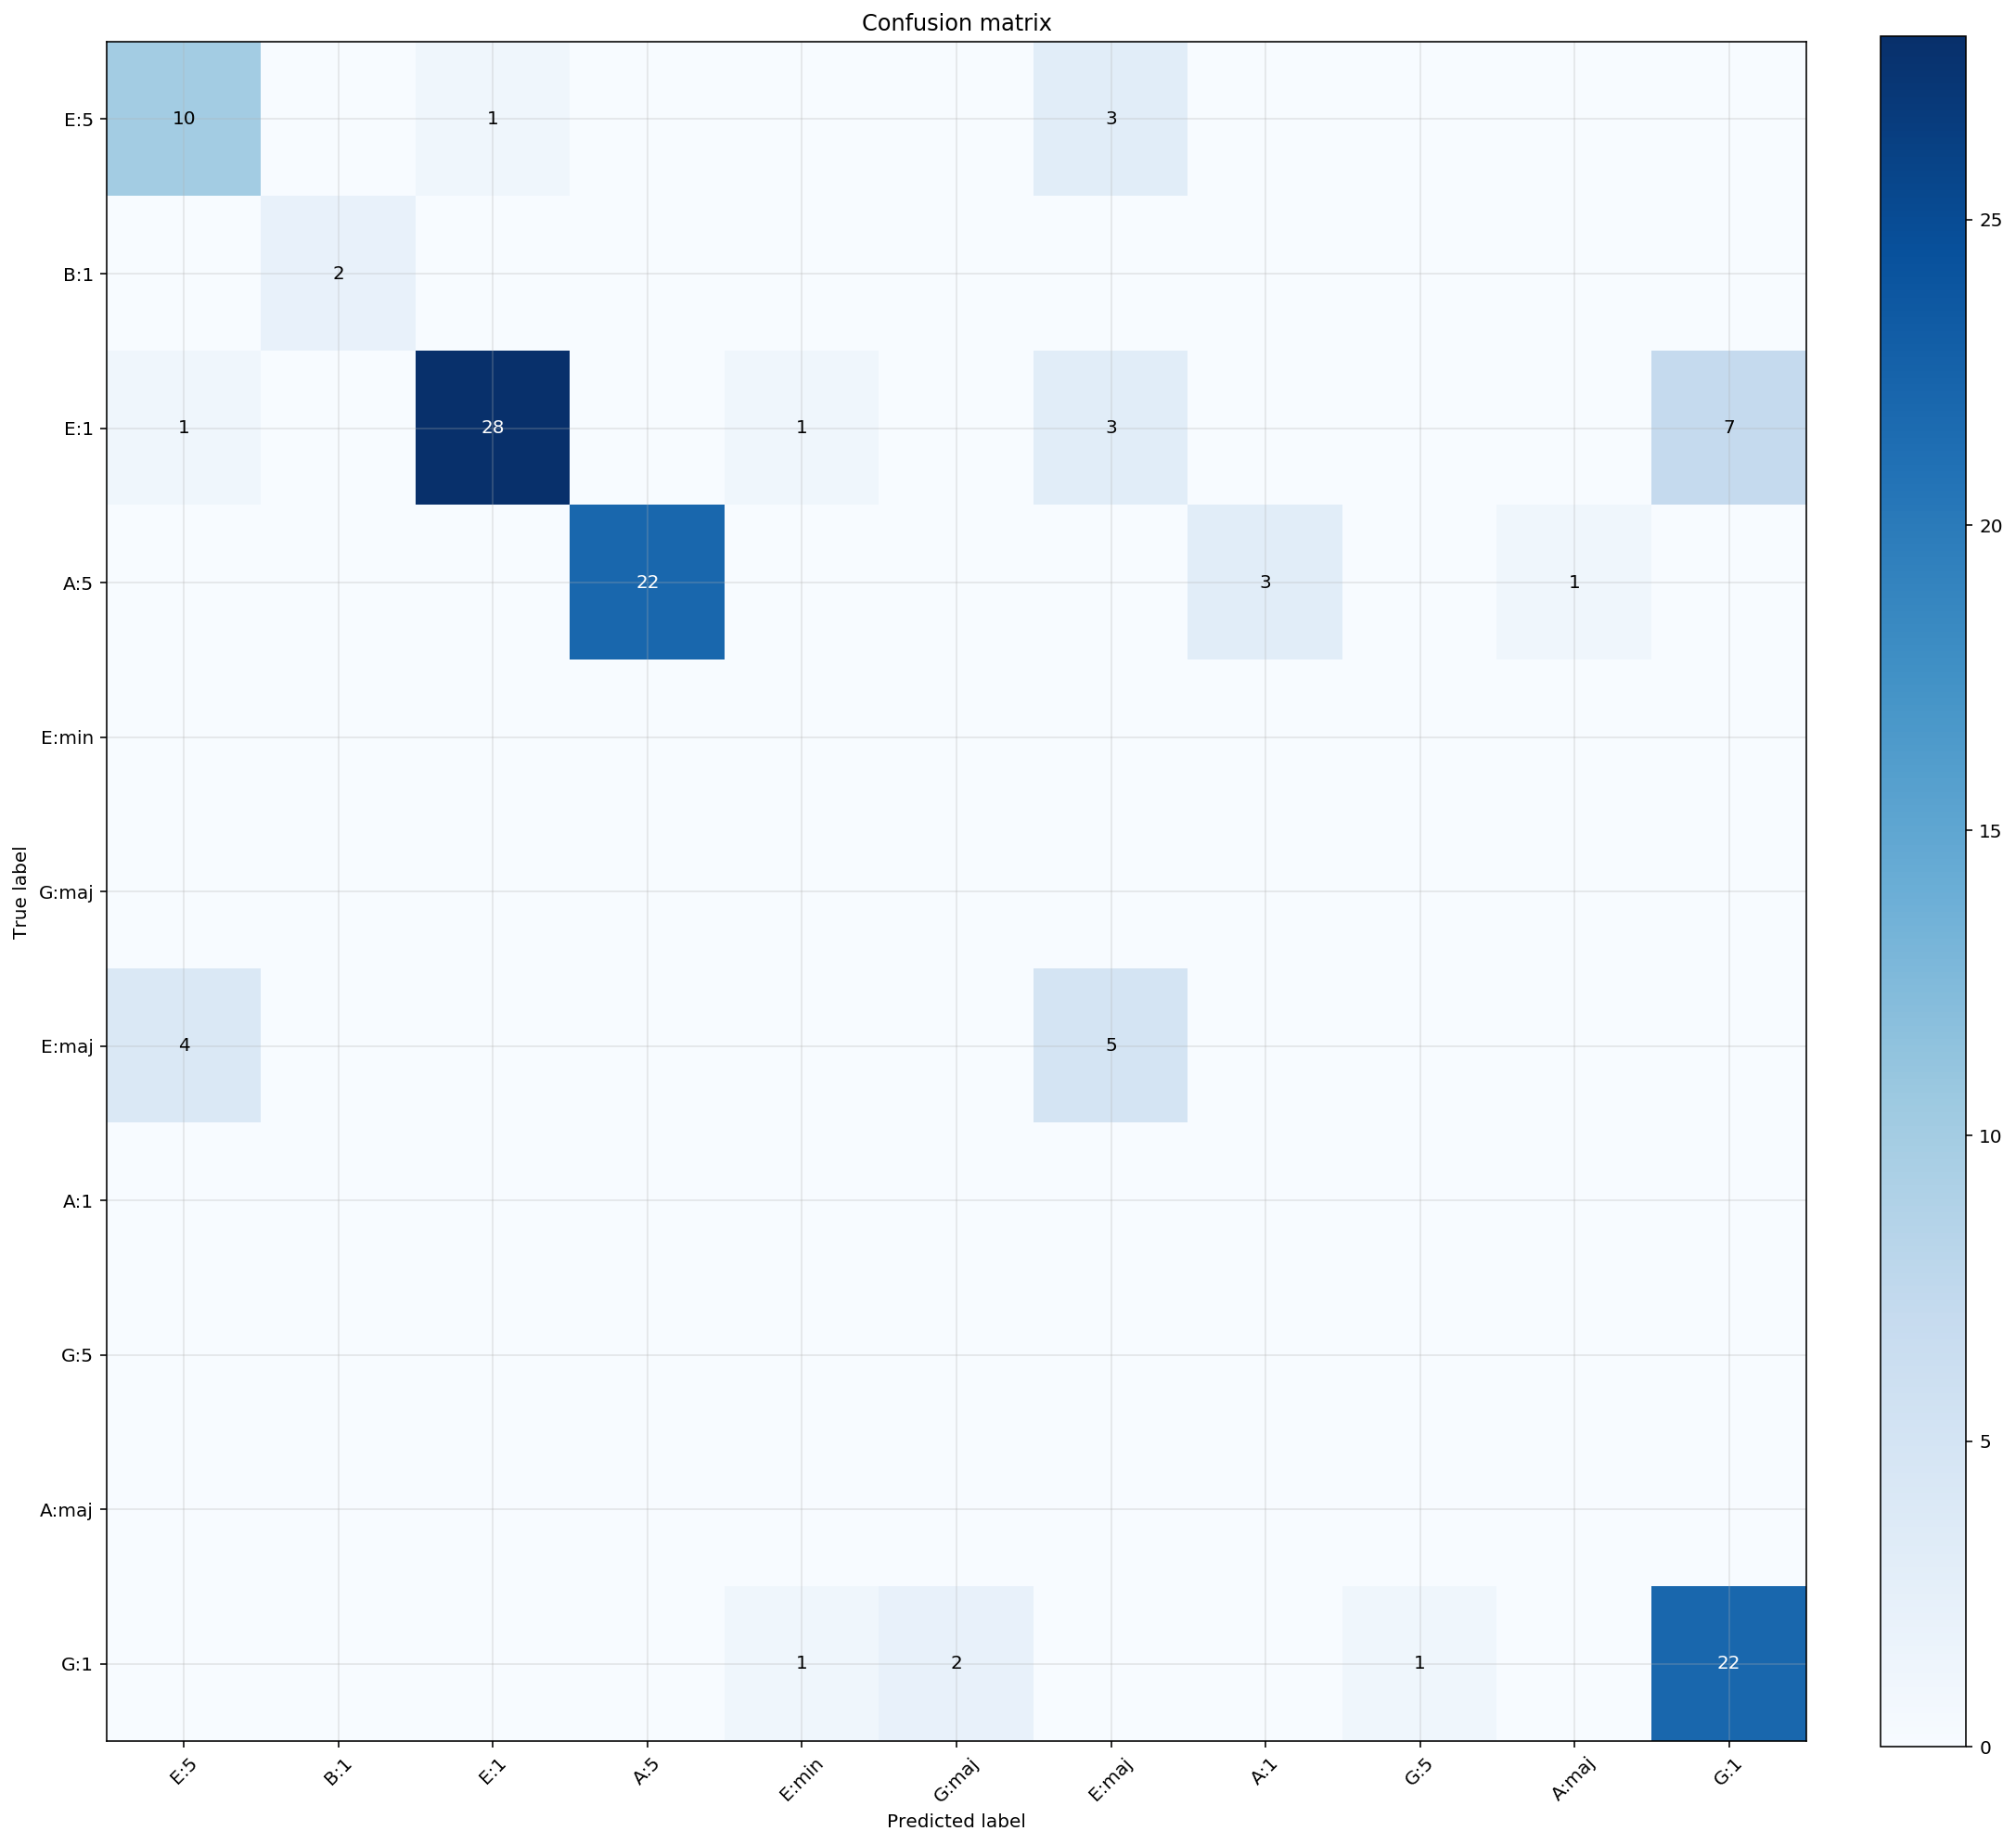

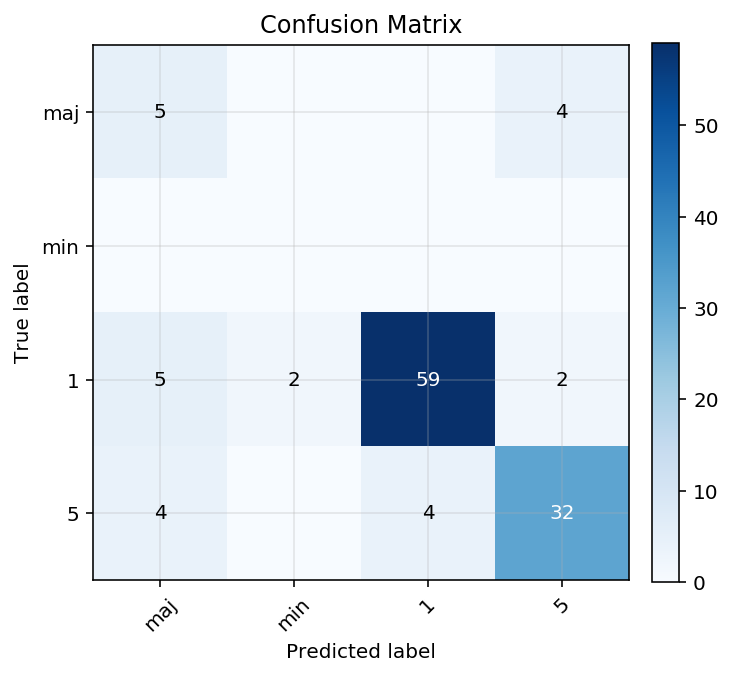

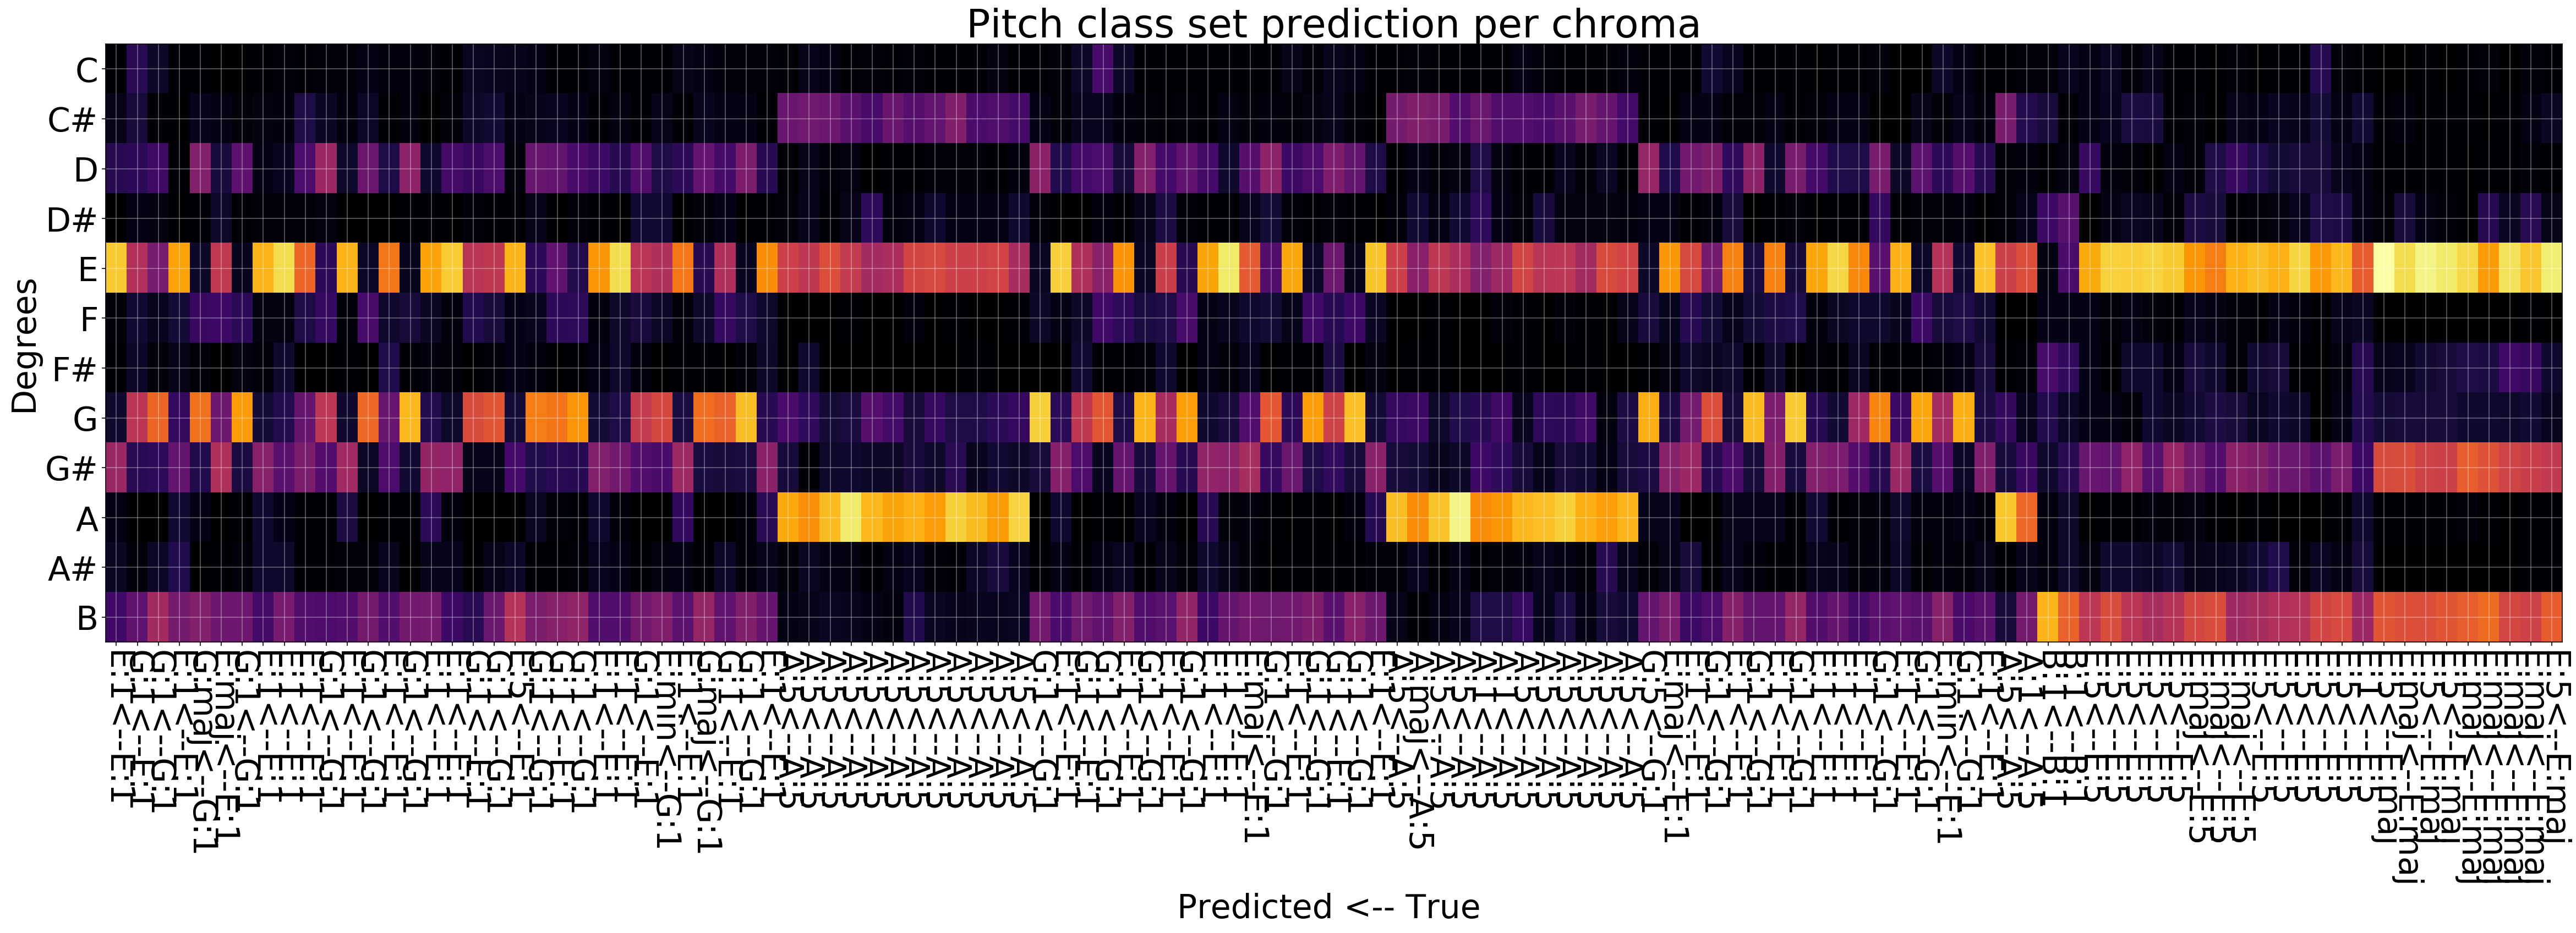

0.7606837606837606
For ../Databases/Augmented_database/SOX_Effects/Century_Eastman_130_Flanger.wav model obtain 0.7606837606837606 accuracy.
../Databases/Augmented_database/SOX_Effects/Century_Eastman_130_Phaser.wav


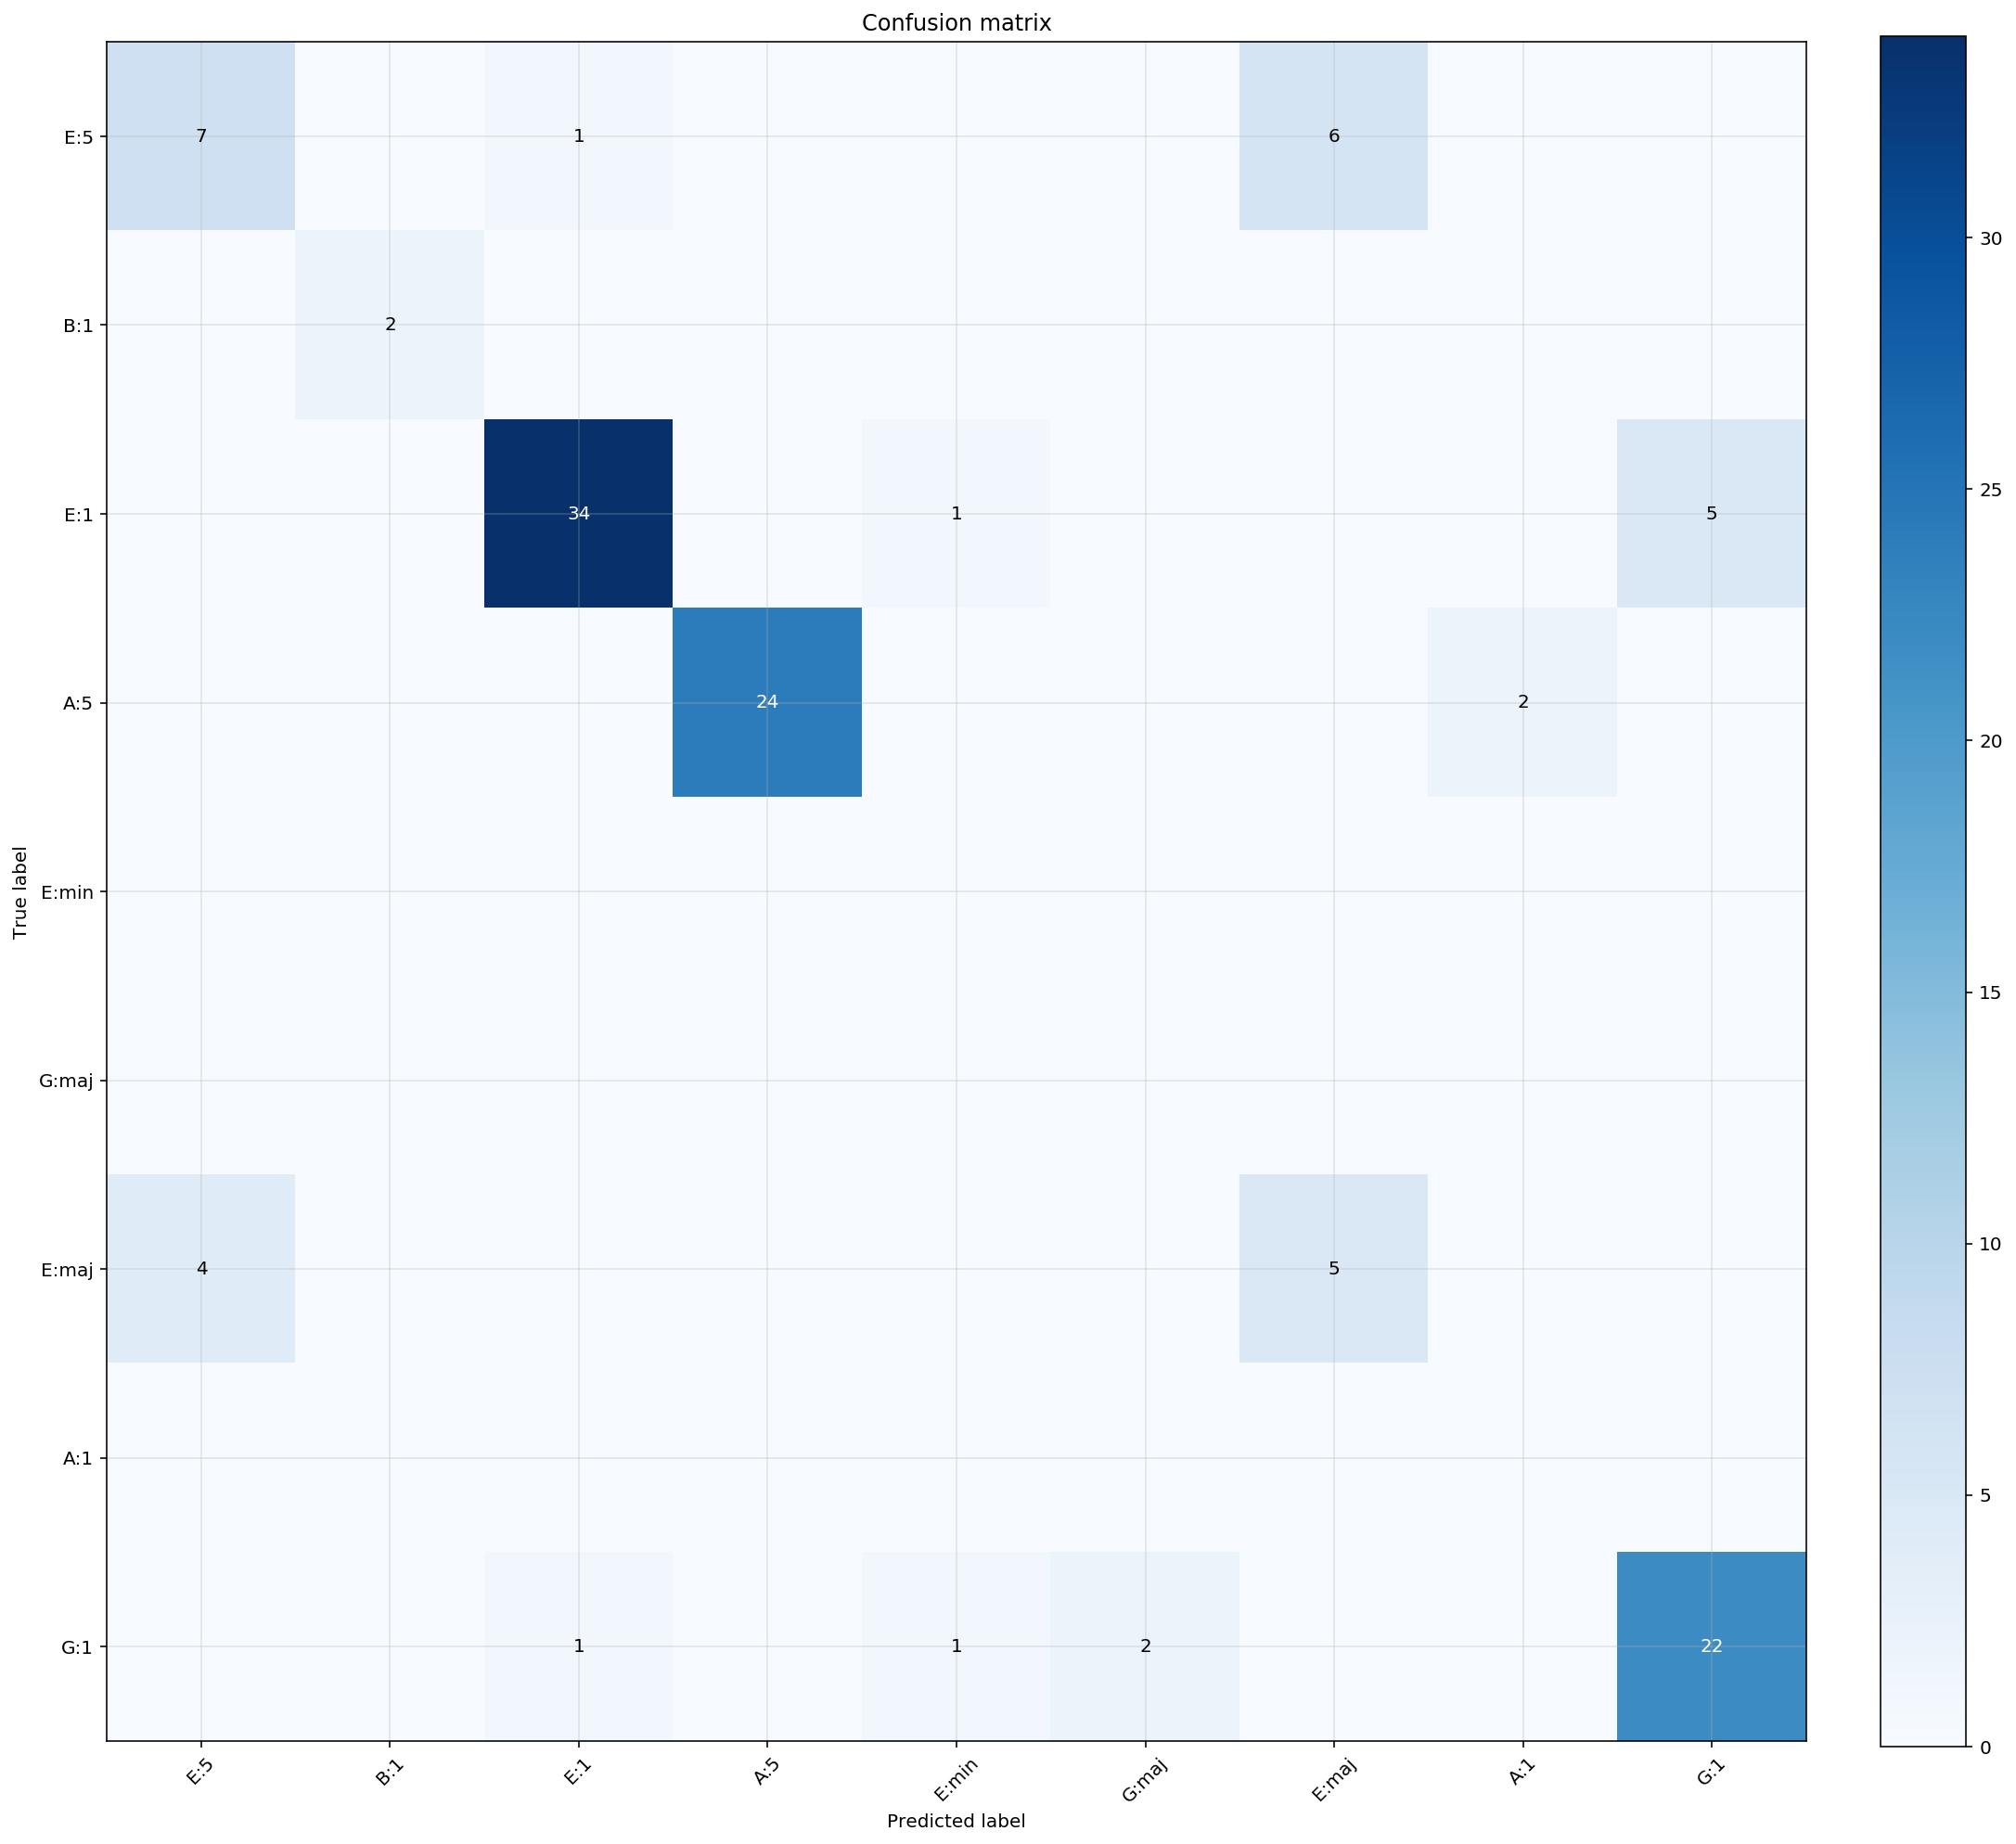

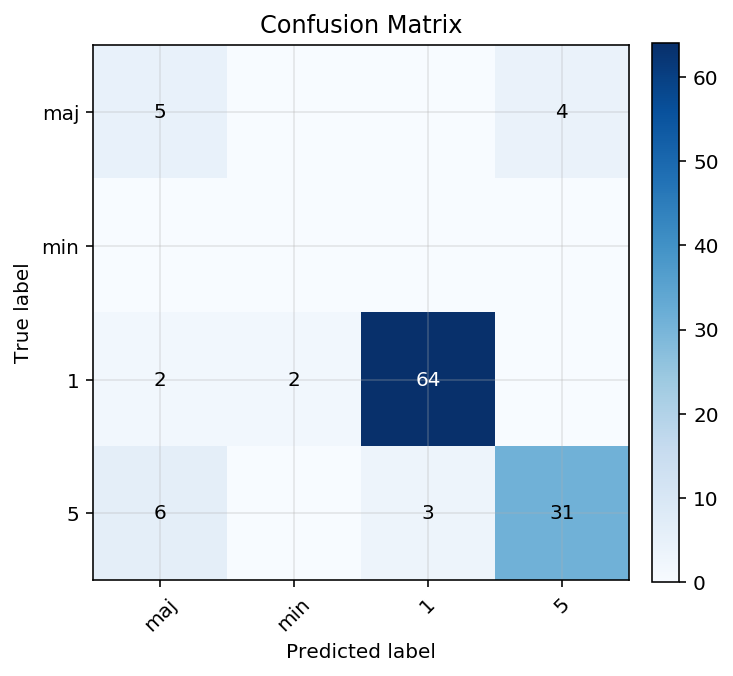

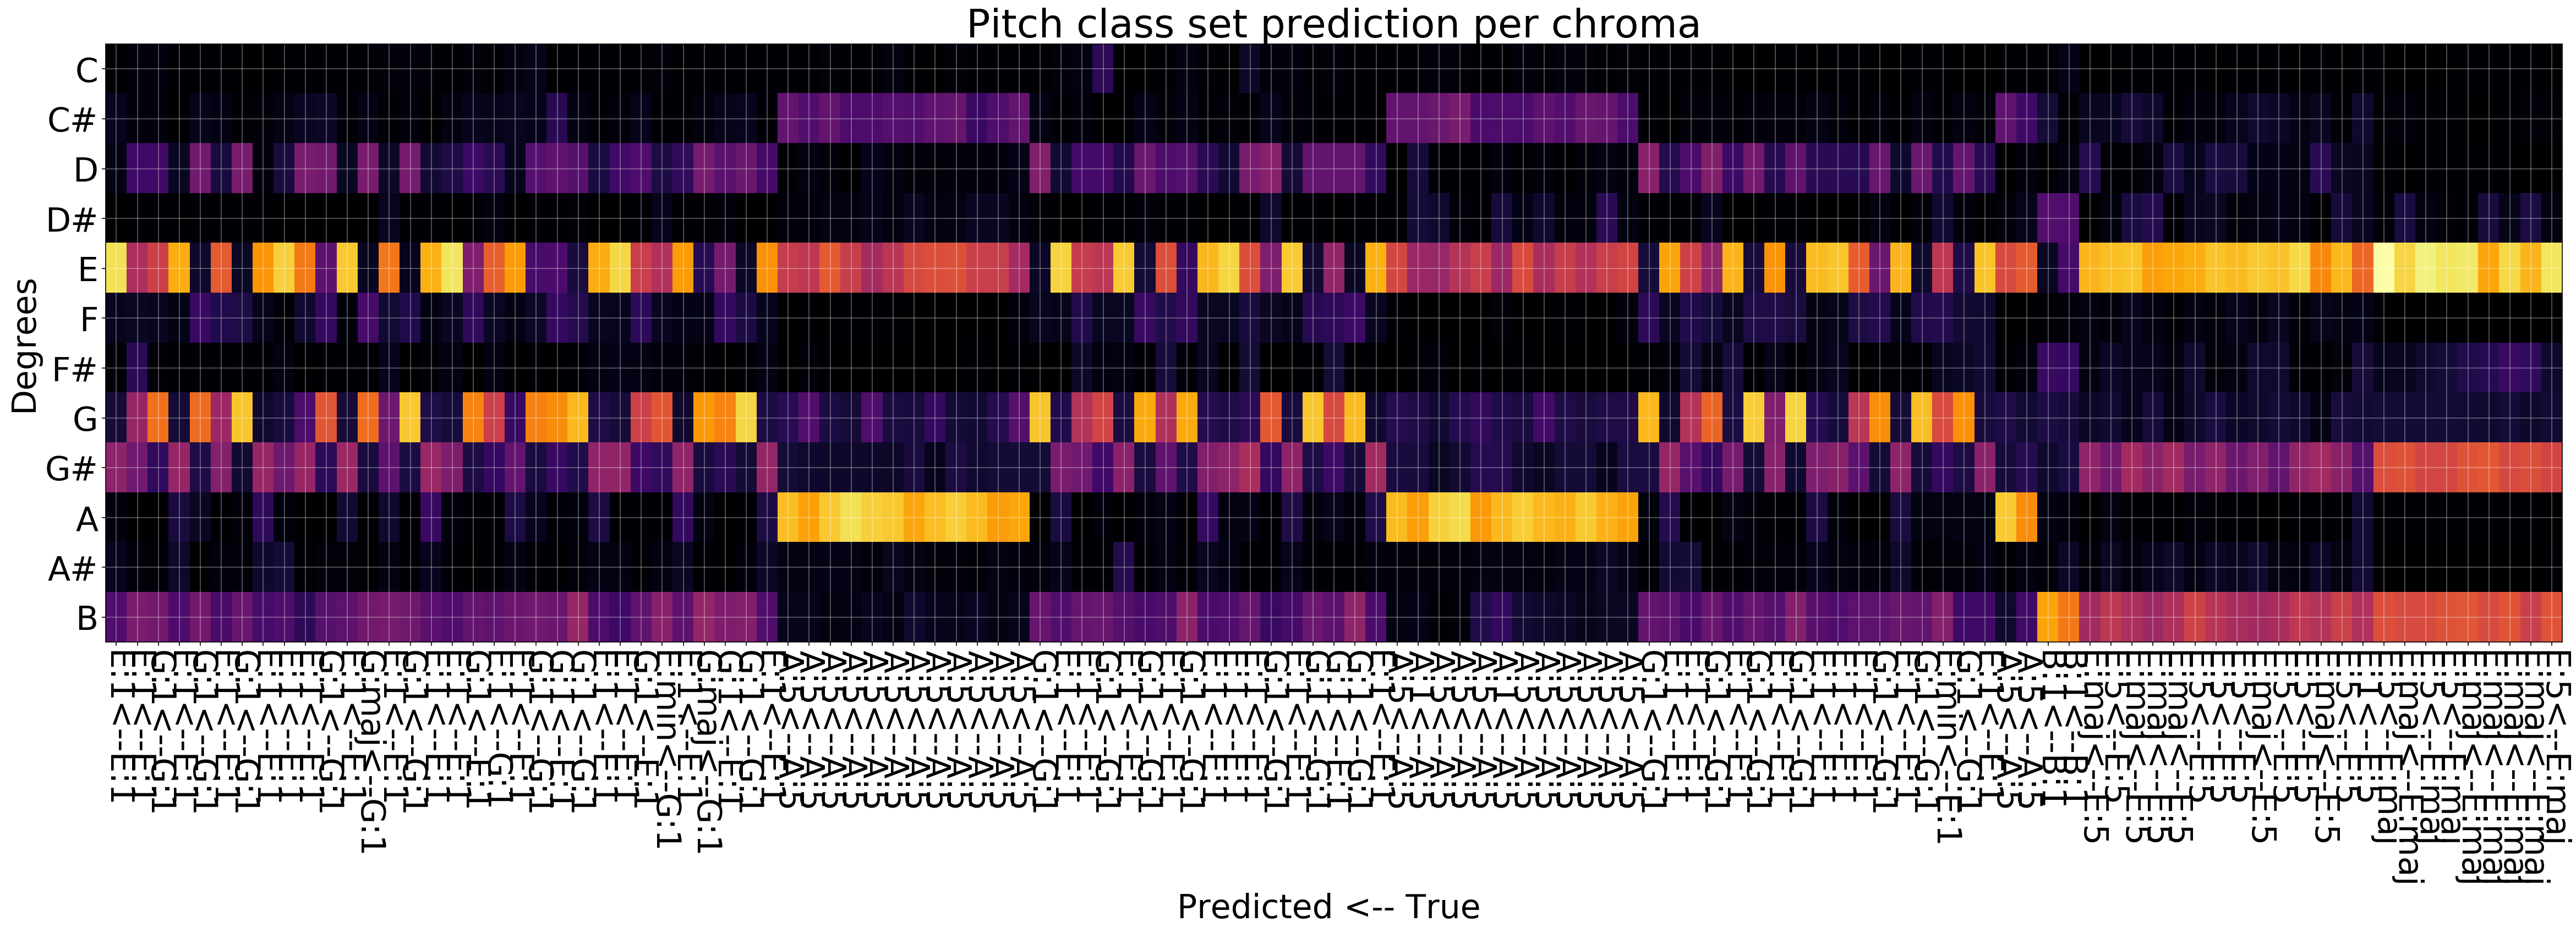

0.8034188034188035
For ../Databases/Augmented_database/SOX_Effects/Century_Eastman_130_Phaser.wav model obtain 0.8034188034188035 accuracy.
../Databases/Augmented_database/SOX_Effects/Century_Eastman_130_Chorus.wav


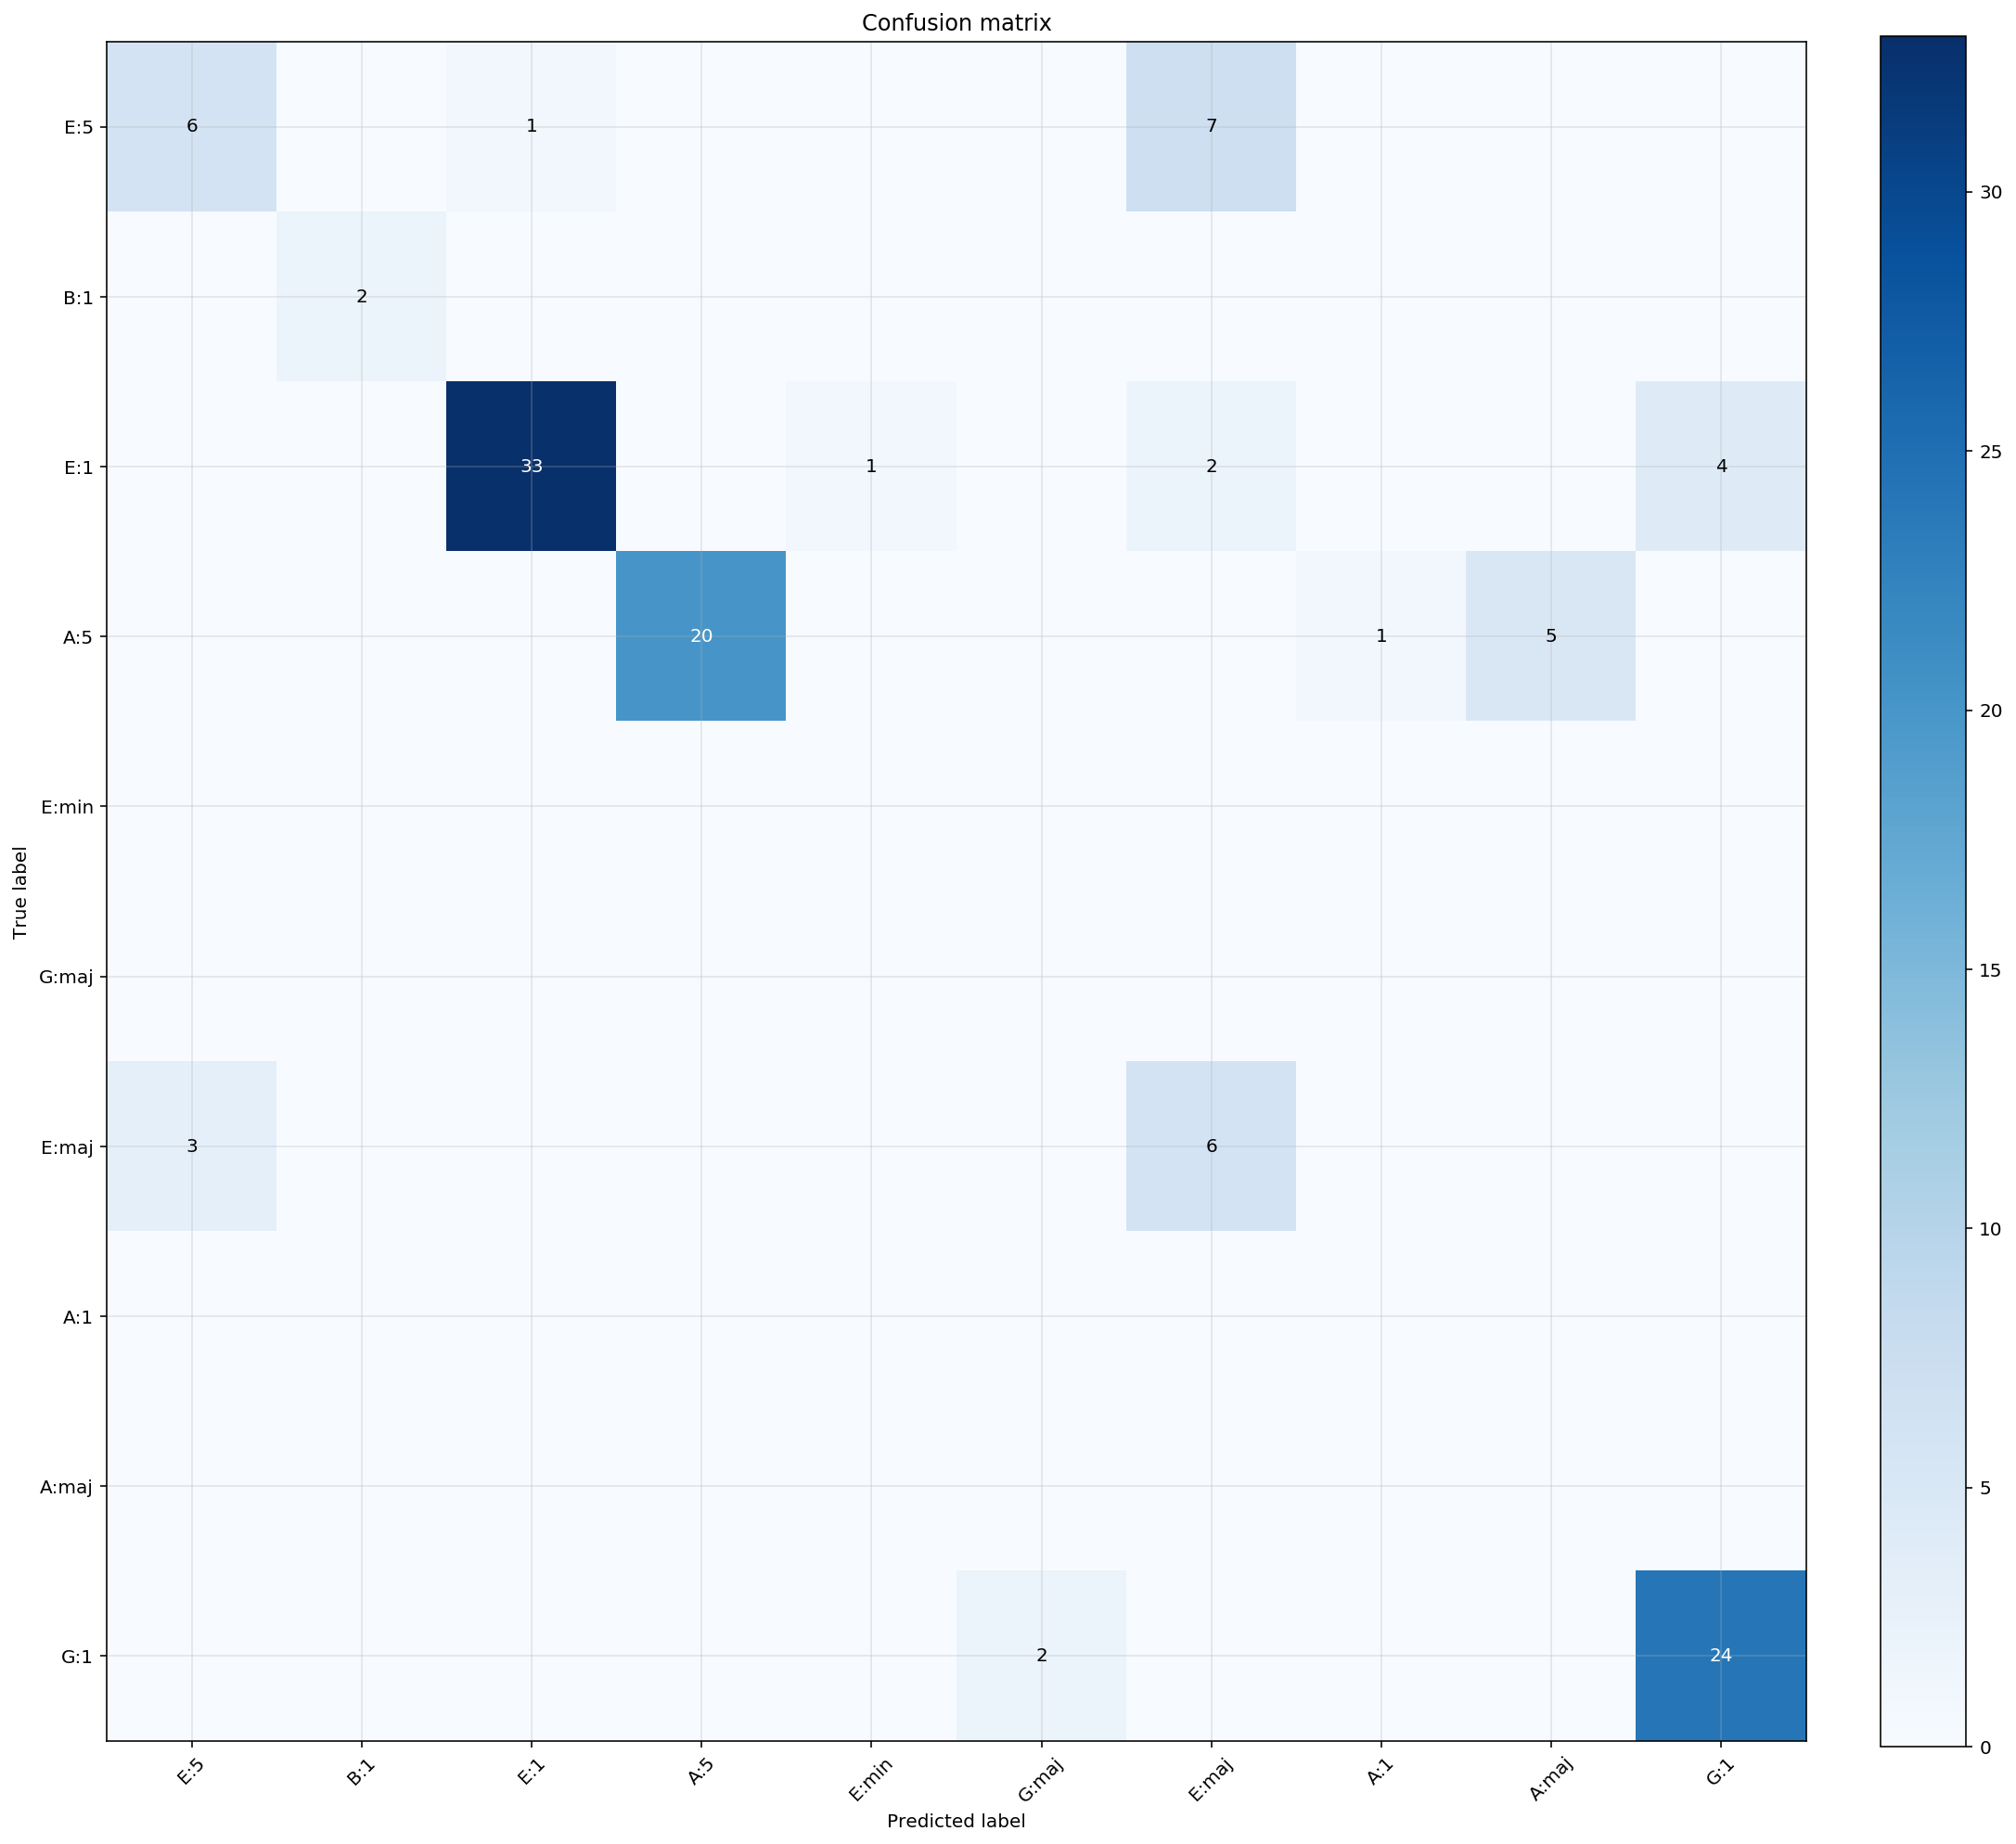

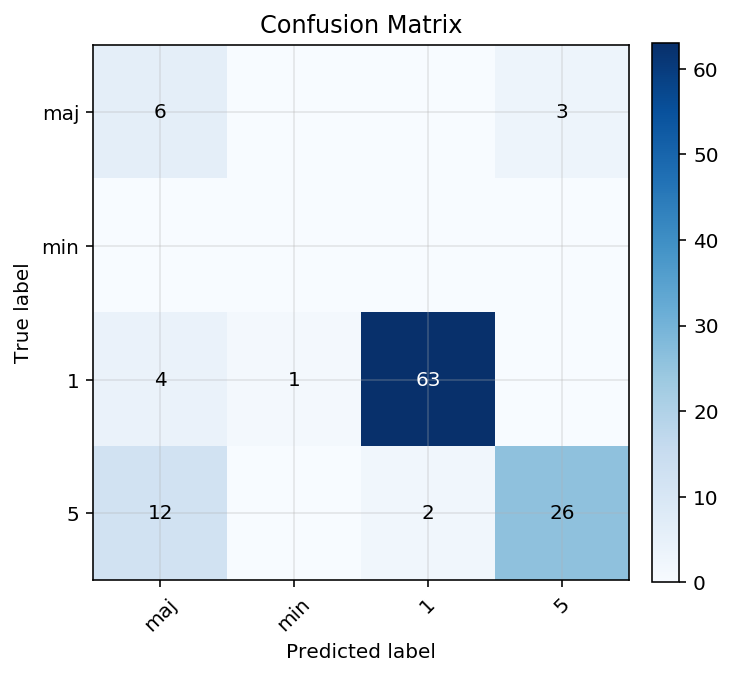

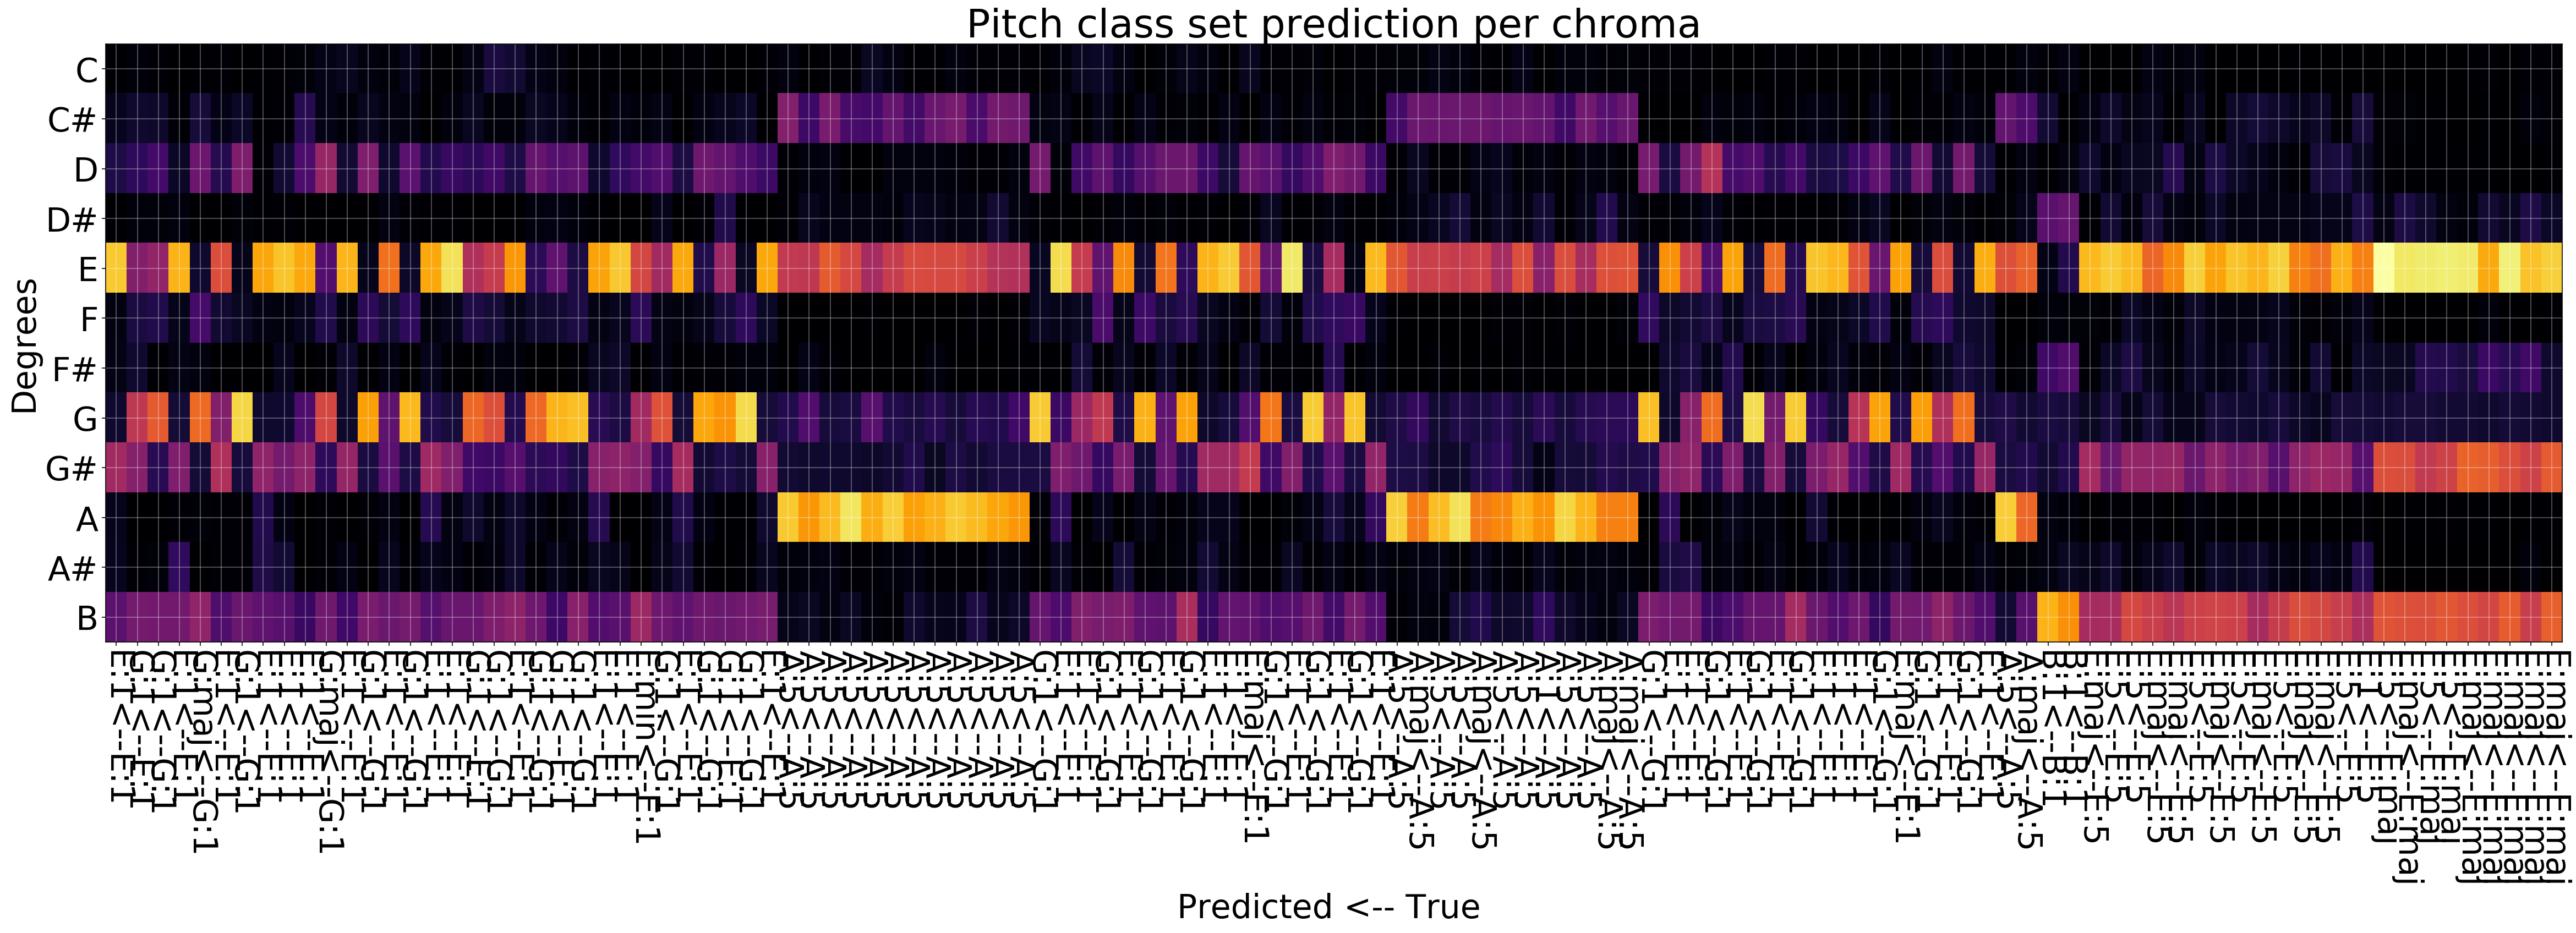

0.7777777777777778
For ../Databases/Augmented_database/SOX_Effects/Century_Eastman_130_Chorus.wav model obtain 0.7777777777777778 accuracy.
../Databases/Augmented_database/SOX_Effects/Century_Eastman_130_OverDrive.wav


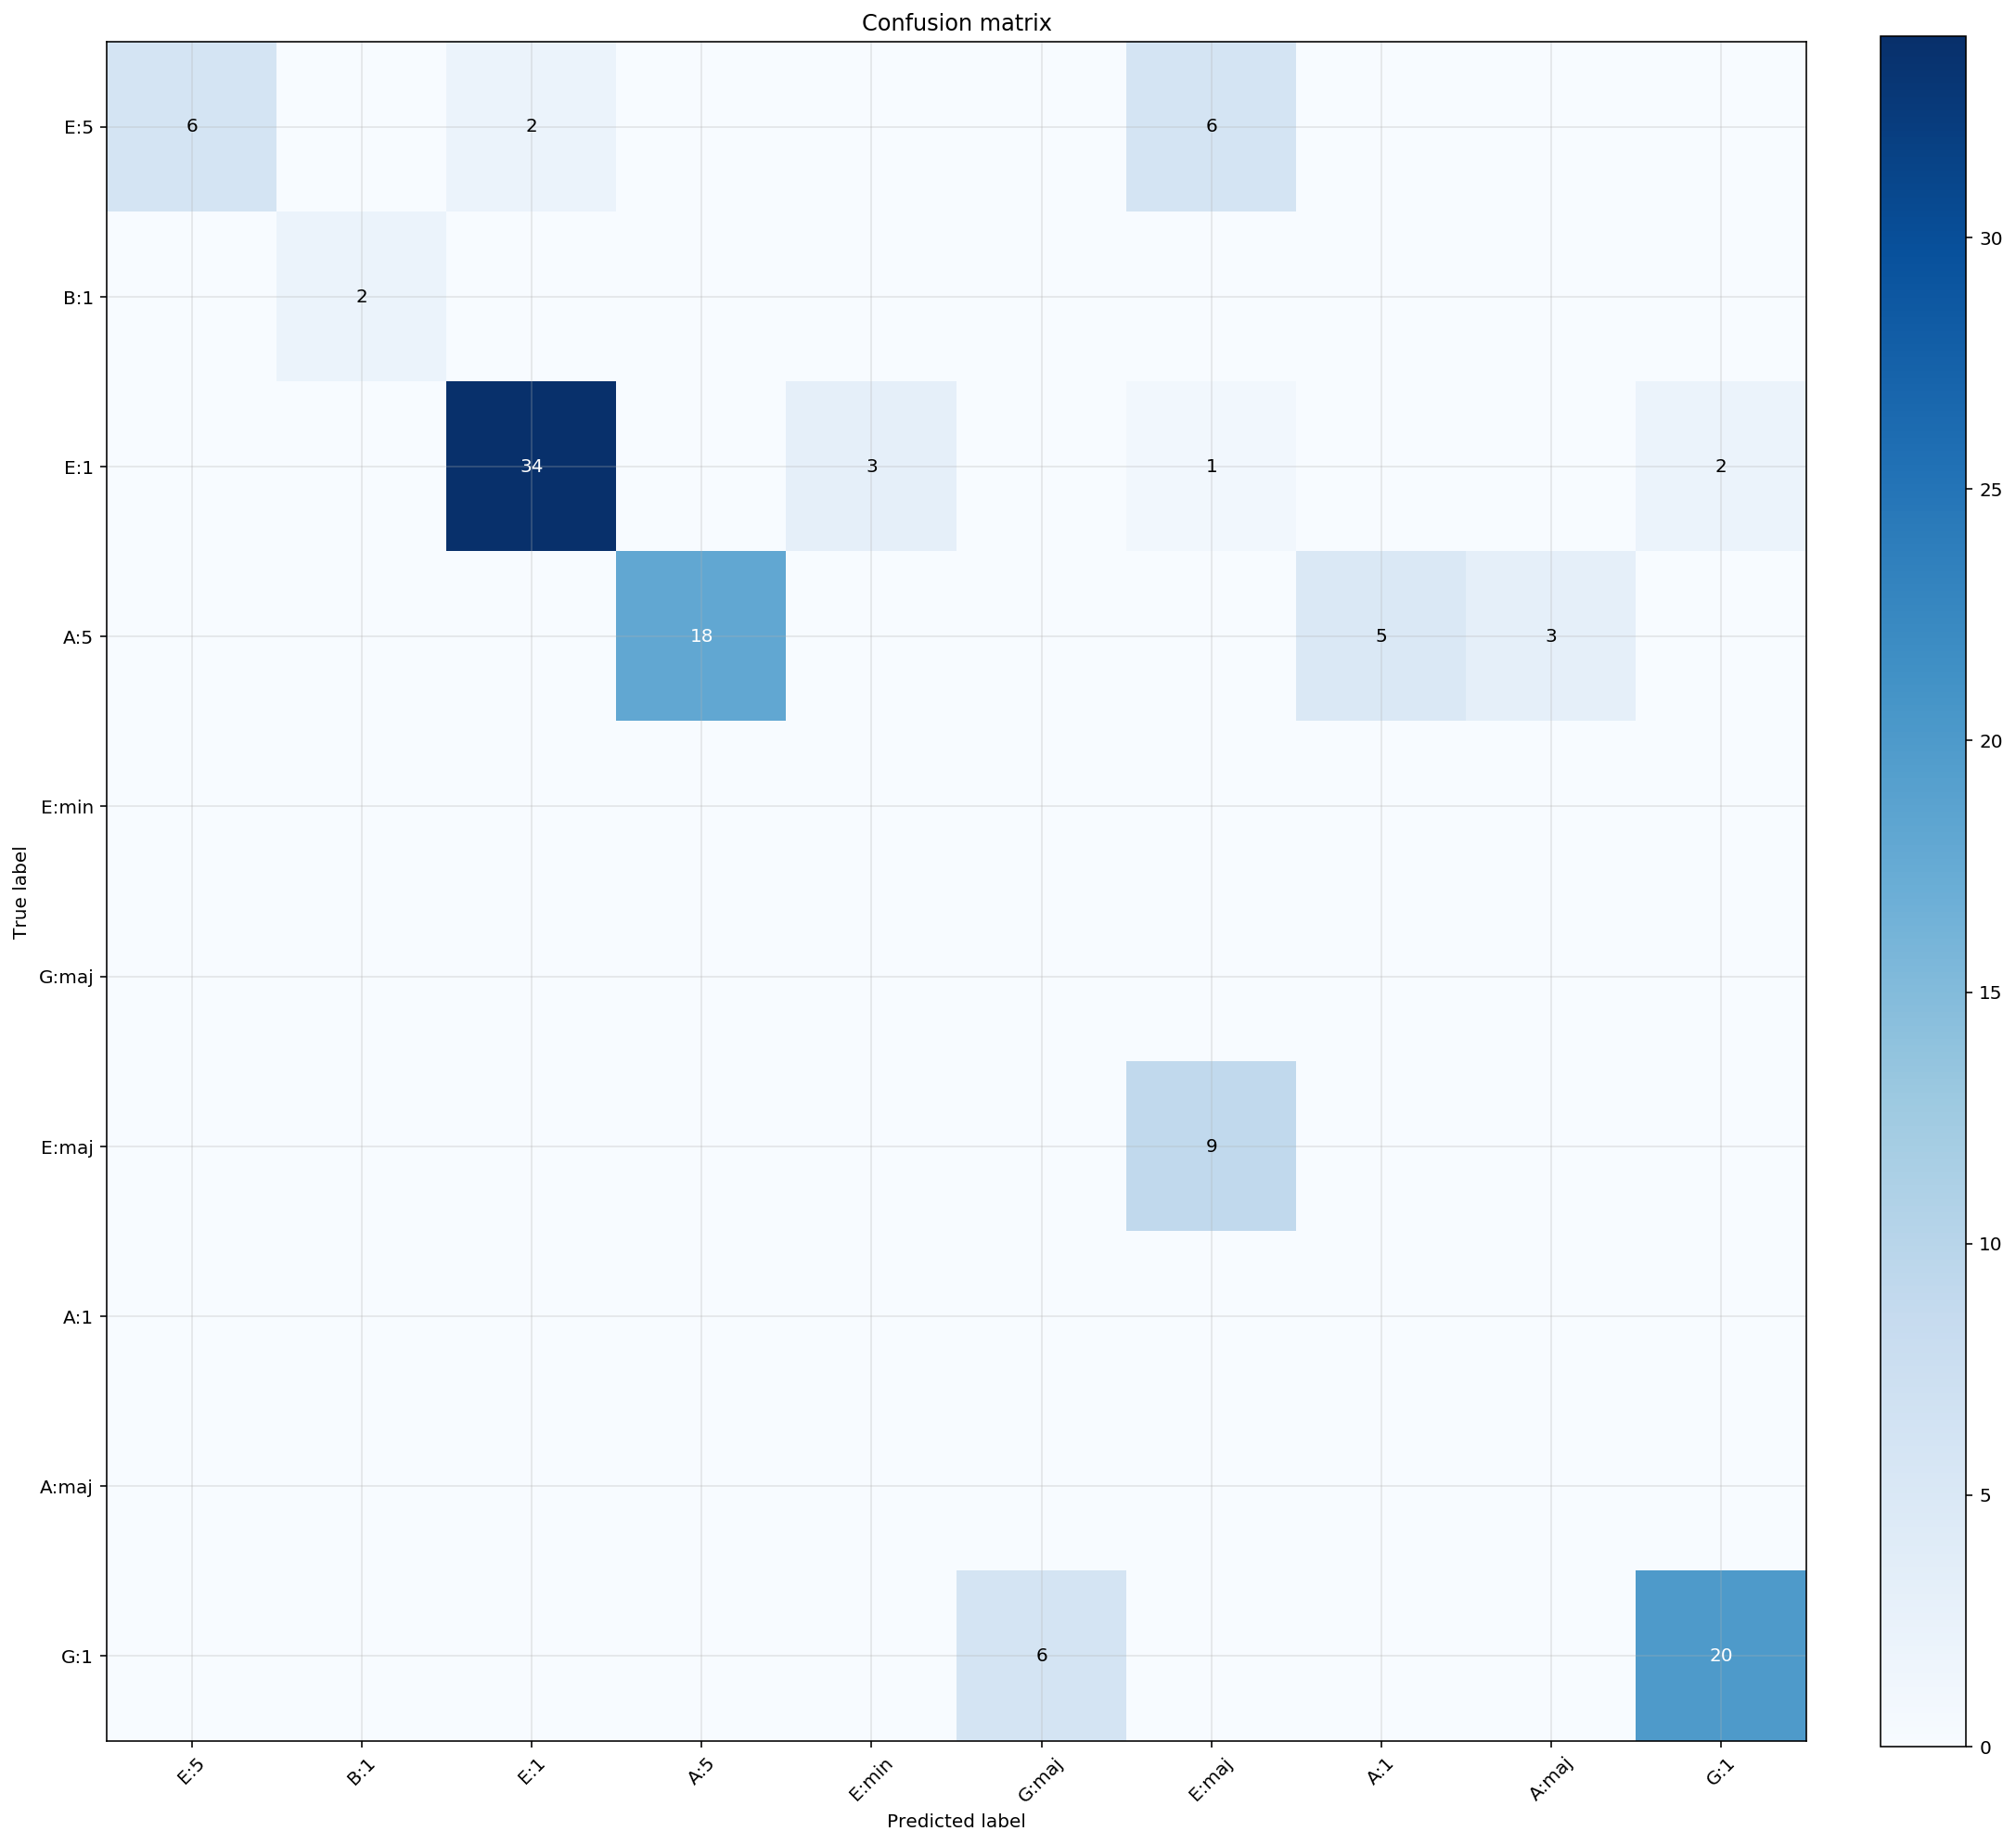

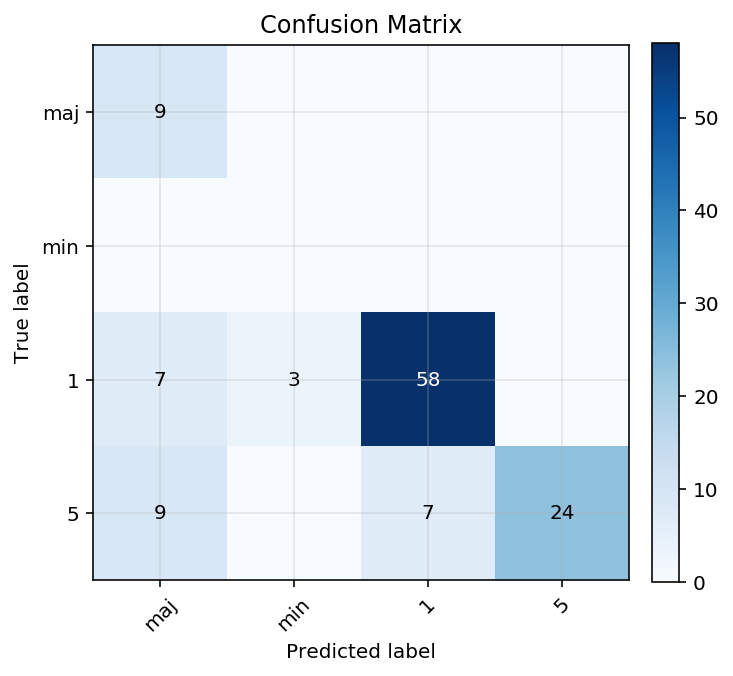

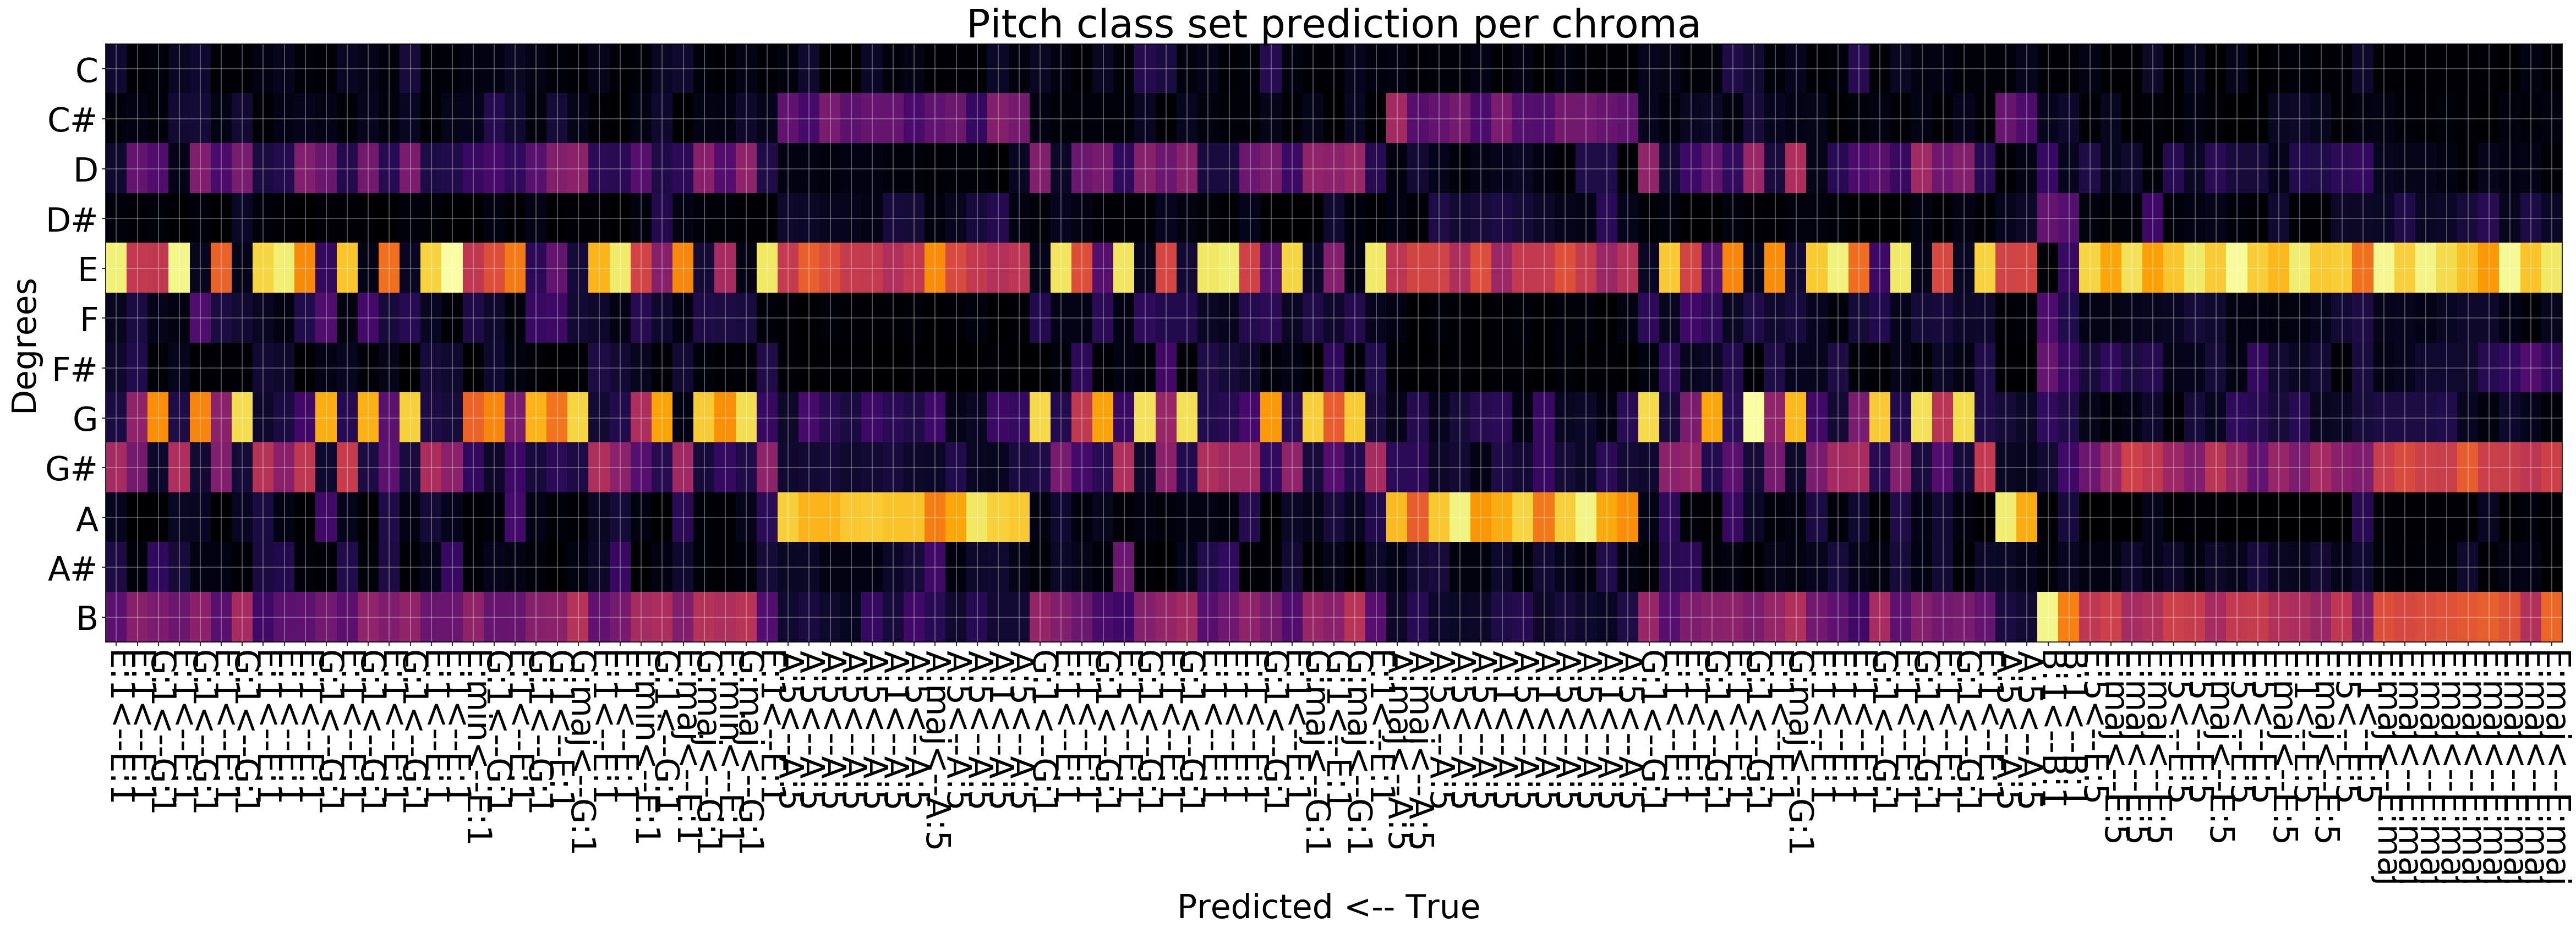

0.7606837606837606
For ../Databases/Augmented_database/SOX_Effects/Century_Eastman_130_OverDrive.wav model obtain 0.7606837606837606 accuracy.


In [92]:
for rec in recordings:
    plt.rcParams.update({'font.size':10})
    print(rec)
    song = rec.split('/')[-1].split('_')[0]
    
    IM = Individual_Metrics(song_2_anno[song],rec,model_path, labels_kinds = ['maj','min','5','1'],
                           info =False, debug = False)
    
    acc = IM.overall_accuracy()
    IM.plot_confusion_matrix()
    gt_kinds = [p.split(':')[-1] for p in IM.gt]
    pred_kinds = [p.split(':')[-1] for p in IM.pred]
    OM = Kind_Metrics(gt_kinds, pred_kinds,labels = ['maj','min','1','5'])
    OM.conf_matrix()
    IM.plot_chroma_scores()
    print(acc)
    print('For {} model obtain {} accuracy.'.format(rec,acc))